In [1]:
%matplotlib inline
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate
import seaborn as sns
import itertools
from matplotlib.lines import Line2D
import matplotlib.pylab as plb
from sklearn.linear_model import LinearRegression
import matplotlib.style as style
from matplotlib.patches import Patch

#data_path = "/Users/Broccolee/Google Drive/Grad School/TU BERLIN/Negative Emissions & Carbon Markets/Data/"
#plot_path = "/Users/Broccolee/Google Drive/Grad School/TU BERLIN/Negative Emissions & Carbon Markets/Plots/"
data_path = "/Users/kaylinlee/Desktop/KL_ISIpedia/Thesis/Code/Data/"
plot_path = "/Users/kaylinlee/Desktop/KL_ISIpedia/Thesis/Code/Plots/"

pd.set_option('display.max_columns', 500)

In [114]:
main_remind=pd.read_excel(data_path+'REMIND_processed_output_FAO_wCP.xls')
main_image=pd.read_excel(data_path+'IMAGE_processed_output_FAO_wCP.xls')
#main_strefler=pd.read_excel(data_path+'STREFLER_processed_output_inkl2015.xls')
#main_message=pd.read_excel(data_path+'MESSAGE_processed_output_FAO.xls')

In [115]:
regions_rem = ['AFR', 'CHN', 'EUR', 'IND', 'JPN', 'LAM', 'MEA', 'OAS', 'ROW', 'RUS', 'USA', 'World']
regions_ima = ['BRA', 'CAN', 'CEU', 'CHN', 'EAF', 'INDIA', 'INDO', 'JAP', 'KOR', 'ME', 'MEX', 'NAF',
 'OCE', 'RCAM', 'RSAF', 'RSAM', 'RSAS', 'RUS', 'SAF', 'SEAS', 'STAN', 'TUR', 'UKR',
 'USA', 'WAF', 'WEU', 'World']
#regions_mes = ['CHN', 'EU', 'IND', 'R11_AFR', 'R11_FSU', 'R11_LAM',
# 'R11_MEA', 'R11_PAO', 'R11_PAS', 'USA', 'World']

regions_rem_noworld = ['AFR', 'CHN', 'EUR', 'IND', 'JPN', 'LAM', 'MEA', 'OAS', 'ROW', 'RUS', 'USA']
regions_ima_noworld = ['BRA', 'CAN', 'CEU', 'CHN', 'EAF', 'INDIA', 'INDO', 'JAP', 'KOR', 'ME', 'MEX', 'NAF',
 'OCE', 'RCAM', 'RSAF', 'RSAM', 'RSAS', 'RUS', 'SAF', 'SEAS', 'STAN', 'TUR', 'UKR',
 'USA', 'WAF', 'WEU']
#regions_mes_noworld = ['CHN', 'EU', 'IND', 'R11_AFR', 'R11_FSU', 'R11_LAM',
# 'R11_MEA', 'R11_PAO', 'R11_PAS',  'USA']


def GDP_cap_calc(main_df, regions_names):
    main_df['GDP'] = main_df['GDP']*1000
    main_df['Unit_GDP'] = 'USD Million'
    main_df['GDP_cap'] = 0
    main_df['GDP_cap_avg'] = 0
    wfilt = (main_df.Region == 'World')

    for scen in main_df.Scenario.unique():
            rfilt=(main_df.Region.isin(regions_names))
            sfilt=(main_df.Scenario==scen)

            for yr in main_df.Year.unique(): 
                yrfilt=(main_df.Year==yr)
                main_df.loc[sfilt&yrfilt&rfilt,
                            'GDP_cap'] = main_df.loc[
                    rfilt&yrfilt&sfilt,'GDP'].values/main_df.loc[rfilt&yrfilt&sfilt,'Population'].values  
                main_df.loc[sfilt&yrfilt&rfilt,
                            'GDP_cap_avg'] = sum(main_df.loc[wfilt&sfilt&yrfilt, 'GDP_cap'])
    return main_df

main_image = GDP_cap_calc(main_image, regions_ima)
main_remind = GDP_cap_calc(main_remind, regions_rem)
#main_message = GDP_cap_calc(main_message, regions_mes)
#main_strefler = GDP_cap_calc(main_strefler, regions_rem)


In [34]:
main_image[['Region','GDP_cap','GDP_cap_avg']]

,Region,GDP_cap,GDP_cap_avg
0,BRA,12861.075609,13439.002909
1,BRA,17731.948605,19332.175105
2,BRA,24447.760709,26606.486333
3,BRA,32151.879584,34148.221822
4,BRA,40536.233586,41955.255688
...,...,...,...
481,World,29942.025230,29942.025230
482,World,35557.562874,35557.562874
483,World,42160.232136,42160.232136
484,World,49971.097198,49971.097198


In [116]:
# #turn below average GDP values to Nan -> exclued countries whose GDP per cap is below avg 
# 
def CoI_calc(main_df):

    mask = (main_df['GDP_cap'].values > main_df['GDP_cap_avg'].values)

    main_df['GDP_cap_CoI_nan'] = np.where(mask, main_df['GDP_cap'], np.nan)
    main_df['GDP_cap_CoI'] = np.where(mask, main_df['GDP_cap'], 0)
    main_df['GDP_CoI_nan'] = np.where(mask, main_df['GDP'], np.nan)
    main_df['GDP_CoI'] = np.where(mask, main_df['GDP'], 0)

    return main_df

main_image = CoI_calc(main_image)
main_remind = CoI_calc(main_remind)

# Fair share by GDP

In [117]:
def GDP_CoI_frac_calc(main_df, regions_names_noworld):    
    main_df['GDP_CoI_frac'] = 0

    for scen in main_df.Scenario.unique():
            rfilt=(main_df.Region.isin(regions_names_noworld))
            sfilt=(main_df.Scenario==scen)

            for yr in main_df.Year.unique(): 
                yrfilt=(main_df.Year==yr)
                tot_GDP_yr = main_df.loc[sfilt&yrfilt&rfilt,'GDP_CoI'].sum()
                main_df.loc[sfilt&yrfilt&rfilt,
                            'GDP_CoI_frac'] = (main_df.loc[rfilt&sfilt&yrfilt,'GDP_CoI'])/tot_GDP_yr
                main_df.loc[sfilt&yrfilt&rfilt,
                            'CDR_fair_share_by_GDP'] = (main_df.loc[rfilt&sfilt&yrfilt,'GDP_CoI_frac']
                                                       )*(main_df.loc[sfilt&yrfilt&(main_df.Region=='World'),'TOTAL_CDR'].values)
                main_df.loc[sfilt&yrfilt&rfilt,
                            'BECCS_fair_share_by_GDP'] = (main_df.loc[rfilt&sfilt&yrfilt,'GDP_CoI_frac']
                                                       )*(main_df.loc[sfilt&yrfilt&(main_df.Region=='World'),'BECCS'].values)
#                 main_df.loc[sfilt&yrfilt&rfilt,
#                             'CDR_fair_share_by_GDPXCarbonPrice'] = (main_df.loc[rfilt&sfilt&yrfilt,'CDR_fair_share_by_GDP'].values
#                                                                    )*(main_df.loc[sfilt&yrfilt&rfilt,'Carbon_Price'].values)*10**6
                main_df.loc[sfilt&yrfilt&rfilt,
                            'BECCS_fair_share_by_GDPXPrice'] = (main_df.loc[rfilt&sfilt&yrfilt,'BECCS_fair_share_by_GDP'].values
                                                                   )*(main_df.loc[sfilt&yrfilt&rfilt,'Carbon_Price'].values)*10**-3
                main_df.loc[sfilt&yrfilt&rfilt,
                            'BECCS_investments_by_GDP'] = (main_df.loc[rfilt&sfilt&yrfilt,'GDP_CoI_frac']
                                                          )*(main_df.loc[sfilt&yrfilt&(main_df.Region=='World'),'BECCS_Investments'].values)
                              
    main_df['CUM_CDR_fair_share_by_GDP'] = 0
    for scen in main_df.Scenario.unique():
        for reg in main_df.Region.unique():
            main_df.loc[(main_df.Year == 2020), 'CUM_CDR_fair_share_by_GDP'] = main_df.loc[(main_df.Year == 2020), 'CDR_fair_share_by_GDP'] 

    for reg in main_df.Region.unique():
        if reg in regions_names_noworld:
            mask = main_df.Region == reg
            full_reg = main_df.loc[mask,:]

            for scen in full_reg.Scenario.unique():
                mask_scen = full_reg.Scenario == scen
                full_scen = full_reg.loc[mask_scen,:]
                integral = integrate.cumtrapz(y = full_scen.CDR_fair_share_by_GDP, x = full_scen.Year, initial = 0)
                full_reg.loc[mask_scen,'CUM_CDR_fair_share_by_GDP'] += integral
            main_df.loc[mask,'CUM_CDR_fair_share_by_GDP'] = full_reg.loc[:,'CUM_CDR_fair_share_by_GDP']

    main_df['CUM_BECCS_fair_share_by_GDP'] = 0
    for scen in main_df.Scenario.unique():
        for reg in main_df.Region.unique():
            main_df.loc[(main_df.Year == 2020), 'CUM_BECCS_fair_share_by_GDP'] = main_df.loc[(main_df.Year == 2020), 'BECCS_fair_share_by_GDP'] 

    for reg in main_df.Region.unique():
        if reg in regions_names_noworld:
            mask = main_df.Region == reg
            full_reg = main_df.loc[mask,:]

            for scen in full_reg.Scenario.unique():
                mask_scen = full_reg.Scenario == scen
                full_scen = full_reg.loc[mask_scen,:]
                integral = integrate.cumtrapz(y = full_scen.BECCS_fair_share_by_GDP, x = full_scen.Year, initial = 0)
                full_reg.loc[mask_scen,'CUM_BECCS_fair_share_by_GDP'] += integral
            main_df.loc[mask,'CUM_BECCS_fair_share_by_GDP'] = full_reg.loc[:,'CUM_BECCS_fair_share_by_GDP']
            
    main_df['CUM_BECCS_investments_by_GDP'] = 0
    for scen in main_df.Scenario.unique():
        for reg in main_df.Region.unique():
            main_df.loc[(main_df.Year == 2020), 'CUM_BECCS_investments_by_GDP'] = main_df.loc[(main_df.Year == 2020), 'BECCS_investments_by_GDP'] 

    for reg in main_df.Region.unique():
        if reg in regions_names_noworld:
            mask = main_df.Region == reg
            full_reg = main_df.loc[mask,:]

            for scen in full_reg.Scenario.unique():
                mask_scen = full_reg.Scenario == scen
                full_scen = full_reg.loc[mask_scen,:]
                integral = integrate.cumtrapz(y = full_scen.BECCS_investments_by_GDP, x = full_scen.Year, initial = 0)
                full_reg.loc[mask_scen,'CUM_BECCS_investments_by_GDP'] += integral
            main_df.loc[mask,'CUM_BECCS_investments_by_GDP'] = full_reg.loc[:,'CUM_BECCS_investments_by_GDP']

#    main_df['CUM_PriceXTotalCDR'] = 0
#     for scen in main_df.Scenario.unique():
#         for reg in main_df.Region.unique():
#             main_df.loc[(main_df.Year == 2020), 'CUM_PriceXTotalCDR'] = main_df.loc[(main_df.Year == 2020), 'PriceXTotalCDR'] 

#     for reg in main_df.Region.unique():
#         if reg in regions_names_noworld:
#             mask = main_df.Region == reg
#             full_reg = main_df.loc[mask,:]

#             for scen in full_reg.Scenario.unique():
#                 mask_scen = full_reg.Scenario == scen
#                 full_scen = full_reg.loc[mask_scen,:]
#                 integral = integrate.cumtrapz(y = full_scen.PriceXTotalCDR, x = full_scen.Year, initial = 0)
#                 full_reg.loc[mask_scen,'CUM_PriceXTotalCDR'] += integral
#             main_df.loc[mask,'CUM_PriceXTotalCDR'] = full_reg.loc[:,'CUM_PriceXTotalCDR']

#     main_df['CUM_CDR_fair_share_by_GDPXCarbonPrice'] = 0
#     for scen in main_df.Scenario.unique():
#         for reg in main_df.Region.unique():
#             main_df.loc[(main_df.Year == 2020), 'CUM_CDR_fair_share_by_GDPXCarbonPrice'] = main_df.loc[(main_df.Year == 2020), 'CDR_fair_share_by_GDPXCarbonPrice'] 

#     for reg in main_df.Region.unique():
#         if reg in regions_names_noworld:
#             mask = main_df.Region == reg
#             full_reg = main_df.loc[mask,:]

#             for scen in full_reg.Scenario.unique():
#                 mask_scen = full_reg.Scenario == scen
#                 full_scen = full_reg.loc[mask_scen,:]
#                 integral = integrate.cumtrapz(y = full_scen.CDR_fair_share_by_GDPXCarbonPrice, x = full_scen.Year, initial = 0)
#                 full_reg.loc[mask_scen,'CUM_CDR_fair_share_by_GDPXCarbonPrice'] += integral
#             main_df.loc[mask,'CUM_CDR_fair_share_by_GDPXCarbonPrice'] = full_reg.loc[:,'CUM_CDR_fair_share_by_GDPXCarbonPrice']

#cumulative BECCS cost values with carbon pricing
    main_df['CUM_PriceXBECCS'] = 0
    for scen in main_df.Scenario.unique():
        for reg in main_df.Region.unique():
            main_df.loc[(main_df.Year == 2020), 'CUM_PriceXBECCS'] = main_df.loc[(main_df.Year == 2020), 'PriceXBECCS'] 

    for reg in main_df.Region.unique():
        if reg in regions_names_noworld:
            mask = main_df.Region == reg
            full_reg = main_df.loc[mask,:]

            for scen in full_reg.Scenario.unique():
                mask_scen = full_reg.Scenario == scen
                full_scen = full_reg.loc[mask_scen,:]
                integral = integrate.cumtrapz(y = full_scen.PriceXBECCS, x = full_scen.Year, initial = 0)
                full_reg.loc[mask_scen,'CUM_PriceXBECCS'] += integral
            main_df.loc[mask,'CUM_PriceXBECCS'] = full_reg.loc[:,'CUM_PriceXBECCS']
#cumulative fair share BECCS costs
    main_df['CUM_BECCS_fair_share_by_GDPXPrice'] = 0
    for scen in main_df.Scenario.unique():
        for reg in main_df.Region.unique():
            main_df.loc[(main_df.Year == 2020), 'CUM_BECCS_fair_share_by_GDPXPrice'] = main_df.loc[(main_df.Year == 2020), 'BECCS_fair_share_by_GDPXPrice'] 

    for reg in main_df.Region.unique():
        if reg in regions_names_noworld:
            mask = main_df.Region == reg
            full_reg = main_df.loc[mask,:]

            for scen in full_reg.Scenario.unique():
                mask_scen = full_reg.Scenario == scen
                full_scen = full_reg.loc[mask_scen,:]
                integral = integrate.cumtrapz(y = full_scen.BECCS_fair_share_by_GDPXPrice, x = full_scen.Year, initial = 0)
                full_reg.loc[mask_scen,'CUM_BECCS_fair_share_by_GDPXPrice'] += integral
            main_df.loc[mask,'CUM_BECCS_fair_share_by_GDPXPrice'] = full_reg.loc[:,'CUM_BECCS_fair_share_by_GDPXPrice']
        
    return main_df

main_remind = GDP_CoI_frac_calc(main_remind, regions_rem_noworld)
main_image = GDP_CoI_frac_calc(main_image, regions_ima_noworld)


/Users/kaylinlee/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [95]:
main_remind.loc[main_remind.Region==('USA')]

,Unnamed: 0,Unnamed: 0.1,MODEL,Region,Scenario,Year,Total_CO2,Total_GHG,BECCS,LANDCDR,TOTAL_CDR,CO2_Emissions,CUM_CO2,CUM_CDR,CUM_BECCS,Unit_CO2,BECCS_Investments,CUM_BECCS_Investments,Unit_Investment,Carbon_Price,Population,GDP,Unit_Population,cumPopulation,2016_emissions,em_change,PriceXTotalCDR,Unit_PriceXTotalCDR,PriceXBECCS,Unit_PriceXBECCS,Unit_GDP,GDP_cap,GDP_cap_avg,GDP_cap_CoI_nan,GDP_cap_CoI,GDP_CoI_nan,GDP_CoI,GDP_CoI_frac,CDR_fair_share_by_GDP,BECCS_fair_share_by_GDP,BECCS_fair_share_by_GDPXPrice,BECCS_investments_by_GDP,CUM_CDR_fair_share_by_GDP,CUM_BECCS_fair_share_by_GDP,CUM_BECCS_investments_by_GDP,CUM_PriceXBECCS,CUM_BECCS_fair_share_by_GDPXPrice
90,306,306,REMIND,USA,SSP1-26-SPA1-V17,2020,4993.8026,6175.0,0.0043,7.6664,7.6707,6182.6707,207010.128923,7.6707,0.0043,Mt/yr,0.0012,0.0012,billion US$2005/yr,12.00,340.5,16670000,Mio,9240.804655,6491.042118,0.952493,0.092048,billion_US$2005/yr,0.000052,billion_US$2005/yr,USD Million,48957.415565,13416.412568,48957.415565,48957.415565,16670000.0,16670000,0.245562,140.765792,0.014685,0.000176,0.003438,140.765792,0.014685,0.003438,0.000052,0.000176
91,307,307,REMIND,USA,SSP1-26-SPA1-V17,2030,4581.9998,5485.0,12.1900,8.2702,20.4602,5505.4602,265450.783423,148.3252,60.9758,Mt/yr,0.0000,0.0072,billion US$2005/yr,84.22,367.2,20840000,Mio,12779.304655,6491.042118,0.848163,1.723158,billion_US$2005/yr,1.026642,billion_US$2005/yr,USD Million,56753.812636,18943.170489,56753.812636,56753.812636,20840000.0,20840000,0.213481,49.028480,8.470920,0.713421,0.000171,948.971362,42.428023,0.018043,5.133467,3.567985
92,308,308,REMIND,USA,SSP1-26-SPA1-V17,2040,3762.9999,4429.0,114.3000,0.0000,114.3000,4543.3000,315694.584423,822.1262,693.4258,Mt/yr,0.0000,0.0072,billion US$2005/yr,137.20,392.1,26580000,Mio,16575.804655,6491.042118,0.699934,15.681960,billion_US$2005/yr,15.681960,billion_US$2005/yr,USD Million,67788.829380,26243.259437,67788.829380,67788.829380,26580000.0,26580000,0.201760,108.720010,88.915417,12.199195,0.000061,1737.713814,529.359709,0.019200,88.676476,68.131066
93,309,309,REMIND,USA,SSP1-26-SPA1-V17,2050,2439.9985,2964.0,462.0000,0.0000,462.0000,3426.0000,355541.084423,3703.6262,3574.9258,Mt/yr,0.0000,0.0072,billion US$2005/yr,223.50,414.0,30940000,Mio,20606.304655,6491.042118,0.527804,103.257000,billion_US$2005/yr,103.257000,billion_US$2005/yr,USD Million,74734.299517,33875.722203,74734.299517,74734.299517,30940000.0,30940000,0.195751,443.283318,419.885738,93.844462,0.062092,4497.730454,3073.365487,0.329963,683.371276,598.349355
94,310,310,REMIND,USA,SSP1-26-SPA1-V17,2060,857.1193,1295.0,951.9000,0.0194,951.9194,2246.9194,383905.681423,10773.2232,10644.4258,Mt/yr,0.0000,0.0072,billion US$2005/yr,364.00,434.6,34870000,Mio,24849.304655,6491.042118,0.346157,346.498662,billion_US$2005/yr,346.491600,billion_US$2005/yr,USD Million,80234.698573,41844.476055,80234.698573,80234.698573,34870000.0,34870000,0.171234,932.141607,917.811825,334.083504,0.478084,11374.855079,9761.853301,3.030845,2932.114276,2737.989188
95,311,311,REMIND,USA,SSP1-26-SPA1-V17,2070,-288.7568,131.6,1280.0000,14.8557,1294.8557,1426.4557,402272.556923,22007.0987,21803.9258,Mt/yr,0.4886,2.4502,billion US$2005/yr,592.90,453.3,39050000,Mio,29288.804655,6491.042118,0.219758,767.719945,billion_US$2005/yr,758.912000,billion_US$2005/yr,USD Million,86146.040150,50704.054382,86146.040150,86146.040150,39050000.0,39050000,0.176312,1480.841842,1461.798648,866.700419,1.540963,23439.772324,21659.905666,13.126078,8459.132276,8741.908802
96,312,312,REMIND,USA,SSP1-26-SPA1-V17,2080,-823.7799,-385.5,1382.0000,20.9726,1402.9726,1017.4726,414492.198423,35496.2402,35113.9258,Mt/yr,5.0450,30.1182,billion US$2005/yr,965.80,467.3,43200000,Mio,33891.804655,6491.042118,0.156750,1354.990937,billion_US$2005/yr,1334.735600,billion_US$2005/yr,USD Million,92445.966189,60217.638871,92445.966189,92445.966189,43200000.0,43200000,0.184524,1848.670611,1815.161715,1753.083184,4.445181,40087.334588,38044.707481,43.056795,18927.370276,21840.826815
97

# Fair share by emissions per capita

In [141]:
"""%% EQUITY CALCULATION - CUMULATIVE EMISSIONS PER CUMULATIVE CAPITA
At each point in time calculate the cumulative emissions divided by the cumulative population for the world,
...then multiply this value by the population of each country to find the fair share of emissions
...then find the difference between fair share emissions and actual emissions - this is the required negative emissions
"""

def equity_calc(main_df):

    # DERIVE WORLD FAIR SHARE BOTH GDP AND POPULATION

    main_df['Global_CUM_CO2_by_CUM_POP']=np.nan
    #main_df['Global_CUM_CO2_by_GDP']=np.nan
    #main_df['Fair_share_by_GDP']=np.nan
    main_df['Fair_share_by_CUM_POP']=np.nan
    #main_df['Excess_emissions_by_GDP']=np.nan
    main_df['Excess_emissions_by_CUM_POP']=np.nan
    main_df['Exc_em_fac_by_CUM_POP']=np.nan
    #main_df['Exc_em_fac_by_GDP']=np.nan

    # Set to zero instead of NAN, for regions who have 'negative' CDR reliabilities
    main_df['CDR_fair_share_by_CUM_POP']=0
    main_df['CUM_CDR_fair_share_by_CUM_POP']=0
    
    main_df['CDR_model_vs_fair_share_by_CUM_POP']=0
    main_df['CDR_model_vs_fair_share_by_GDP']=0
    main_df['CUM_CDR_model_vs_fair_share_by_CUM_POP']=0
    main_df['CUM_CDR_model_vs_fair_share_by_GDP']=0
    
    #BECCS only 
    main_df['BECCS_fair_share_by_CUM_POP']=0
    main_df['CUM_BECCS_fair_share_by_CUM_POP']=0
    
    # add BECCS investment fair share
    main_df['BECCS_Investments_by_POP']=0
    main_df['CUM_BECCS_Investments_by_POP']=0
    
    #add (carbon price X CDR (model & fair share)) both by GDP and cum pop
#     main_df['CDR_fair_share_by_CUM_POPXCarbonPrice']=0
#     main_df['CDR_model_vs_FairShareXCarbonPrice_by_GDP']=0
#     main_df['CDR_model_vs_FairShareXCarbonPrice_by_POP']=0
    main_df['BECCS_fair_share_by_CUM_POPXPrice']=0
    main_df['BECCS_model_vs_FairShareXPrice_by_GDP']=0
    main_df['BECCS_model_vs_FairShareXPrice_by_POP']=0
    
    # Derive World Average 
    reg='World'
    for scen in main_df.Scenario.unique():
        rfilt=(main_df.Region==reg)
        sfilt=(main_df.Scenario==scen)

        for yr in main_df.Year.unique():    
            yrfilt=(main_df.Year==yr)
            main_df.loc[sfilt&yrfilt,
                        'Global_CUM_CO2_by_CUM_POP']=main_df.loc[
                rfilt&yrfilt&sfilt,'CUM_CO2'].values/main_df.loc[rfilt&yrfilt&sfilt,'cumPopulation'].values  #cumPop & CUM_CO2of world


          #  main_df.loc[sfilt&yrfilt,
          #          'Global_CUM_CO2_by_GDP']=main_df.loc[
          #      rfilt&yrfilt&sfilt,'CUM_CO2'].values/main_df.loc[rfilt&yrfilt&sfilt,'GDP'].values


    # Derive country fair share population based    
    main_df['Fair_share_by_CUM_POP']=main_df['Global_CUM_CO2_by_CUM_POP']*main_df['cumPopulation']      #cumPop of single Region?
  #  main_df['Fair_share_by_GDP']=main_df['Global_CUM_CO2_by_GDP']*main_df['GDP']
    
    # Derive difference between fair share and actual emissions
    main_df['Excess_emissions_by_CUM_POP']=main_df['CUM_CO2']-main_df['Fair_share_by_CUM_POP']
  #  main_df['Excess_emissions_by_GDP']=main_df['CUM_CO2']-main_df['Fair_share_by_GDP']

    rfilt_wo_world=(main_df.Region!='World')
    # Derive total burden for countries
    for yr in main_df.Year.unique():
        yrfilt=(main_df.Year==yr)
        for scen in main_df.Scenario.unique():
            scen_filt=(main_df.Scenario==scen)

        # Filter only for regions with positive excess emissions
            exemfilt_POP=(main_df.Excess_emissions_by_CUM_POP>0)&rfilt_wo_world&yrfilt&scen_filt
  #          exemfilt_GDP=(main_df.Excess_emissions_by_GDP>0)&rfilt_wo_world&yrfilt&scen_filt

        # Derive total excess emissions per year
            tot_exc=main_df.loc[exemfilt_POP,'Excess_emissions_by_CUM_POP'].sum()

        # Derive_country_share    
            main_df.loc[exemfilt_POP,
                'Exc_em_fac_by_CUM_POP']=main_df.loc[exemfilt_POP,'Excess_emissions_by_CUM_POP']/tot_exc


            main_df.loc[exemfilt_POP,
                'CDR_fair_share_by_CUM_POP']=main_df.loc[exemfilt_POP,
                                                'Exc_em_fac_by_CUM_POP']*main_df.loc[yrfilt&scen_filt&
                                                                         (main_df.Region=='World'),'TOTAL_CDR'].values
            main_df.loc[exemfilt_POP,
                'CUM_CDR_fair_share_by_CUM_POP']=main_df.loc[exemfilt_POP,
                                                'Exc_em_fac_by_CUM_POP']*main_df.loc[yrfilt&scen_filt&
                                                                         (main_df.Region=='World'),'CUM_CDR'].values
            main_df.loc[exemfilt_POP,
                'BECCS_fair_share_by_CUM_POP']=main_df.loc[exemfilt_POP,
                                                'Exc_em_fac_by_CUM_POP']*main_df.loc[yrfilt&scen_filt&
                                                                         (main_df.Region=='World'),'BECCS'].values
            main_df.loc[exemfilt_POP,
                'CUM_BECCS_fair_share_by_CUM_POP']=main_df.loc[exemfilt_POP,
                                                'Exc_em_fac_by_CUM_POP']*main_df.loc[yrfilt&scen_filt&
                                                                         (main_df.Region=='World'),'CUM_BECCS'].values

#             main_df.loc[exemfilt_POP,
#                 'CDR_fair_share_by_CUM_POPXCarbonPrice']=main_df.loc[exemfilt_POP,
#                                                 'CDR_fair_share_by_CUM_POP']*main_df.loc[exemfilt_POP,
#                                                                                          'Carbon_Price'].astype(float)*10**6            
            main_df.loc[exemfilt_POP,
                'BECCS_fair_share_by_CUM_POPXPrice']=main_df.loc[exemfilt_POP,
                                                'BECCS_fair_share_by_CUM_POP']*main_df.loc[exemfilt_POP,
                                                                                         'Carbon_Price'].astype(float)*10**-3           
            main_df.loc[exemfilt_POP,
                'BECCS_Investments_by_POP']=main_df.loc[exemfilt_POP,
                                                'Exc_em_fac_by_CUM_POP']*main_df.loc[yrfilt&scen_filt&
                                                                         (main_df.Region=='World'),'BECCS_Investments'].values
            main_df.loc[exemfilt_POP,
                'CUM_BECCS_Investments_by_POP']=main_df.loc[exemfilt_POP,
                                                'Exc_em_fac_by_CUM_POP']*main_df.loc[yrfilt&scen_filt&
                                                                         (main_df.Region=='World'),'CUM_BECCS_Investments'].values
            
            

    #GDP CALCULATION

        # Derive total excess emissions per year
 #           glob_exc_gdp=main_df.loc[exemfilt_GDP,'Excess_emissions_by_GDP']

        # Sum only over positive contributions
 #           tot_exc_gdp=glob_exc_gdp[glob_exc_gdp>0].sum()   
        # Derive_country_share    
 #           main_df.loc[exemfilt_GDP,
 #               'Exc_em_fac_by_GDP']=main_df.loc[exemfilt_GDP,'Excess_emissions_by_GDP']/tot_exc_gdp

 #           main_df.loc[exemfilt_GDP,
 #           'CDR_fair_share_by_GDP']=main_df.loc[exemfilt_GDP,
 #                                           'Exc_em_fac_by_GDP']*main_df.loc[yrfilt&scen_filt&
 #                                                                    (main_df.Region=='World'),'TOTAL_CDR'].values
 #           main_df.loc[exemfilt_GDP,
 #           'CUM_CDR_fair_share_by_GDP']=main_df.loc[exemfilt_GDP,
 #                                           'Exc_em_fac_by_GDP']*main_df.loc[yrfilt&scen_filt&
 #                                                                    (main_df.Region=='World'),'CUM_CDR'].values

#     # add a column CDRXCarbonPrice_by_POP = (fair share by POP X carbon price)
#     main_df['CDRXCarbonPrice_by_POP']=main_df['CDR_fair_share_by_CUM_POP']*main_df['Carbon_Price']
    
#     main_df['CUM_CDR_fair_share_by_CUM_POPXCarbonPrice'] = 0
    
#     for scen in main_df.Scenario.unique():
#         for reg in main_df.Region.unique():
#             main_df.loc[(main_df.Year == 2020), 'CUM_CDR_fair_share_by_CUM_POPXCarbonPrice'] = main_df.loc[(main_df.Year == 2020), 'CDR_fair_share_by_CUM_POPXCarbonPrice'] 

#     for reg in main_df.Region.unique():
#         if reg in regions_names_noworld:
#             mask = main_df.Region == reg
#             full_reg = main_df.loc[mask,:]

#             for scen in full_reg.Scenario.unique():
#                 mask_scen = full_reg.Scenario == scen
#                 full_scen = full_reg.loc[mask_scen,:]
#                 integral = integrate.cumtrapz(y = full_scen.CDR_fair_share_by_CUM_POPXCarbonPrice, x = full_scen.Year, initial = 0)
#                 full_reg.loc[mask_scen,'CUM_CDR_fair_share_by_CUM_POPXCarbonPrice'] += integral
#             main_df.loc[mask,'CUM_CDR_fair_share_by_CUM_POPXCarbonPrice'] = full_reg.loc[:,'CUM_CDR_fair_share_by_CUM_POPXCarbonPrice']

    main_df['CUM_BECCS_fair_share_by_CUM_POPXPrice'] = 0
    for scen in main_df.Scenario.unique():
        for reg in main_df.Region.unique():
            main_df.loc[(main_df.Year == 2020), 'CUM_BECCS_fair_share_by_CUM_POPXPrice'] = main_df.loc[(main_df.Year == 2020), 'BECCS_fair_share_by_CUM_POPXPrice'] 
    
#    rfilt_wo_world=(main_df.Region!='World')
    for reg in main_df.Region.unique():
#         if reg in regions_names_noworld:
        mask = main_df.Region == reg
        full_reg = main_df.loc[mask,:]

        for scen in full_reg.Scenario.unique():
            mask_scen = full_reg.Scenario == scen
            full_scen = full_reg.loc[mask_scen,:]
            integral = integrate.cumtrapz(y = full_scen.BECCS_fair_share_by_CUM_POPXPrice, x = full_scen.Year, initial = 0)
            full_reg.loc[mask_scen,'CUM_BECCS_fair_share_by_CUM_POPXPrice'] += integral
        main_df.loc[mask,'CUM_BECCS_fair_share_by_CUM_POPXPrice'] = full_reg.loc[:,'CUM_BECCS_fair_share_by_CUM_POPXPrice']
        
    # Derive difference between model and equity CDR distribution
    main_df['CDR_model_vs_fair_share_by_CUM_POP']= main_df['CDR_fair_share_by_CUM_POP']-main_df['TOTAL_CDR']
    main_df['CDR_model_vs_fair_share_by_GDP']= main_df['CDR_fair_share_by_GDP']-main_df['TOTAL_CDR']
    
    main_df['BECCS_model_vs_fair_share_by_CUM_POP']= main_df['BECCS_fair_share_by_CUM_POP']-main_df['BECCS']
    main_df['BECCS_model_vs_fair_share_by_GDP']= main_df['BECCS_fair_share_by_GDP']-main_df['BECCS']
    
    main_df['BECCSXPrice_vs_fair_share_CUM_POPXPrice']= main_df['BECCS_fair_share_by_CUM_POPXPrice']-main_df['PriceXBECCS']
    main_df['BECCSXPrice_vs_fair_share_GDPXPrice']= main_df['BECCS_fair_share_by_GDPXPrice']-main_df['PriceXBECCS']
    
    main_df['CUM_CDR_model_vs_fair_share_by_CUM_POP']= main_df['CUM_CDR_fair_share_by_CUM_POP']-main_df['CUM_CDR']
    main_df['CUM_CDR_model_vs_fair_share_by_GDP']= main_df['CUM_CDR_fair_share_by_GDP']-main_df['CUM_CDR']

    main_df['CUM_BECCS_model_vs_fair_share_by_CUM_POP']= main_df['CUM_BECCS_fair_share_by_CUM_POP']-main_df['CUM_BECCS']
    main_df['CUM_BECCS_model_vs_fair_share_by_GDP']= main_df['CUM_BECCS_fair_share_by_GDP']-main_df['CUM_BECCS']    
    
    
    return main_df

equity_remind = equity_calc(main_remind)
equity_image = equity_calc(main_image)
#equity_message = equity_calc(main_message)
#equity_strefler = equity_calc(main_strefler)


# #equity_message = equity_message.drop(['Unnamed: 0'], axis=1)
# #equity_strefler = equity_strefler.drop(['Unnamed: 0'], axis=1)


/Users/kaylinlee/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [142]:
#adding (cum_fair_share*price) - (cum_model_output*price) to the master dataframe 
equity_remind['CUM_BECCSXPrice_vs_fair_share_GDPXPrice']= equity_remind['CUM_BECCS_fair_share_by_GDPXPrice']-equity_remind['CUM_PriceXBECCS']
equity_remind['CUM_BECCSXPrice_vs_fair_share_CUM_POPXPrice']= equity_remind['CUM_BECCS_fair_share_by_CUM_POPXPrice']-equity_remind['CUM_PriceXBECCS']
equity_image['CUM_BECCSXPrice_vs_fair_share_GDPXPrice']= equity_image['CUM_BECCS_fair_share_by_GDPXPrice']-equity_image['CUM_PriceXBECCS']
equity_image['CUM_BECCSXPrice_vs_fair_share_CUM_POPXPrice']= equity_image['CUM_BECCS_fair_share_by_CUM_POPXPrice']-equity_image['CUM_PriceXBECCS']

# allmodels_df['CUM_BECCSXPrice_vs_fair_share_GDPXPrice'] = allmodels_df['CUM_BECCS_fair_share_by_GDPXPrice']-allmodels_df['CUM_PriceXBECCS']
# allmodels_df['CUM_BECCSXPrice_vs_fair_share_CUM_POPXPrice']= allmodels_df['CUM_BECCS_fair_share_by_CUM_POPXPrice']-allmodels_df['CUM_PriceXBECCS']
#allmodels_df[allmodels_df['CUM_CDRXPrice_vs_CUM_fair_share_GDPXPrice'].isnull()] #NaN values for World region, so it's ok

In [135]:
equity_image = equity_image.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1)
equity_remind = equity_remind.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1)

In [140]:
#equity_image.head(10)
equity_image.loc[equity_image.Region==('BRA')][['Region','Year','Carbon_Price','PriceXBECCS','CUM_PriceXBECCS',
                                                'BECCS_fair_share_by_CUM_POPXPrice', 'CUM_BECCS_fair_share_by_CUM_POPXPrice',
                                                'BECCS_fair_share_by_GDPXPrice','CUM_BECCS_fair_share_by_GDPXPrice']]


,Region,Year,Carbon_Price,PriceXBECCS,CUM_PriceXBECCS,BECCS_fair_share_by_CUM_POPXPrice,CUM_BECCS_fair_share_by_CUM_POPXPrice,BECCS_fair_share_by_GDPXPrice,CUM_BECCS_fair_share_by_GDPXPrice
0,BRA,2020,90.455400,0.578627,0.578627,0.265572,0.265572,0.0,0.0
1,BRA,2030,359.173629,10.298072,54.383495,20.167757,102.166643,0.0,0.0
2,BRA,2040,429.445912,23.135189,221.549796,61.569286,510.851858,0.0,0.0
3,BRA,2050,444.229348,31.911679,496.784137,85.907195,1248.234265,0.0,0.0
4,BRA,2060,436.761808,34.464137,828.663219,116.219346,2258.866969,0.0,0.0
5,BRA,2070,379.722823,41.995021,1210.959009,150.493723,3592.432314,0.0,0.0
6,BRA,2080,280.648083,50.267992,1672.274073,155.803462,5123.918241,0.0,0.0
7,BRA,2090,196.661433,46.718578,2157.206920,147.172987,6638.800489,0.0,0.0
8,BRA,2100,148.878879,42.825469,2604.927151,154.073747,8145.034163,0.0,0.0
243,BRA,2020,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [12]:
equity_image.loc[equity_image.Region==('BRA')][['CUM_BECCS_fair_share_by_GDPXPrice',
                                                'CUM_BECCS_fair_share_by_CUM_POPXPrice', 'CUM_PriceXBECCS',
                                               'CUM_BECCSXPrice_vs_fair_share_GDPXPrice',
                                               'CUM_BECCSXPrice_vs_fair_share_CUM_POPXPrice']]

,CUM_BECCS_fair_share_by_GDPXPrice,CUM_BECCS_fair_share_by_CUM_POPXPrice,CUM_PriceXBECCS,CUM_BECCSXPrice_vs_fair_share_GDPXPrice,CUM_BECCSXPrice_vs_fair_share_CUM_POPXPrice
0,0.0,0.265572,0.578627,-0.578627,-0.313056
1,0.0,102.166643,54.383495,-54.383495,47.783148
2,0.0,510.851858,221.549796,-221.549796,289.302061
3,0.0,1248.234265,496.784137,-496.784137,751.450128
4,0.0,2258.866969,828.663219,-828.663219,1430.203751
5,0.0,3592.432314,1210.959009,-1210.959009,2381.473305
6,0.0,5123.918241,1672.274073,-1672.274073,3451.644168
7,0.0,6638.800489,2157.206920,-2157.206920,4481.593570
8,0.0,8145.034163,2604.927151,-2604.927151,5540.107012
243,0.0,0.000000,0.000000,0.000000,0.000000


In [47]:
# def cum_fair_share_POPXCarbonPrice(main_df): 
#     main_df['CUM_BECCS_fair_share_by_CUM_POPXPrice'] = 0
    
#     for scen in main_df.Scenario.unique():
#         for reg in main_df.Region.unique():
#             main_df.loc[(main_df.Year == 2020), 'CUM_BECCS_fair_share_by_CUM_POPXPrice'
#                        ] = main_df.loc[(main_df.Year == 2020), 'BECCS_fair_share_by_CUM_POPXPrice'] 

#     for reg in main_df.Region.unique():
#         #if reg in regions_names_noworld: ##necessary? does not complete the loop if inserted 
#         mask = main_df.Region == reg
#         full_reg = main_df.loc[mask,:]

#         for scen in full_reg.Scenario.unique():
#             mask_scen = full_reg.Scenario == scen
#             full_scen = full_reg.loc[mask_scen,:]
#             integral = integrate.cumtrapz(y = full_scen.BECCS_fair_share_by_CUM_POPXPrice, x = full_scen.Year, initial = 0)
#             full_reg.loc[mask_scen,'CUM_BECCS_fair_share_by_CUM_POPXPrice'] += integral
            
#         main_df.loc[mask,'CUM_BECCS_fair_share_by_CUM_POPXPrice'] = full_reg.loc[:,'CUM_BECCS_fair_share_by_CUM_POPXPrice']
            
#     return main_df
        
# equity_image=cum_fair_share_POPXCarbonPrice(equity_image)
# equity_remind=cum_fair_share_POPXCarbonPrice(equity_remind)

# # equity_image = equity_image.drop(['Unnamed: 0.1'], axis=1)
# # equity_remind = equity_remind.drop(['Unnamed: 0.1'], axis=1)


/Users/kaylinlee/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [144]:
equity_image.to_excel(data_path+'IMAGE_equity_analysis_wCP.xls')
equity_remind.to_excel(data_path+'REMIND_equity_analysis_wCP.xls')
#equity_message.to_excel(data_path+'MESSAGE_equity_analysis.xls')
# equity_strefler.to_excel(data_path+'STREFLER_equity_analysis.xls')

# equity_image = equity_image.round(2)
# equity_remind = equity_remind.round(2)
#equity_message = equity_message.round(2)
# equity_strefler = equity_strefler.round(2)

# Consolidate overlapping regions 

In [4]:
equity_remind=pd.read_excel(data_path+'REMIND_equity_analysis_wCP.xls')
equity_image=pd.read_excel(data_path+'IMAGE_equity_analysis_wCP.xls')
#equity_message=pd.read_excel(data_path+'MESSAGE_equity_analysis.xls')

In [7]:
# Sum regions up to match REMIND regions

equity_reg_image = equity_image.copy()
#equity_reg_message = equity_message.copy()


sumColums = ('Total_CO2', 'Total_GHG','BECCS', 'LANDCDR',
       'TOTAL_CDR', 'CO2_Emissions', 'CUM_CO2','CUM_CDR','CUM_BECCS',
        'Carbon_Price','Population', 'GDP', 'cumPopulation',
       'GDP_cap', 'GDP_cap_avg', 
        'GDP_cap_CoI_nan', 'GDP_cap_CoI','GDP_CoI_nan', 'GDP_CoI', 
        'GDP_CoI_frac', 'CDR_fair_share_by_GDP','BECCS_fair_share_by_GDP',
       'CUM_CDR_fair_share_by_GDP','CUM_BECCS_fair_share_by_GDP','Global_CUM_CO2_by_CUM_POP',
       'Fair_share_by_CUM_POP', 'Excess_emissions_by_CUM_POP',
       'Exc_em_fac_by_CUM_POP', 'CDR_fair_share_by_CUM_POP', 'BECCS_fair_share_by_CUM_POP',
       'CUM_CDR_fair_share_by_CUM_POP','CUM_BECCS_fair_share_by_CUM_POP',
        'CDR_model_vs_fair_share_by_CUM_POP','CDR_model_vs_fair_share_by_GDP',
       'CUM_CDR_model_vs_fair_share_by_CUM_POP','CUM_CDR_model_vs_fair_share_by_GDP', 
        'BECCS_model_vs_fair_share_by_GDP','CUM_BECCS_model_vs_fair_share_by_GDP',
        'BECCS_model_vs_fair_share_by_CUM_POP','CUM_BECCS_model_vs_fair_share_by_CUM_POP',
        'BECCS_Investments','CUM_BECCS_Investments',
       'BECCS_investments_by_GDP','CUM_BECCS_investments_by_GDP',
       'BECCS_Investments_by_POP','CUM_BECCS_Investments_by_POP',
        'PriceXBECCS','CUM_PriceXBECCS','BECCS_fair_share_by_GDPXPrice',
       'BECCS_fair_share_by_CUM_POPXPrice','CUM_BECCS_fair_share_by_GDPXPrice',
        'CUM_BECCS_fair_share_by_CUM_POPXPrice',
        'BECCS_model_vs_FairShareXPrice_by_GDP','BECCS_model_vs_FairShareXPrice_by_POP',
        'CUM_BECCSXPrice_vs_fair_share_GDPXPrice','CUM_BECCSXPrice_vs_fair_share_CUM_POPXPrice')

mask_reg = equity_reg_image.Region.isin(['NAF', 'EAF', 'RSAF', 'SAF', 'WAF'])
for sce in equity_reg_image.Scenario.unique():
    mask_sce = (equity_reg_image.Scenario == sce)
    for year in equity_reg_image.Year.unique():
        mask_year = (equity_reg_image.Year == year)
        filtered_df = equity_reg_image.loc[mask_sce & mask_reg & mask_year,:]
        result = equity_reg_image.loc[mask_sce & mask_reg & mask_year,sumColums].sum(axis=0)
        idx = len(equity_reg_image)+1
        equity_reg_image.loc[idx,:] = filtered_df.iloc[0]
        equity_reg_image.loc[idx,sumColums] = result
        equity_reg_image.loc[idx,'Region'] = 'AFR'

        
mask_reg = equity_reg_image.Region.isin(['RSAM', 'RCAM', 'MEX', 'BRA'])
for sce in equity_reg_image.Scenario.unique():
    mask_sce = (equity_reg_image.Scenario == sce)
    for year in equity_reg_image.Year.unique():
        mask_year = (equity_reg_image.Year == year)
        filtered_df = equity_reg_image.loc[mask_sce & mask_reg & mask_year,:]
        result = equity_reg_image.loc[mask_sce & mask_reg & mask_year,sumColums].sum(axis=0)
        idx = len(equity_reg_image)+1
        equity_reg_image.loc[idx,:] = filtered_df.iloc[0]
        equity_reg_image.loc[idx,sumColums] = result
        equity_reg_image.loc[idx,'Region'] = 'LAM'
        
mask_reg = equity_reg_image.Region.isin(['CEU', 'WEU'])
for sce in equity_reg_image.Scenario.unique():
    mask_sce = (equity_reg_image.Scenario == sce)
    for year in equity_reg_image.Year.unique():
        mask_year = (equity_reg_image.Year == year)
        filtered_df = equity_reg_image.loc[mask_sce & mask_reg & mask_year,:]
        result = equity_reg_image.loc[mask_sce & mask_reg & mask_year, sumColums].sum(axis=0)
        idx = len(equity_reg_image)+1
        equity_reg_image.loc[idx,:] = filtered_df.iloc[0]
        equity_reg_image.loc[idx,sumColums] = result
        equity_reg_image.loc[idx,'Region'] = 'EUR'


        
# Make Region-Column universal

#Image: INDIA -> IND
#       JAP -> JPN
#Message: R11_AFR -> AFR
#         EU -> EUR
#         R11_LAM -> LAM
#         R11_MEA -> MEA
#         R11_FSU -> RUS
       
equity_reg_image = equity_reg_image.replace('INDIA', 'IND')
equity_reg_image = equity_reg_image.replace('JAP', 'JPN')

# equity_reg_message = equity_reg_message.replace('R11_AFR', 'AFR')
# equity_reg_message = equity_reg_message.replace('EU', 'EUR')
# equity_reg_message = equity_reg_message.replace('R11_LAM', 'LAM')
# equity_reg_message = equity_reg_message.replace('R11_MEA', 'MEA')
# equity_reg_message = equity_reg_message.replace('R11_FSU', 'RUS')
# equity_reg_message = equity_reg_message.replace('R11_PAO', 'PAO')
# equity_reg_message = equity_reg_message.replace('R11_PAS', 'PAS')

In [8]:
# Master dataframe with all models 

Master_wCP = pd.concat([equity_reg_image, equity_remind], ignore_index=True, sort=False) #equity_reg_message
Master_wCP=Master_wCP.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'],axis=1) #master datafram with all regions from IMAGE and REMIND
#Master_wCP


,MODEL,Region,Scenario,Year,Total_CO2,Total_GHG,BECCS,LANDCDR,TOTAL_CDR,CO2_Emissions,CUM_CO2,CUM_CDR,CUM_BECCS,Unit_CO2,BECCS_Investments,CUM_BECCS_Investments,Unit_Investment,Carbon_Price,Population,GDP,Unit_Population,cumPopulation,2016_emissions,em_change,PriceXTotalCDR,Unit_PriceXTotalCDR,PriceXBECCS,Unit_PriceXBECCS,Unit_GDP,GDP_cap,GDP_cap_avg,GDP_cap_CoI_nan,GDP_cap_CoI,GDP_CoI_nan,GDP_CoI,GDP_CoI_frac,CDR_fair_share_by_GDP,BECCS_fair_share_by_GDP,BECCS_fair_share_by_GDPXPrice,BECCS_investments_by_GDP,CUM_CDR_fair_share_by_GDP,CUM_BECCS_fair_share_by_GDP,CUM_BECCS_investments_by_GDP,CUM_PriceXBECCS,CUM_BECCS_fair_share_by_GDPXPrice,Global_CUM_CO2_by_CUM_POP,Fair_share_by_CUM_POP,Excess_emissions_by_CUM_POP,Exc_em_fac_by_CUM_POP,CDR_fair_share_by_CUM_POP,CUM_CDR_fair_share_by_CUM_POP,CDR_model_vs_fair_share_by_CUM_POP,CDR_model_vs_fair_share_by_GDP,CUM_CDR_model_vs_fair_share_by_CUM_POP,CUM_CDR_model_vs_fair_share_by_GDP,BECCS_fair_share_by_CUM_POP,CUM_BECCS_fair_share_by_CUM_POP,BECCS_Investments_by_POP,CUM_BECCS_Investments_by_POP,BECCS_fair_share_by_CUM_POPXPrice,BECCS_model_vs_FairShareXPrice_by_GDP,BECCS_model_vs_FairShareXPrice_by_POP,CUM_BECCS_fair_share_by_CUM_POPXPrice,BECCS_model_vs_fair_share_by_CUM_POP,BECCS_model_vs_fair_share_by_GDP,CUM_BECCS_model_vs_fair_share_by_CUM_POP,CUM_BECCS_model_vs_fair_share_by_GDP,BECCSXPrice_vs_fair_share_CUM_POPXPrice,BECCSXPrice_vs_fair_share_GDPXPrice,CUM_BECCSXPrice_vs_fair_share_GDPXPrice,CUM_BECCSXPrice_vs_fair_share_CUM_POPXPrice
0,IMAGE,BRA,SSP1-19-SPA0-V17,2020.0,1027.143687,1669.133057,6.396825,-175.239091,0.000000,1669.133057,4.934887e+04,0.000000,6.396825,Mt/yr,0.148890,0.148890,billion US$2005/yr,90.455400,208.358704,2.679717e+06,Mio,5745.045209,1376.243424,1.212818,0.000000,billion_US$2005/yr,0.578627,billion_US$2005/yr,USD Million,12861.075609,13439.002909,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.578627,0.0,6.060423,3.481740e+04,1.453147e+04,0.034739,41.131637,41.131637,41.131637,0.000000,41.131637,0.000000,2.935941,2.935941,1.066444,1.066444,0.265572,0.0,0.0,0.265572,-3.460884,-6.396825,-3.460884,-6.396825,-0.313056,-0.578627,-0.578627,-0.313056
1,IMAGE,BRA,SSP1-19-SPA0-V17,2030.0,454.394587,1031.937012,28.671569,-121.852387,0.000000,1031.937012,6.285422e+04,0.000000,181.738796,Mt/yr,0.722734,4.507007,billion US$2005/yr,359.173629,215.942307,3.829078e+06,Mio,7866.550260,1376.243424,0.749822,0.000000,billion_US$2005/yr,10.298072,billion_US$2005/yr,USD Million,17731.948605,19332.175105,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.383495,0.0,5.650421,4.444932e+04,1.840490e+04,0.035810,114.374827,826.274291,114.374827,0.000000,826.274291,0.000000,56.150439,298.911057,2.537974,19.285851,20.167757,0.0,0.0,102.166643,27.478870,-28.671569,117.172261,-181.738796,9.869685,-10.298072,-54.383495,47.783148
2,IMAGE,BRA,SSP1-19-SPA0-V17,2040.0,700.045868,1324.442993,53.872183,-183.313216,0.000000,1324.442993,7.463612e+04,0.000000,594.457557,Mt/yr,0.281383,9.527592,billion US$2005/yr,429.445912,218.076294,5.331477e+06,Mio,10036.643262,1376.243424,0.962361,0.000000,billion_US$2005/yr,23.135189,billion_US$2005/yr,USD Million,24447.760709,26606.486333,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,221.549796,0.0,5.030259,5.048692e+04,2.414920e+04,0.041613,213.229249,2690.848846,213.229249,0.000000,2690.848846,0.000000,143.369128,1390.436780,1.203814,43.176094,61.569286,0.0,0.0,510.851858,89.496945,-53.872183,795.979223,-594.457557,38.434097,-23.135189,-221.549796,289.302061
3,IMAGE,BRA,SSP1-19-SPA0-V17,2050.0,142.483662,703.756897,71.836045,14.957297,86.793342,790.550239,8.521109e+04,433.966709,1222.998696,Mt/yr,0.296773,12.418374,billion US$2005/yr,444.229348,214.994797,6.912487e+06,Mio,12201.998716,1376.243424,0.574426,38.556150,billion_US$2005/yr,31.911679,billion_US$2005/yr,USD Million,32151.879584,34148.221822,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.784137,0.0,4.450558,5.430570e+04,3.090538e+04,0.049272,311.807347,6007.588544,225.014005,-86.793342

In [9]:
# Excel export
Master_wCP.to_excel(data_path + 'MASTERDF_equity_analysis_wCP.xls')
#print(allmodels_df.Region.unique())

In [10]:
# Delete rows in dataframe that are not the same as remind model 
equity_equal_image = equity_reg_image.copy()
indexNames = equity_reg_image[(equity_reg_image['Region'] == 'CAN') + (equity_reg_image['Region'] == 'INDO') 
                              + (equity_reg_image['Region'] == 'JPN') + (equity_reg_image['Region'] == 'KOR') +
                             (equity_reg_image['Region'] == 'ME') + (equity_reg_image['Region'] == 'OCE') +
                             (equity_reg_image['Region'] == 'RSAS') + (equity_reg_image['Region'] == 'SEAS') +
                             (equity_reg_image['Region'] == 'STAN') + (equity_reg_image['Region'] == 'TUR') +
                             (equity_reg_image['Region'] == 'BRA') + (equity_reg_image['Region'] == 'UKR') +
                             (equity_reg_image['Region'] == 'CEU') + (equity_reg_image['Region'] == 'EAF') +
                             (equity_reg_image['Region'] == 'MEX') + (equity_reg_image['Region'] == 'NAF') +
                             (equity_reg_image['Region'] == 'RCAM')+ (equity_reg_image['Region'] == 'RSAF') +
                             (equity_reg_image['Region'] == 'RSAM')+ (equity_reg_image['Region'] == 'SAF') +
                             (equity_reg_image['Region'] == 'WAF') + (equity_reg_image['Region'] == 'WEU')].index
equity_equal_image.drop(indexNames, inplace=True)


# equity_equal_message = equity_reg_message.copy()
# indexNames = equity_reg_message[(equity_reg_message['Region'] == 'MEA') + 
#                              (equity_reg_message['Region'] == 'R11_PAO') + (equity_reg_message['Region'] == 'R11_PAS')].index
# equity_equal_message.drop(indexNames, inplace=True)



equity_equal_remind = equity_remind.copy()
indexNames = equity_remind[(equity_remind['Region'] == 'JPN') + (equity_remind['Region'] == 'MEA') 
                              + (equity_remind['Region'] == 'OAS') + (equity_remind['Region'] == 'ROW')].index
equity_equal_remind.drop(indexNames, inplace=True)


allmodels_7regions_wCP = equity_equal_remind.append(equity_equal_image)
allmodels_7regions_wCP=allmodels_7regions_wCP.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'],axis=1) #consolidated with REMIND regions
allmodels_7regions_wCP

/Users/kaylinlee/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


,MODEL,Region,Scenario,Year,Total_CO2,Total_GHG,BECCS,LANDCDR,TOTAL_CDR,CO2_Emissions,CUM_CO2,CUM_CDR,CUM_BECCS,Unit_CO2,BECCS_Investments,CUM_BECCS_Investments,Unit_Investment,Carbon_Price,Population,GDP,Unit_Population,cumPopulation,2016_emissions,em_change,PriceXTotalCDR,Unit_PriceXTotalCDR,PriceXBECCS,Unit_PriceXBECCS,Unit_GDP,GDP_cap,GDP_cap_avg,GDP_cap_CoI_nan,GDP_cap_CoI,GDP_CoI_nan,GDP_CoI,GDP_CoI_frac,CDR_fair_share_by_GDP,BECCS_fair_share_by_GDP,BECCS_fair_share_by_GDPXPrice,BECCS_investments_by_GDP,CUM_CDR_fair_share_by_GDP,CUM_BECCS_fair_share_by_GDP,CUM_BECCS_investments_by_GDP,CUM_PriceXBECCS,CUM_BECCS_fair_share_by_GDPXPrice,Global_CUM_CO2_by_CUM_POP,Fair_share_by_CUM_POP,Excess_emissions_by_CUM_POP,Exc_em_fac_by_CUM_POP,CDR_fair_share_by_CUM_POP,CUM_CDR_fair_share_by_CUM_POP,CDR_model_vs_fair_share_by_CUM_POP,CDR_model_vs_fair_share_by_GDP,CUM_CDR_model_vs_fair_share_by_CUM_POP,CUM_CDR_model_vs_fair_share_by_GDP,BECCS_fair_share_by_CUM_POP,CUM_BECCS_fair_share_by_CUM_POP,BECCS_Investments_by_POP,CUM_BECCS_Investments_by_POP,BECCS_fair_share_by_CUM_POPXPrice,BECCS_model_vs_FairShareXPrice_by_GDP,BECCS_model_vs_FairShareXPrice_by_POP,CUM_BECCS_fair_share_by_CUM_POPXPrice,BECCS_model_vs_fair_share_by_CUM_POP,BECCS_model_vs_fair_share_by_GDP,CUM_BECCS_model_vs_fair_share_by_CUM_POP,CUM_BECCS_model_vs_fair_share_by_GDP,BECCSXPrice_vs_fair_share_CUM_POPXPrice,BECCSXPrice_vs_fair_share_GDPXPrice,CUM_BECCSXPrice_vs_fair_share_GDPXPrice,CUM_BECCSXPrice_vs_fair_share_CUM_POPXPrice
0,REMIND,AFR,SSP1-26-SPA1-V17,2020.0,1228.005700,3233.000000,0.006000,119.686100,119.692100,3352.692100,98032.189961,119.692100,0.006000,Mt/yr,0.001300,0.001300,billion US$2005/yr,1.000000,996.700000,2.288000e+06,Mio,21023.288404,3127.643169,1.071955,0.119692,billion_US$2005/yr,0.000006,billion_US$2005/yr,USD Million,2295.575399,13416.412568,NaN,0.000000,NaN,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000006,0.000000,6.796055,142875.427434,-44843.237473,NaN,0.000000,0.000000,-119.692100,-119.692100,-119.692100,-119.692100,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,-0.006000,-0.006000,-0.006000,-0.006000,-0.000006,-0.000006,-0.000006,-0.000006
1,REMIND,AFR,SSP1-26-SPA1-V17,2030.0,1370.014800,3367.000000,4.024000,24.840000,28.864000,3395.864000,131774.970461,862.472600,20.156000,Mt/yr,0.000000,0.007800,billion US$2005/yr,84.220000,1181.000000,4.454000e+06,Mio,31911.788404,3127.643169,1.085758,2.430926,billion_US$2005/yr,0.338901,billion_US$2005/yr,USD Million,3771.380186,18943.170489,NaN,0.000000,NaN,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.694536,0.000000,6.593814,210420.388889,-78645.418427,NaN,0.000000,0.000000,-28.864000,-28.864000,-862.472600,-862.472600,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,-4.024000,-4.024000,-20.156000,-20.156000,-0.338901,-0.338901,-1.694536,-1.694536
2,REMIND,AFR,SSP1-26-SPA1-V17,2040.0,1893.305100,4358.000000,50.300000,7.435500,57.735500,4415.735500,170832.967961,1295.470100,291.776000,Mt/yr,0.000000,0.007800,billion US$2005/yr,137.200000,1351.000000,9.177000e+06,Mio,44571.788404,3127.643169,1.411841,7.921311,billion_US$2005/yr,6.901160,billion_US$2005/yr,USD Million,6792.746114,26243.259437,NaN,0.000000,NaN,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.894843,0.000000,6.257034,278887.176629,-108054.208668,NaN,0.000000,0.000000,-57.735500,-57.735500,-1295.470100,-1295.470100,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,-50.300000,-50.300000,-291.776000,-291.776000,-6.901160,-6.901160,-37.894843,-37.894843
3,REMIND,AFR,SSP1-26-SPA1-V17,2050.0,1848.322400,4731.000000,282.500000,20.049700,302.549700,5033.549700,218079.393961,3096.896100,1955.776000,Mt/yr,0.000100,0.008300,billion US$2005/yr,223.500000,1488.000000,1.791000e+07,Mio,58766.788404,3127.643169,1.609375,67.619858,billion_US$2005/yr,63.138750,billion_US$2005/yr,USD Million,12

In [11]:
allmodels_7regions_wCP.to_excel(data_path + 'allmodels_consolited_regions_df_wCP.xls')

# Old plots

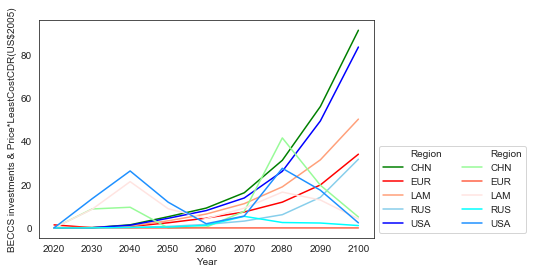

In [101]:
rego = ['LAM', 'USA', 'CHN', 'RUS', 'EUR']
scen='SSP1-19-SPA1-V17'
PriceXCDRperBillion=main_remind['PriceXTotalCDR'].astype(float)/1000000000
single_scen=main_remind[(main_remind.Scenario==scen) &
                        (main_remind.Region.isin(rego))].copy()
ax=sns.lineplot(x='Year',y=PriceXCDRperBillion ,data=single_scen, hue="Region", palette=['green','red','lightsalmon','skyblue','blue'], legend="full")
ax=sns.lineplot(x='Year',y='BECCS_Investments',data=single_scen, hue="Region", palette=['palegreen','tomato','mistyrose','aqua','dodgerblue'])
ax.set(xlabel='Year', ylabel='BECCS investments & Price*LeastCostCDR(US$2005)')
plt.legend(loc='lower left', bbox_to_anchor=(1,0),ncol=2)
plt.show()
#plt.savefig(plot_path + 'Annual_BECCS_vs_Price*LeastCostCDR.png', bbox_inches='tight')

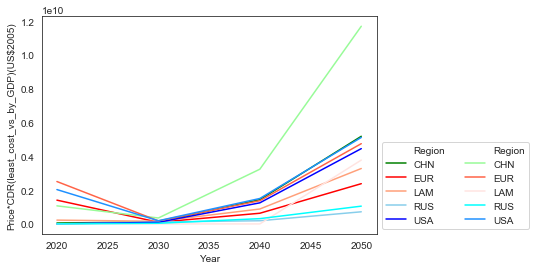

In [118]:
rego = ['LAM', 'USA', 'CHN', 'RUS', 'EUR']
scen='SSP1-19-SPA1-V17'
yr=['2020','2030','2040','2050']
single_scen=main_remind[(main_remind.Scenario==scen) &
                        (main_remind.Region.isin(rego)
                        )& (main_remind.Year.isin(yr))].copy()
ax=sns.lineplot(x='Year',y='PriceXTotalCDR',data=single_scen, hue="Region", palette=['green','red','lightsalmon','skyblue','blue'], legend="full")
ax=sns.lineplot(x='Year',y='CDR_fair_share_by_GDPXCarbonPrice',data=single_scen, hue="Region", palette=['palegreen','tomato','mistyrose','aqua','dodgerblue'])
ax.set(xlabel='Year', ylabel='Price*CDR(least_cost_vs_by_GDP)(US$2005)')
plt.legend(loc='lower left', bbox_to_anchor=(1,0),ncol=2)
#plt.show()
plt.savefig(plot_path + 'Price*LeastCostCDR_vs_Price*CDRbyGDP.png', bbox_inches='tight')

In [128]:
# Prepare data for boxplots

boxplot_df_allmodels = allmodels_df.melt(id_vars=['MODEL', 'Region', 'Scenario', 'Year'], value_vars=['Total_CO2', 'BECCS', 'LANDCDR',
       'TOTAL_CDR', 'CO2_Emissions', 'CUM_CO2', 'CUM_CDR', 'Unit_CO2',
       'Population', 'GDP', 'Unit_Population', 'cumPopulation', 'Unit_GDP',
       'GDP_cap', 'GDP_cap_avg', 'GDP_cap_CoI_nan', 'GDP_cap_CoI',
       'GDP_CoI_nan', 'GDP_CoI', 'GDP_CoI_frac', 'CDR_fair_share_by_GDP',
       'CUM_CDR_fair_share_by_GDP', 'Global_CUM_CO2_by_CUM_POP',
       'Fair_share_by_CUM_POP', 'Excess_emissions_by_CUM_POP',
       'Exc_em_fac_by_CUM_POP', 'CDR_fair_share_by_CUM_POP',
       'CUM_CDR_fair_share_by_CUM_POP', 'CDR_model_vs_fair_share_by_CUM_POP',
       'CDR_model_vs_fair_share_by_GDP',
       'CUM_CDR_model_vs_fair_share_by_CUM_POP',
       'CUM_CDR_model_vs_fair_share_by_GDP']).reset_index()
print(boxplot_df_allmodels)

       index   MODEL Region          Scenario    Year  \
0          0   IMAGE    BRA  SSP1-19-SPA0-V17  2020.0   
1          1   IMAGE    BRA  SSP1-19-SPA0-V17  2030.0   
2          2   IMAGE    BRA  SSP1-19-SPA0-V17  2040.0   
3          3   IMAGE    BRA  SSP1-19-SPA0-V17  2050.0   
4          4   IMAGE    BRA  SSP1-19-SPA0-V17  2060.0   
5          5   IMAGE    BRA  SSP1-19-SPA0-V17  2070.0   
6          6   IMAGE    BRA  SSP1-19-SPA0-V17  2080.0   
7          7   IMAGE    BRA  SSP1-19-SPA0-V17  2090.0   
8          8   IMAGE    BRA  SSP1-19-SPA0-V17  2100.0   
9          9   IMAGE    CAN  SSP1-19-SPA0-V17  2020.0   
10        10   IMAGE    CAN  SSP1-19-SPA0-V17  2030.0   
11        11   IMAGE    CAN  SSP1-19-SPA0-V17  2040.0   
12        12   IMAGE    CAN  SSP1-19-SPA0-V17  2050.0   
13        13   IMAGE    CAN  SSP1-19-SPA0-V17  2060.0   
14        14   IMAGE    CAN  SSP1-19-SPA0-V17  2070.0   
15        15   IMAGE    CAN  SSP1-19-SPA0-V17  2080.0   
16        16   IMAGE    CAN  SS

/Users/susannebaur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


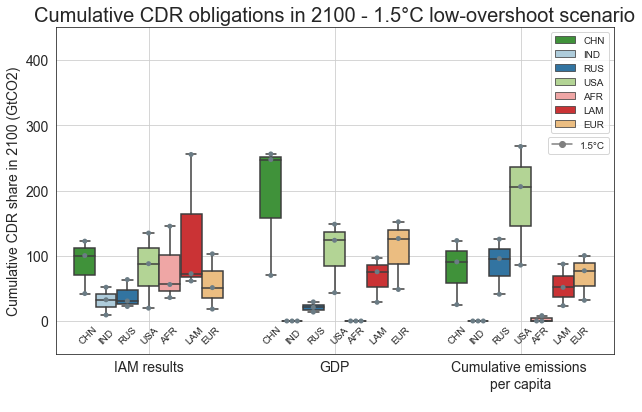

In [23]:
# Figure 2 - only low-overshoot 1.5-scenarios

scen_allmodels = ['SSP1-19-SPA0-V17', 'SSP1-Ref-SPA0-V17', 'SSP2-Ref-SPA0-V17',
 'SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17',
 'SSP1-26-SPA1-V17', 'SSP2-26-SPA2-V17', 'SSP5-19-SPA5-V17',
 'SSP5-26-SPA5-V17', 'LowEnergyDemand', 'SSP1-19']

scen_15_lo = ['SSP1-19-SPA0-V17', 'LowEnergyDemand', 'SSP1-19'] #only no / limited overshoot

scen_15_ho = ['SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17', 'SSP5-19-SPA5-V17'] # high overshoot

scen_2 = ['SSP2-26-SPA2-V17','SSP1-26-SPA1-V17', 'SSP5-26-SPA5-V17']



regions = ['USA', 'CHN', 'RUS', 'EUR', 'AFR', 'LAM', 'IND']
years = ['2100']
variab = ['CUM_CDR_fair_share_by_CUM_POP', 'CUM_CDR_fair_share_by_GDP', 'CUM_CDR']
boxp_2100 = boxplot_df_allmodels.loc[(boxplot_df_allmodels.Region.isin(regions)) &
                            (boxplot_df_allmodels.Scenario.isin(scen_15_lo)) &
                            (boxplot_df_allmodels.Year.isin(years)) &
                            (boxplot_df_allmodels.variable.isin(variab))]

boxp_2100['value'] = boxp_2100['value'].astype(float)/1000

boxp_15 = boxp_2100.loc[boxp_2100.Scenario.isin(scen_15_lo)]
#boxp_2 = boxp_2100.loc[boxp_2100.Scenario.isin(scen_2)]




sns.set_context(font_scale=1, rc={"axes.labelsize":12})

f, axes = plt.subplots(1, 1, figsize=(10,6))

colours = sns.color_palette("Paired",12)
colour_palette = [colours[3],colours[0],colours[1],colours[2],colours[4],colours[5], colours[6]]
#CHN 3 RUS 0, USA 1, AFR 2, LAM 4, EUR 5, IND 6
#AFR 9, CHN 1, EUR 2, IND 3, JPN 10, LAM 5, MEA 6, OAS 7, ROW 8, RUS 0, USA 4

box1 = sns.boxplot(x="variable", y="value", data=boxp_2100, hue = 'Region', hue_order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'], palette = colour_palette) # palette = 'Paired', palette = "coolwarm" or "husl", orient= 'horizontal'
box1.annotate('CHN', xy=(0.04, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('IND', xy=(0.075, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('RUS', xy=(0.11, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('USA', xy=(0.15, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('AFR', xy=(0.185, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('LAM', xy=(0.23, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('EUR', xy=(0.26, 0.03), xycoords='axes fraction', rotation=45)

box1.annotate('CHN', xy=(0.37, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('IND', xy=(0.41, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('RUS', xy=(0.45, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('USA', xy=(0.49, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('AFR', xy=(0.52, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('LAM', xy=(0.56, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('EUR', xy=(0.6, 0.03), xycoords='axes fraction', rotation=45)

box1.annotate('CHN', xy=(0.7, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('IND', xy=(0.74, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('RUS', xy=(0.78, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('USA', xy=(0.82, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('AFR', xy=(0.85, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('LAM', xy=(0.89, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('EUR', xy=(0.92, 0.03), xycoords='axes fraction', rotation=45)

colours_15 = ["battleship grey"]
pal_15 = sns.xkcd_palette(colours_15)
#colours_2 = ["light grey"]                  # color options https://xkcd.com/color/rgb/
#pal_2 = sns.xkcd_palette(colours_2)

box1 = sns.swarmplot(x="variable", y="value", data=boxp_15, hue = 'Region', hue_order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'], palette = pal_15, marker = 'o', facecolors='none', dodge = True)
#box1 = sns.swarmplot(x="variable", y="value", data=boxp_2, hue = 'Region', palette = pal_2, marker = '*', dodge = True)


box1.set_ylabel("Cumulative CDR share in 2100 (GtCO2)", fontsize = 14)
box1.set(xlabel = " ")
box1.set(ylim =(-50,450))
box1.set(xticklabels=['IAM results','GDP','Cumulative emissions \nper capita'])
box1.set_title("Cumulative CDR obligations in 2100 - 1.5°C low-overshoot scenario", fontsize=20)
box1.tick_params(labelsize=14)

handles, labels = box1.get_legend_handles_labels()
l = plt.legend(handles[0:7], labels[0:7])
l2 = plt.legend(handles=[Line2D([0], [0], marker = 'o', color="grey", label = '1.5°C')], loc = 'best', bbox_to_anchor =(1.0, 0.68))
plt.gca().add_artist(l)

box1.grid('on')
#plt.savefig(plot_path + 'Figure 2 - Boxplot2100 15 scenarios.svg', dpi = 300)
plt.savefig(plot_path + 'F - Figure 2 - Boxplot2100 15 lo.png')

/Users/susannebaur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


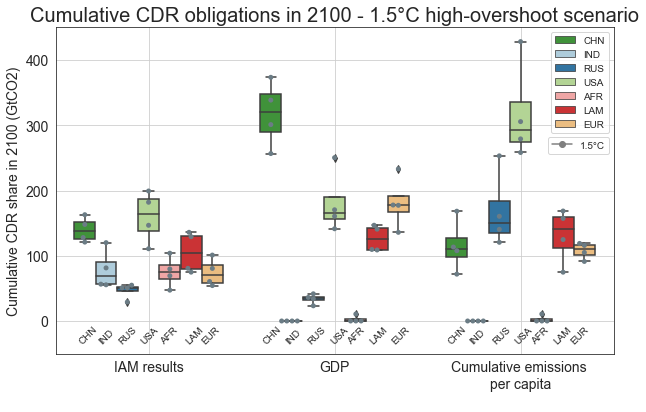

In [24]:
# Figure 2 - only high-overshoot 1.5-scenarios

scen_allmodels = ['SSP1-19-SPA0-V17', 'SSP1-Ref-SPA0-V17', 'SSP2-Ref-SPA0-V17',
 'SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17',
 'SSP1-26-SPA1-V17', 'SSP2-26-SPA2-V17', 'SSP5-19-SPA5-V17',
 'SSP5-26-SPA5-V17', 'LowEnergyDemand', 'SSP1-19']

scen_15_lo = ['SSP1-19-SPA0-V17', 'LowEnergyDemand', 'SSP1-19'] #only no / limited overshoot

scen_15_ho = ['SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17', 'SSP5-19-SPA5-V17'] # high overshoot

scen_2 = ['SSP2-26-SPA2-V17','SSP1-26-SPA1-V17', 'SSP5-26-SPA5-V17']


regions = ['USA', 'CHN', 'RUS', 'EUR', 'AFR', 'LAM', 'IND']
years = ['2100']
variab = ['CUM_CDR_fair_share_by_CUM_POP', 'CUM_CDR_fair_share_by_GDP', 'CUM_CDR']
boxp_2100 = boxplot_df_allmodels.loc[(boxplot_df_allmodels.Region.isin(regions)) &
                            (boxplot_df_allmodels.Scenario.isin(scen_15_ho)) &
                            (boxplot_df_allmodels.Year.isin(years)) &
                            (boxplot_df_allmodels.variable.isin(variab))]

boxp_2100['value'] = boxp_2100['value'].astype(float)/1000

boxp_15 = boxp_2100.loc[boxp_2100.Scenario.isin(scen_15_ho)]
#boxp_2 = boxp_2100.loc[boxp_2100.Scenario.isin(scen_2)]


sns.set_context(font_scale=1, rc={"axes.labelsize":12})

f, axes = plt.subplots(1, 1, figsize=(10,6))

colours = sns.color_palette("Paired",12)
colour_palette = [colours[3],colours[0],colours[1],colours[2],colours[4],colours[5], colours[6]]
#CHN 3 RUS 0, USA 1, AFR 2, LAM 4, EUR 5, IND 6
#AFR 9, CHN 1, EUR 2, IND 3, JPN 10, LAM 5, MEA 6, OAS 7, ROW 8, RUS 0, USA 4

box1 = sns.boxplot(x="variable", y="value", data=boxp_2100, hue = 'Region', hue_order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'], palette = colour_palette) # palette = 'Paired', palette = "coolwarm" or "husl", orient= 'horizontal'
box1.annotate('CHN', xy=(0.04, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('IND', xy=(0.075, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('RUS', xy=(0.11, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('USA', xy=(0.15, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('AFR', xy=(0.185, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('LAM', xy=(0.23, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('EUR', xy=(0.26, 0.03), xycoords='axes fraction', rotation=45)

box1.annotate('CHN', xy=(0.37, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('IND', xy=(0.41, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('RUS', xy=(0.45, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('USA', xy=(0.49, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('AFR', xy=(0.52, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('LAM', xy=(0.56, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('EUR', xy=(0.6, 0.03), xycoords='axes fraction', rotation=45)

box1.annotate('CHN', xy=(0.7, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('IND', xy=(0.74, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('RUS', xy=(0.78, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('USA', xy=(0.82, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('AFR', xy=(0.85, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('LAM', xy=(0.89, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('EUR', xy=(0.92, 0.03), xycoords='axes fraction', rotation=45)

colours_15 = ["battleship grey"]
pal_15 = sns.xkcd_palette(colours_15)
#colours_2 = ["light grey"]                  # color options https://xkcd.com/color/rgb/
#pal_2 = sns.xkcd_palette(colours_2)

box1 = sns.swarmplot(x="variable", y="value", data=boxp_15, hue = 'Region', hue_order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'], palette = pal_15, marker = 'o', facecolors='none', dodge = True)
#box1 = sns.swarmplot(x="variable", y="value", data=boxp_2, hue = 'Region', palette = pal_2, marker = '*', dodge = True)


box1.set_ylabel("Cumulative CDR share in 2100 (GtCO2)", fontsize = 14)
box1.set(xlabel = " ")
box1.set(ylim =(-50,450))
box1.set(xticklabels=['IAM results','GDP','Cumulative emissions \nper capita'])
box1.set_title("Cumulative CDR obligations in 2100 - 1.5°C high-overshoot scenario", fontsize=20)
box1.tick_params(labelsize=14)

handles, labels = box1.get_legend_handles_labels()
l = plt.legend(handles[0:7], labels[0:7])
l2 = plt.legend(handles=[Line2D([0], [0], marker = 'o', color="grey", label = '1.5°C')], loc = 'best', bbox_to_anchor =(1.0, 0.68))
plt.gca().add_artist(l)

box1.grid('on')
#plt.savefig(plot_path + 'Figure 2 - Boxplot2100 15 scenarios.svg', dpi = 300)
plt.savefig(plot_path + 'F - Figure 2 - Boxplot2100 15 ho.png')

In [39]:
print(allmodels_df.Region.unique())

['BRA' 'CAN' 'CEU' 'CHN' 'EAF' 'IND' 'INDO' 'JPN' 'KOR' 'ME' 'MEX' 'NAF'
 'OCE' 'RCAM' 'RSAF' 'RSAM' 'RSAS' 'RUS' 'SAF' 'SEAS' 'STAN' 'TUR' 'UKR'
 'USA' 'WAF' 'WEU' 'World' 'AFR' 'LAM' 'EUR' 'MEA' 'PAO' 'PAS' 'OAS' 'ROW']


In [129]:
box_df_all = pd.DataFrame()
box_df_all = allmodels_df[['Region', 'Scenario', 'Year', 'CUM_CDR_fair_share_by_CUM_POP', 'CUM_CDR_fair_share_by_GDP', 'CUM_CDR']]

regions = ['USA', 'CHN', 'RUS', 'EUR', 'AFR', 'LAM', 'IND']
years = ['2050', '2100']
scen_allmodels = ['SSP1-19-SPA0-V17', 
 'SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17',
 'SSP1-26-SPA1-V17', 'SSP2-26-SPA2-V17', 'SSP5-19-SPA5-V17',
 'SSP5-26-SPA5-V17', 'LowEnergyDemand', 'SSP1-19']

box_df_all = box_df_all.loc[(box_df_all['Region'].isin(regions)) & (box_df_all['Year'].isin(years)) 
                            & (box_df_all['Scenario'].isin(scen_allmodels))]

box_df_all = box_df_all.rename(columns={'CUM_CDR_fair_share_by_CUM_POP': 'CDR_per_cap_method', 'CUM_CDR_fair_share_by_GDP': 'CDR_GDP_method', 'CUM_CDR': 'IAM_output'})
box_df_all = box_df_all.reset_index(drop = True)

In [85]:
for reg in box_df_all.Region.unique():
    reg_filt = (box_df_all.Region == reg)
    for ye in box_df_all.Year.unique():
        ye_filt = (box_df_all.Year == ye)
        box_df_all.loc[reg_filt & ye_filt, 'median_cap'] = np.median(box_df_all.loc[reg_filt & ye_filt, 'CDR_per_cap_method'])
        
for reg in box_df_all.Region.unique():
    reg_filt = (box_df_all.Region == reg)
    for ye in box_df_all.Year.unique():
        ye_filt = (box_df_all.Year == ye)
        box_df_all.loc[reg_filt & ye_filt, 'median_GDP'] = np.median(box_df_all.loc[reg_filt & ye_filt, 'CDR_GDP_method'])
        
for reg in box_df_all.Region.unique():
    reg_filt = (box_df_all.Region == reg)
    for ye in box_df_all.Year.unique():
        ye_filt = (box_df_all.Year == ye)
        box_df_all.loc[reg_filt & ye_filt, 'median_IAM'] = np.median(box_df_all.loc[reg_filt & ye_filt, 'IAM_output'])

In [86]:
print(box_df_all)

    Region          Scenario    Year  CDR_per_cap_method  CDR_GDP_method  \
0      CHN  SSP1-19-SPA0-V17  2050.0            11554.69        52513.86   
1      CHN  SSP1-19-SPA0-V17  2100.0            90614.56       256088.32   
2      IND  SSP1-19-SPA0-V17  2050.0                0.00            0.00   
3      IND  SSP1-19-SPA0-V17  2100.0                0.00            0.00   
4      RUS  SSP1-19-SPA0-V17  2050.0            15808.68         4602.77   
5      RUS  SSP1-19-SPA0-V17  2100.0            95578.61        20930.99   
6      USA  SSP1-19-SPA0-V17  2050.0            39848.56        21519.13   
7      USA  SSP1-19-SPA0-V17  2100.0           205987.24       123752.08   
8      CHN  SSP2-LF-SPA2-V17  2050.0            27058.20        70128.18   
9      CHN  SSP2-LF-SPA2-V17  2100.0           168306.24       338614.71   
10     IND  SSP2-LF-SPA2-V17  2050.0                0.00            0.00   
11     IND  SSP2-LF-SPA2-V17  2100.0                0.00            0.00   
12     RUS  

In [87]:
china = box_df_all.loc[(box_df_all.Region == 'CHN') & (box_df_all.Year == 2050), 'CDR_per_cap_method']
print(np.median(china))

usa = box_df_all.loc[(box_df_all.Region == 'USA') & (box_df_all.Year == 2050), 'CDR_per_cap_method']
print(np.median(usa))

russia = box_df_all.loc[(box_df_all.Region == 'RUS') & (box_df_all.Year == 2050), 'CDR_per_cap_method']
print(np.median(russia))

africa = box_df_all.loc[(box_df_all.Region == 'AFR') & (box_df_all.Year == 2050), 'CDR_per_cap_method']
print(np.median(africa))

3760.48
41659.2
16001.16
0.0


In [90]:
box_table = box_df_all[['Region', 'Scenario', 'Year', 'median_cap', 'median_GDP', 'median_IAM']]
box_table_all = box_table.copy()

In [91]:
print(box_table_all)

    Region          Scenario    Year  median_cap  median_GDP  median_IAM
0      CHN  SSP1-19-SPA0-V17  2050.0    3760.480   45606.910   19698.485
1      CHN  SSP1-19-SPA0-V17  2100.0   89771.765  256379.525  121662.080
2      IND  SSP1-19-SPA0-V17  2050.0       0.000       0.000    8085.655
3      IND  SSP1-19-SPA0-V17  2100.0       0.000       0.000   53603.475
4      RUS  SSP1-19-SPA0-V17  2050.0   16001.160    4246.015    4582.810
5      RUS  SSP1-19-SPA0-V17  2100.0  123045.910   26330.020   33372.670
6      USA  SSP1-19-SPA0-V17  2050.0   41659.200   20262.185   15249.900
7      USA  SSP1-19-SPA0-V17  2100.0  262892.820  144878.495  122783.015
8      CHN  SSP2-LF-SPA2-V17  2050.0    3760.480   45606.910   19698.485
9      CHN  SSP2-LF-SPA2-V17  2100.0   89771.765  256379.525  121662.080
10     IND  SSP2-LF-SPA2-V17  2050.0       0.000       0.000    8085.655
11     IND  SSP2-LF-SPA2-V17  2100.0       0.000       0.000   53603.475
12     RUS  SSP2-LF-SPA2-V17  2050.0   16001.160   

/Users/susannebaur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


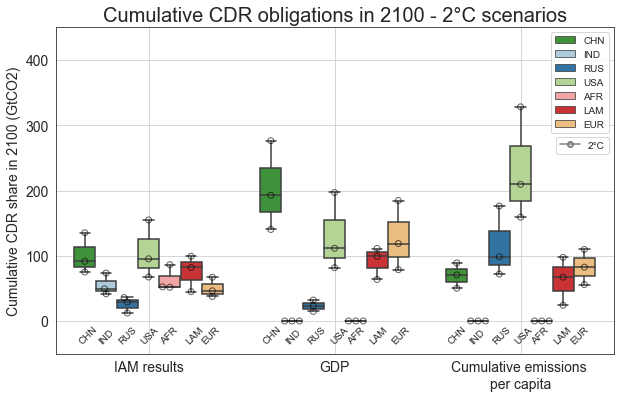

In [467]:
# Figure 2 - only 2-scenarios

scen_allmodels = ['SSP1-19-SPA0-V17', 'SSP1-Ref-SPA0-V17', 'SSP2-Ref-SPA0-V17',
 'SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17',
 'SSP1-26-SPA1-V17', 'SSP2-26-SPA2-V17', 'SSP5-19-SPA5-V17',
 'SSP5-26-SPA5-V17', 'LowEnergyDemand', 'SSP1-19']

scen_15_lo = ['SSP1-19-SPA0-V17', 'LowEnergyDemand', 'SSP1-19'] #only no / limited overshoot

scen_15_ho = ['SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17', 'SSP5-19-SPA5-V17'] # high overshoot

scen_2 = ['SSP2-26-SPA2-V17','SSP1-26-SPA1-V17', 'SSP5-26-SPA5-V17']


regions = ['USA', 'CHN', 'RUS', 'EUR', 'AFR', 'LAM', 'IND']
years = ['2100']
variab = ['CUM_CDR_fair_share_by_CUM_POP', 'CUM_CDR_fair_share_by_GDP', 'CUM_CDR']
boxp_2100 = boxplot_df_allmodels.loc[(boxplot_df_allmodels.Region.isin(regions)) &
                            (boxplot_df_allmodels.Scenario.isin(scen_2)) &
                            (boxplot_df_allmodels.Year.isin(years)) &
                            (boxplot_df_allmodels.variable.isin(variab))]

boxp_2100['value'] = boxp_2100['value'].astype(float)/1000

#boxp_15 = boxp_2100.loc[boxp_2100.Scenario.isin(scen_15)]
boxp_2 = boxp_2100.loc[boxp_2100.Scenario.isin(scen_2)]




sns.set_context(font_scale=1, rc={"axes.labelsize":12})

f, axes = plt.subplots(1, 1, figsize=(10,6))

colours = sns.color_palette("Paired",12)
colour_palette = [colours[3],colours[0],colours[1],colours[2],colours[4],colours[5], colours[6]]
#CHN 3 RUS 0, USA 1, AFR 2, LAM 4, EUR 5, IND 6
#AFR 9, CHN 1, EUR 2, IND 3, JPN 10, LAM 5, MEA 6, OAS 7, ROW 8, RUS 0, USA 4

box1 = sns.boxplot(x="variable", y="value", data=boxp_2100, hue = 'Region',hue_order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'], 
                   palette = colour_palette) # palette = 'Paired', palette = "coolwarm" or "husl", orient= 'horizontal'
box1.annotate('CHN', xy=(0.04, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('IND', xy=(0.075, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('RUS', xy=(0.11, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('USA', xy=(0.15, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('AFR', xy=(0.185, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('LAM', xy=(0.23, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('EUR', xy=(0.26, 0.03), xycoords='axes fraction', rotation=45)

box1.annotate('CHN', xy=(0.37, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('IND', xy=(0.41, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('RUS', xy=(0.45, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('USA', xy=(0.49, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('AFR', xy=(0.52, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('LAM', xy=(0.56, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('EUR', xy=(0.6, 0.03), xycoords='axes fraction', rotation=45)

box1.annotate('CHN', xy=(0.7, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('IND', xy=(0.74, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('RUS', xy=(0.78, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('USA', xy=(0.82, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('AFR', xy=(0.85, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('LAM', xy=(0.89, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('EUR', xy=(0.92, 0.03), xycoords='axes fraction', rotation=45)

#colours_15 = ["battleship grey"]
#pal_15 = sns.xkcd_palette(colours_15)
colours_2 = ["black"]                  # color options https://xkcd.com/color/rgb/
pal_2 = sns.xkcd_palette(colours_2)

#box1 = sns.swarmplot(x="variable", y="value", data=boxp_15, hue = 'Region', palette = pal_15, marker = 'o', dodge = True)
box1 = sns.swarmplot(x="variable", y="value", data=boxp_2, hue = 'Region',hue_order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'], 
                     palette = pal_2, marker = open_circle, dodge = True, s= 7, alpha =0.6)

pts = np.linspace(0, np.pi * 2, 24)
circ = np.c_[np.sin(pts) / 2, -np.cos(pts) / 2]
vert = np.r_[circ, circ[::-1] * .7]
open_circle = mpl.path.Path(vert)


box1.set_ylabel("Cumulative CDR share in 2100 (GtCO2)", fontsize = 14)
box1.set(xlabel = " ")
box1.set(ylim =(-50,450))
box1.set(xticklabels=['IAM results','GDP','Cumulative emissions \nper capita'])
box1.set_title("Cumulative CDR obligations in 2100 - 2°C scenarios", fontsize=20)
box1.tick_params(labelsize=14)

handles, labels = box1.get_legend_handles_labels()
l = plt.legend(handles[0:7], labels[0:7])
l2 = plt.legend(handles=[Line2D([0], [0], marker = open_circle, color="grey", label = '2°C')], loc = 'best', bbox_to_anchor =(1.0, 0.68))
plt.gca().add_artist(l)

box1.grid('on')
#plt.savefig(plot_path + 'Figure 2 - Boxplot2100 2 scenarios.svg', dpi = 300)
plt.savefig(plot_path + 'F - Figure 2 - Boxplot2100 2 scen.png')

/Users/susannebaur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


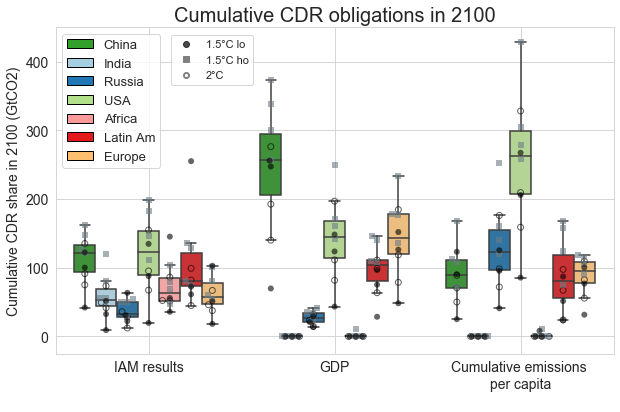

In [231]:
# FIGURE 2 - Boxplot - all models 1.5ho and 1.5lo seperate

scen_allmodels = ['SSP1-19-SPA0-V17', 
 'SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17',
 'SSP1-26-SPA1-V17', 'SSP2-26-SPA2-V17', 'SSP5-19-SPA5-V17',
 'SSP5-26-SPA5-V17', 'LowEnergyDemand', 'SSP1-19']

scen_15_lo = ['SSP1-19-SPA0-V17', 'LowEnergyDemand', 'SSP1-19'] #only no / limited overshoot

scen_15_ho = ['SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17', 'SSP5-19-SPA5-V17'] # high overshoot

scen_2 = ['SSP2-26-SPA2-V17','SSP1-26-SPA1-V17', 'SSP5-26-SPA5-V17']

scen_15 = ['SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17', 'SSP5-19-SPA5-V17', 'SSP1-19-SPA0-V17', 'LowEnergyDemand', 'SSP1-19']



regions = ['USA', 'CHN', 'RUS', 'EUR', 'AFR', 'LAM', 'IND']
years = ['2100']
variab = ['CUM_CDR_fair_share_by_CUM_POP', 'CUM_CDR_fair_share_by_GDP', 'CUM_CDR']
boxp_2100 = boxplot_df_allmodels.loc[(boxplot_df_allmodels.Region.isin(regions)) &
                            (boxplot_df_allmodels.Scenario.isin(scen_allmodels)) &
                            (boxplot_df_allmodels.Year.isin(years)) &
                            (boxplot_df_allmodels.variable.isin(variab))]

boxp_2100['value'] = boxp_2100['value'].astype(float)/1000

boxp_15 = boxp_2100.loc[boxp_2100.Scenario.isin(scen_15)]
boxp_2 = boxp_2100.loc[boxp_2100.Scenario.isin(scen_2)]
boxp_15_lo = boxp_2100.loc[boxp_2100.Scenario.isin(scen_15_lo)]
boxp_15_ho = boxp_2100.loc[boxp_2100.Scenario.isin(scen_15_ho)]



sns.set_context(font_scale=1, rc={"axes.labelsize":12})

f, axes = plt.subplots(1, 1, figsize=(10,6))

colours = sns.color_palette("Paired",12)
colour_palette = [colours[3],colours[0],colours[1],colours[2],colours[4],colours[5], colours[6]]
#CHN 3 RUS 0, USA 1, AFR 2, LAM 4, EUR 5, IND 6
#AFR 9, CHN 1, EUR 2, IND 3, JPN 10, LAM 5, MEA 6, OAS 7, ROW 8, RUS 0, USA 4

box1 = sns.boxplot(x="variable", y="value", data=boxp_2100, hue = 'Region', 
                   hue_order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'], palette = colour_palette,
                  showfliers=False) # palette = 'Paired', palette = "coolwarm" or "husl", orient= 'horizontal'
#box1.annotate('CHN', xy=(0.039, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('IND', xy=(0.075, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('RUS', xy=(0.11, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('USA', xy=(0.15, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('AFR', xy=(0.185, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('LAM', xy=(0.22, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('EUR', xy=(0.26, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)

#box1.annotate('CHN', xy=(0.37, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('IND', xy=(0.41, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('RUS', xy=(0.447, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('USA', xy=(0.48, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('AFR', xy=(0.52, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('LAM', xy=(0.555, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('EUR', xy=(0.6, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)

#box1.annotate('CHN', xy=(0.7, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('IND', xy=(0.74, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('RUS', xy=(0.78, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('USA', xy=(0.818, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('AFR', xy=(0.855, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('LAM', xy=(0.89, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('EUR', xy=(0.92, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)

colours_15 = ["black"]
pal_15 = sns.xkcd_palette(colours_15)
colours_2 = ["battleship grey"]                  # color options https://xkcd.com/color/rgb/
pal_2 = sns.xkcd_palette(colours_2)
colours_15_lo = ["black"]
pal_15_lo = sns.xkcd_palette(colours_15_lo)
colours_15_ho = ["battleship grey"]
pal_15_ho = sns.xkcd_palette(colours_15_ho)

pts = np.linspace(0, np.pi * 2, 24)
circ = np.c_[np.sin(pts) / 2, -np.cos(pts) / 2]
vert = np.r_[circ, circ[::-1] * .7]
open_circle = mpl.path.Path(vert)

box1 = sns.swarmplot(x="variable", y="value", data=boxp_2, hue = 'Region', 
                     hue_order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'], palette= pal_15, marker = open_circle, dodge = True, s=7, alpha=0.6)
box1 = sns.swarmplot(x="variable", y="value", data=boxp_15_ho, hue = 'Region', 
                     hue_order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'], palette = pal_15_ho, marker = 's', dodge = True, s=6, alpha=0.6)
box1 = sns.swarmplot(x="variable", y="value", data=boxp_15_lo, hue = 'Region', 
                     hue_order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'], palette = pal_15_lo, marker = 'o', dodge = True, s=6, alpha =0.6)
#marker maybe 's' '*' 'P'

box1.set_ylabel("Cumulative CDR share in 2100 (GtCO2)", fontsize = 14)
box1.set(xlabel = " ")
box1.set(ylim =(-25,450))
box1.set(xticklabels=['IAM results','GDP','Cumulative emissions \nper capita'])
box1.set_title("Cumulative CDR obligations in 2100", fontsize=20)
box1.tick_params(labelsize=14)

colour_palette = [colours[3],colours[0],colours[1],colours[2],colours[4],colours[5], colours[6]]
#CHN 3 RUS 0, USA 1, AFR 2, LAM 4, EUR 5, IND 6
from matplotlib.patches import Patch
#handles, labels = box1.get_legend_handles_labels()
l = plt.legend(handles =  [Patch(facecolor=colours[3], edgecolor='k', label='China'), 
                           Patch(facecolor=colours[0], edgecolor='k', label='India'),
                           Patch(facecolor=colours[1], edgecolor='k', label='Russia'),
                           Patch(facecolor=colours[2], edgecolor='k', label='USA'),
                           Patch(facecolor=colours[4], edgecolor='k', label='Africa'),
                           Patch(facecolor=colours[5], edgecolor='k', label='Latin Am'),
                           Patch(facecolor=colours[6], edgecolor='k', label='Europe')], fontsize = 13)
l2 = plt.legend(handles=[Line2D([0], [0], linestyle = 'none', marker = 'o', color="black", label = '1.5°C lo', alpha=0.7),
                         Line2D([0], [0], linestyle = 'none', marker = 's', color="grey", label = '1.5°C ho'),
                Line2D([0], [0], linestyle = 'none', marker = open_circle, color="grey", label = '2°C')],
                loc = 'center', bbox_to_anchor =(0.28, 0.9), fontsize = 11)    # 0.155, 0.68 <- for left side
plt.gca().add_artist(l)

box1.grid('on')
#plt.savefig(plot_path + 'Figure 2 - Boxplot2100 holo.svg', dpi = 300)
plt.savefig(plot_path + 'F - Figure 2 - Boxplot2100 holo.png')

/Users/susannebaur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


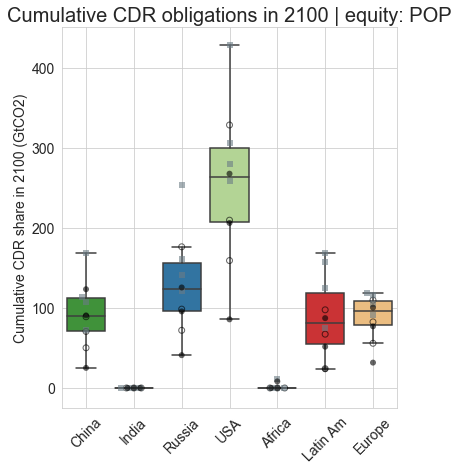

In [242]:
scen_allmodels = ['SSP1-19-SPA0-V17', 
 'SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17',
 'SSP1-26-SPA1-V17', 'SSP2-26-SPA2-V17', 'SSP5-19-SPA5-V17',
 'SSP5-26-SPA5-V17', 'LowEnergyDemand', 'SSP1-19']

scen_15_lo = ['SSP1-19-SPA0-V17', 'LowEnergyDemand', 'SSP1-19'] #only no / limited overshoot

scen_15_ho = ['SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17', 'SSP5-19-SPA5-V17'] # high overshoot

scen_2 = ['SSP2-26-SPA2-V17','SSP1-26-SPA1-V17', 'SSP5-26-SPA5-V17']

scen_15 = ['SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17', 'SSP5-19-SPA5-V17', 'SSP1-19-SPA0-V17', 'LowEnergyDemand', 'SSP1-19']


regions = ['USA', 'CHN', 'RUS', 'EUR', 'AFR', 'LAM', 'IND']
years = ['2100']
variab = ['CUM_CDR_fair_share_by_CUM_POP']   #, 'CUM_CDR_fair_share_by_GDP', 'CUM_CDR'
boxp_2100 = boxplot_df_allmodels.loc[(boxplot_df_allmodels.Region.isin(regions)) &
                            (boxplot_df_allmodels.Scenario.isin(scen_allmodels)) &
                            (boxplot_df_allmodels.Year.isin(years)) &
                            (boxplot_df_allmodels.variable.isin(variab))]

boxp_2100['value'] = boxp_2100['value'].astype(float)/1000

boxp_15 = boxp_2100.loc[boxp_2100.Scenario.isin(scen_15)]
boxp_2 = boxp_2100.loc[boxp_2100.Scenario.isin(scen_2)]
boxp_15_lo = boxp_2100.loc[boxp_2100.Scenario.isin(scen_15_lo)]
boxp_15_ho = boxp_2100.loc[boxp_2100.Scenario.isin(scen_15_ho)]


sns.set_context(font_scale=1, rc={"axes.labelsize":12})

f, axes = plt.subplots(1, 1, figsize=(6,7))

colours = sns.color_palette("Paired",12)
colour_palette = [colours[3],colours[0],colours[1],colours[2],colours[4],colours[5], colours[6]]
#CHN 3 RUS 0, USA 1, AFR 2, LAM 4, EUR 5, IND 6
#AFR 9, CHN 1, EUR 2, IND 3, JPN 10, LAM 5, MEA 6, OAS 7, ROW 8, RUS 0, USA 4

box1 = sns.boxplot(x='Region', y="value", data=boxp_2100, palette = colour_palette, order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'],
                  showfliers=False) # palette = 'Paired', palette = "coolwarm" or "husl", orient= 'horizontal'


colours_15 = ["black"]
pal_15 = sns.xkcd_palette(colours_15)
colours_2 = ["battleship grey"]                  # color options https://xkcd.com/color/rgb/
pal_2 = sns.xkcd_palette(colours_2)
colours_15_lo = ["black"]
pal_15_lo = sns.xkcd_palette(colours_15_lo)
colours_15_ho = ["battleship grey"]
pal_15_ho = sns.xkcd_palette(colours_15_ho)

pts = np.linspace(0, np.pi * 2, 24)
circ = np.c_[np.sin(pts) / 2, -np.cos(pts) / 2]
vert = np.r_[circ, circ[::-1] * .7]
open_circle = mpl.path.Path(vert)

#hue_order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'],
box1 = sns.swarmplot(x='Region', y="value", data=boxp_2, order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'], palette= pal_15, marker = open_circle, dodge = True, s=7, alpha=0.6)
box1 = sns.swarmplot(x='Region', y="value", data=boxp_15_ho,order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'], palette = pal_15_ho, marker = 's', dodge = True, s=6, alpha=0.6)
box1 = sns.swarmplot(x='Region', y="value", data=boxp_15_lo, order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'],palette = pal_15_lo, marker = 'o', dodge = True, s=6, alpha =0.6)


box1.set_ylabel("Cumulative CDR share in 2100 (GtCO2)", fontsize = 14)
box1.set_xlabel('')
box1.set(ylim =(-25,450))
box1.set_xticklabels(['China', 'India', 'Russia', 'USA', 'Africa', 'Latin Am', 'Europe'], rotation = 45)
box1.set_title("Cumulative CDR obligations in 2100 | equity: POP", fontsize=20)
box1.tick_params(labelsize=14)

colour_palette = [colours[3],colours[0],colours[1],colours[2],colours[4],colours[5], colours[6]]
#CHN 3 RUS 0, USA 1, AFR 2, LAM 4, EUR 5, IND 6


box1.grid('on')
#plt.savefig(plot_path + 'Figure 2 - Boxplot2100 holo.svg', dpi = 300)
plt.savefig(plot_path + 'F - Figure 2 - Boxplot2100 POP.png')

/Users/susannebaur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


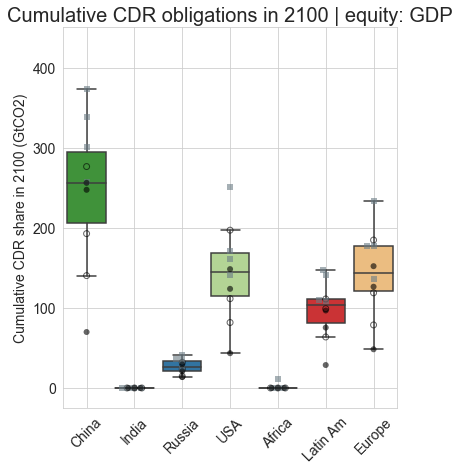

In [243]:
scen_allmodels = ['SSP1-19-SPA0-V17', 
 'SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17',
 'SSP1-26-SPA1-V17', 'SSP2-26-SPA2-V17', 'SSP5-19-SPA5-V17',
 'SSP5-26-SPA5-V17', 'LowEnergyDemand', 'SSP1-19']

scen_15_lo = ['SSP1-19-SPA0-V17', 'LowEnergyDemand', 'SSP1-19'] #only no / limited overshoot

scen_15_ho = ['SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17', 'SSP5-19-SPA5-V17'] # high overshoot

scen_2 = ['SSP2-26-SPA2-V17','SSP1-26-SPA1-V17', 'SSP5-26-SPA5-V17']

scen_15 = ['SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17', 'SSP5-19-SPA5-V17', 'SSP1-19-SPA0-V17', 'LowEnergyDemand', 'SSP1-19']


regions = ['USA', 'CHN', 'RUS', 'EUR', 'AFR', 'LAM', 'IND']
years = ['2100']
variab = ['CUM_CDR_fair_share_by_GDP']   # 'CUM_CDR'
boxp_2100 = boxplot_df_allmodels.loc[(boxplot_df_allmodels.Region.isin(regions)) &
                            (boxplot_df_allmodels.Scenario.isin(scen_allmodels)) &
                            (boxplot_df_allmodels.Year.isin(years)) &
                            (boxplot_df_allmodels.variable.isin(variab))]

boxp_2100['value'] = boxp_2100['value'].astype(float)/1000

boxp_15 = boxp_2100.loc[boxp_2100.Scenario.isin(scen_15)]
boxp_2 = boxp_2100.loc[boxp_2100.Scenario.isin(scen_2)]
boxp_15_lo = boxp_2100.loc[boxp_2100.Scenario.isin(scen_15_lo)]
boxp_15_ho = boxp_2100.loc[boxp_2100.Scenario.isin(scen_15_ho)]


sns.set_context(font_scale=1, rc={"axes.labelsize":12})

f, axes = plt.subplots(1, 1, figsize=(6,7))

colours = sns.color_palette("Paired",12)
colour_palette = [colours[3],colours[0],colours[1],colours[2],colours[4],colours[5], colours[6]]
#CHN 3 RUS 0, USA 1, AFR 2, LAM 4, EUR 5, IND 6
#AFR 9, CHN 1, EUR 2, IND 3, JPN 10, LAM 5, MEA 6, OAS 7, ROW 8, RUS 0, USA 4

box1 = sns.boxplot(x='Region', y="value",order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'], data=boxp_2100, palette = colour_palette,
                  showfliers=False) # palette = 'Paired', palette = "coolwarm" or "husl", orient= 'horizontal'

colours_15 = ["black"]
pal_15 = sns.xkcd_palette(colours_15)
colours_2 = ["battleship grey"]                  # color options https://xkcd.com/color/rgb/
pal_2 = sns.xkcd_palette(colours_2)
colours_15_lo = ["black"]
pal_15_lo = sns.xkcd_palette(colours_15_lo)
colours_15_ho = ["battleship grey"]
pal_15_ho = sns.xkcd_palette(colours_15_ho)

pts = np.linspace(0, np.pi * 2, 24)
circ = np.c_[np.sin(pts) / 2, -np.cos(pts) / 2]
vert = np.r_[circ, circ[::-1] * .7]
open_circle = mpl.path.Path(vert)

box1 = sns.swarmplot(x='Region', y="value", data=boxp_2, order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'],palette= pal_15, marker = open_circle, dodge = True, s=7, alpha=0.6)
box1 = sns.swarmplot(x='Region', y="value", data=boxp_15_ho, order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'],palette = pal_15_ho, marker = 's', dodge = True, s=6, alpha=0.6)
box1 = sns.swarmplot(x='Region', y="value", data=boxp_15_lo,order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'], palette = pal_15_lo, marker = 'o', dodge = True, s=6, alpha =0.6)


box1.set_ylabel("Cumulative CDR share in 2100 (GtCO2)", fontsize = 14)
box1.set_xlabel('')
box1.set(ylim =(-25,450))
box1.set_xticklabels(['China', 'India', 'Russia', 'USA', 'Africa', 'Latin Am', 'Europe'], rotation = 45)
box1.set_title("Cumulative CDR obligations in 2100 | equity: GDP", fontsize=20)
box1.tick_params(labelsize=14)

colour_palette = [colours[3],colours[0],colours[1],colours[2],colours[4],colours[5], colours[6]]
#CHN 3 RUS 0, USA 1, AFR 2, LAM 4, EUR 5, IND 6


box1.grid('on')
#plt.savefig(plot_path + 'Figure 2 - Boxplot2100 holo.svg', dpi = 300)
plt.savefig(plot_path + 'F - Figure 2 - Boxplot2100 GDP.png')

/Users/susannebaur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


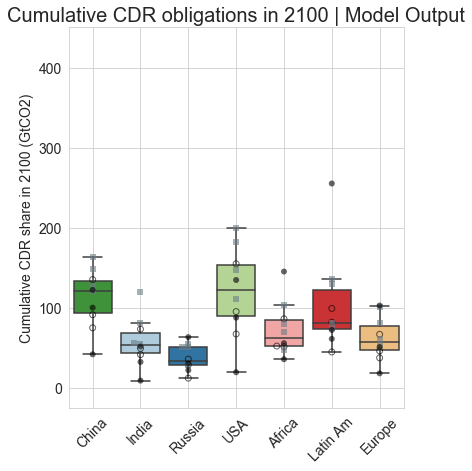

In [244]:
scen_allmodels = ['SSP1-19-SPA0-V17', 
 'SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17',
 'SSP1-26-SPA1-V17', 'SSP2-26-SPA2-V17', 'SSP5-19-SPA5-V17',
 'SSP5-26-SPA5-V17', 'LowEnergyDemand', 'SSP1-19']

scen_15_lo = ['SSP1-19-SPA0-V17', 'LowEnergyDemand', 'SSP1-19'] #only no / limited overshoot

scen_15_ho = ['SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17', 'SSP5-19-SPA5-V17'] # high overshoot

scen_2 = ['SSP2-26-SPA2-V17','SSP1-26-SPA1-V17', 'SSP5-26-SPA5-V17']

scen_15 = ['SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17', 'SSP5-19-SPA5-V17', 'SSP1-19-SPA0-V17', 'LowEnergyDemand', 'SSP1-19']


regions = ['USA', 'CHN', 'RUS', 'EUR', 'AFR', 'LAM', 'IND']
years = ['2100']
variab = ['CUM_CDR']   
boxp_2100 = boxplot_df_allmodels.loc[(boxplot_df_allmodels.Region.isin(regions)) &
                            (boxplot_df_allmodels.Scenario.isin(scen_allmodels)) &
                            (boxplot_df_allmodels.Year.isin(years)) &
                            (boxplot_df_allmodels.variable.isin(variab))]

boxp_2100['value'] = boxp_2100['value'].astype(float)/1000

boxp_15 = boxp_2100.loc[boxp_2100.Scenario.isin(scen_15)]
boxp_2 = boxp_2100.loc[boxp_2100.Scenario.isin(scen_2)]
boxp_15_lo = boxp_2100.loc[boxp_2100.Scenario.isin(scen_15_lo)]
boxp_15_ho = boxp_2100.loc[boxp_2100.Scenario.isin(scen_15_ho)]


sns.set_context(font_scale=1, rc={"axes.labelsize":12})

f, axes = plt.subplots(1, 1, figsize=(6,7))

colours = sns.color_palette("Paired",12)
colour_palette = [colours[3],colours[0],colours[1],colours[2],colours[4],colours[5], colours[6]]
#CHN 3 RUS 0, USA 1, AFR 2, LAM 4, EUR 5, IND 6
#AFR 9, CHN 1, EUR 2, IND 3, JPN 10, LAM 5, MEA 6, OAS 7, ROW 8, RUS 0, USA 4

box1 = sns.boxplot(x='Region', y="value", data=boxp_2100, order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'],palette = colour_palette,
                  showfliers=False) # palette = 'Paired', palette = "coolwarm" or "husl", orient= 'horizontal'


colours_15 = ["black"]
pal_15 = sns.xkcd_palette(colours_15)
colours_2 = ["battleship grey"]                  # color options https://xkcd.com/color/rgb/
pal_2 = sns.xkcd_palette(colours_2)
colours_15_lo = ["black"]
pal_15_lo = sns.xkcd_palette(colours_15_lo)
colours_15_ho = ["battleship grey"]
pal_15_ho = sns.xkcd_palette(colours_15_ho)

pts = np.linspace(0, np.pi * 2, 24)
circ = np.c_[np.sin(pts) / 2, -np.cos(pts) / 2]
vert = np.r_[circ, circ[::-1] * .7]
open_circle = mpl.path.Path(vert)

box1 = sns.swarmplot(x='Region', y="value", data=boxp_2, order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'],palette= pal_15, marker = open_circle, dodge = True, s=7, alpha=0.6)
box1 = sns.swarmplot(x='Region', y="value", data=boxp_15_ho, order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'],palette = pal_15_ho, marker = 's', dodge = True, s=6, alpha=0.6)
box1 = sns.swarmplot(x='Region', y="value", data=boxp_15_lo, order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'],palette = pal_15_lo, marker = 'o', dodge = True, s=6, alpha =0.6)
#marker maybe 's' '*' 'P'

box1.set_ylabel("Cumulative CDR share in 2100 (GtCO2)", fontsize = 14)
box1.set_xlabel('')
box1.set(ylim =(-25,450))
box1.set_xticklabels(['China', 'India', 'Russia', 'USA', 'Africa', 'Latin Am', 'Europe'], rotation = 45)
box1.set_title("Cumulative CDR obligations in 2100 | Model Output", fontsize=20)
box1.tick_params(labelsize=14)

colour_palette = [colours[3],colours[0],colours[1],colours[2],colours[4],colours[5], colours[6]]
#CHN 3 RUS 0, USA 1, AFR 2, LAM 4, EUR 5, IND 6



box1.grid('on')
#plt.savefig(plot_path + 'Figure 2 - Boxplot2100 holo.svg', dpi = 300)
plt.savefig(plot_path + 'F - Figure 2 - Boxplot2100 IAM.png')

/Users/susannebaur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


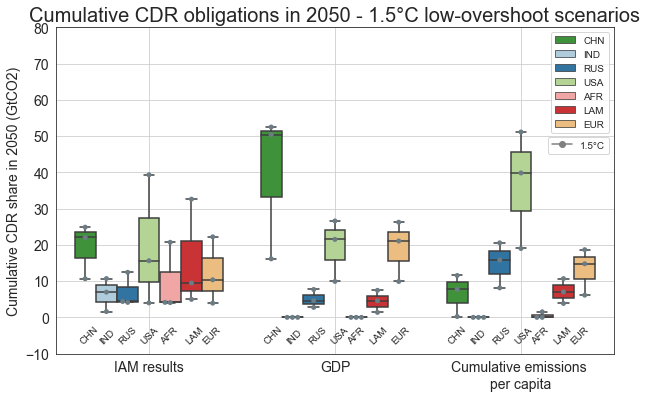

In [452]:
# FIGURE 2 - Boxplot - all models - only 1.5 low overshoot
scen_allmodels = ['SSP1-19-SPA0-V17', 'SSP1-Ref-SPA0-V17', 'SSP2-Ref-SPA0-V17',
 'SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17',
 'SSP1-26-SPA1-V17', 'SSP2-26-SPA2-V17', 'SSP5-19-SPA5-V17',
 'SSP5-26-SPA5-V17', 'SSP1-19', 'LowEnergyDemand']

scen_15_lo = ['SSP1-19-SPA0-V17', 'LowEnergyDemand', 'SSP1-19'] #only no / limited overshoot

scen_15_ho = ['SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17', 'SSP5-19-SPA5-V17'] # high overshoot

scen_2 = ['SSP2-26-SPA2-V17','SSP1-26-SPA1-V17', 'SSP5-26-SPA5-V17']

scen_15 = ['SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17', 'SSP5-19-SPA5-V17', 'SSP1-19-SPA0-V17', 'LowEnergyDemand', 'SSP1-19']




regions = ['USA', 'CHN', 'RUS', 'EUR', 'AFR', 'LAM', 'IND']
years = ['2050']
variab = ['CUM_CDR_fair_share_by_CUM_POP', 'CUM_CDR_fair_share_by_GDP', 'CUM_CDR']
boxp_2050 = boxplot_df_allmodels.loc[(boxplot_df_allmodels.Region.isin(regions)) &
                            (boxplot_df_allmodels.Scenario.isin(scen_15_lo)) &
                            (boxplot_df_allmodels.Year.isin(years)) &
                            (boxplot_df_allmodels.variable.isin(variab))]

boxp_2050['value'] = boxp_2050['value'].astype(float)/1000


boxp_15 = boxp_2050.loc[boxp_2050.Scenario.isin(scen_15_lo)]
#boxp_2 = boxp_2050.loc[boxp_2050.Scenario.isin(scen_2)]


colours = sns.color_palette("Paired",12)
colour_palette = [colours[3],colours[0],colours[1],colours[2],colours[4],colours[5], colours[6]]

sns.set_context(font_scale=1, rc={"axes.labelsize":12})

f, axes = plt.subplots(1, 1, figsize=(10,6))

box1 = sns.boxplot(x="variable", y="value", data=boxp_2050, hue = 'Region', hue_order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'],
                   palette = colour_palette) # palette = "coolwarm" or "husl", orient= 'horizontal'
box1.annotate('CHN', xy=(0.04, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('IND', xy=(0.075, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('RUS', xy=(0.11, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('USA', xy=(0.15, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('AFR', xy=(0.185, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('LAM', xy=(0.23, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('EUR', xy=(0.26, 0.03), xycoords='axes fraction', rotation=45)

box1.annotate('CHN', xy=(0.37, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('IND', xy=(0.41, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('RUS', xy=(0.45, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('USA', xy=(0.49, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('AFR', xy=(0.52, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('LAM', xy=(0.56, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('EUR', xy=(0.6, 0.03), xycoords='axes fraction', rotation=45)

box1.annotate('CHN', xy=(0.7, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('IND', xy=(0.74, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('RUS', xy=(0.78, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('USA', xy=(0.82, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('AFR', xy=(0.85, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('LAM', xy=(0.89, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('EUR', xy=(0.92, 0.03), xycoords='axes fraction', rotation=45)


#colours = sns.color_palette("Set2",8)
#colour_palette = [colours[8]]
#farbe = sns.xkcd_rgb["pale red"], lw=3

colours_15 = ["battleship grey"]
pal_15 = sns.xkcd_palette(colours_15)
#colours_2 = ["light grey"]                  # color options https://xkcd.com/color/rgb/
#pal_2 = sns.xkcd_palette(colours_2)

box1 = sns.swarmplot(x="variable", y="value", data=boxp_15, hue = 'Region',hue_order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'],
                     palette = pal_15, marker = 'o', facecolors='none', dodge = True)
#box1 = sns.swarmplot(x="variable", y="value", data=boxp_2, hue = 'Region', palette = pal_2, marker = 'o',  facecolors='none', dodge = True)


box1.set_ylabel("Cumulative CDR share in 2050 (GtCO2)", fontsize = 14)
box1.set(xlabel = " ")
box1.set(ylim =(-10,80))
box1.set(xticklabels=['IAM results','GDP','Cumulative emissions \nper capita'])
box1.set_title("Cumulative CDR obligations in 2050 - 1.5°C low-overshoot scenarios", fontsize=20)
box1.tick_params(labelsize=14)


handles, labels = box1.get_legend_handles_labels()
l = plt.legend(handles[0:7], labels[0:7])
l2 = plt.legend(handles=[Line2D([0], [0], marker = 'o', color="grey", label = '1.5°C')], loc = 'best', bbox_to_anchor =(1.0, 0.68))
plt.gca().add_artist(l)
#box1.legend(frameon = False) #bbox_to_anchor=(1.05, 1),borderaxespad=0.   -> bbox und borderaxespad nur wenn Legende außerhalb plot sein soll
        # legend ['Fair CDR according to model', 'Fair CDR according to equity calc (cum pop)', 'Fair CDR according to equity calc (GDP)'],
box1.grid('on')
plt.savefig(plot_path + 'F - Figure 2 - Boxplot2050 1.5 lo.png')

/Users/susannebaur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


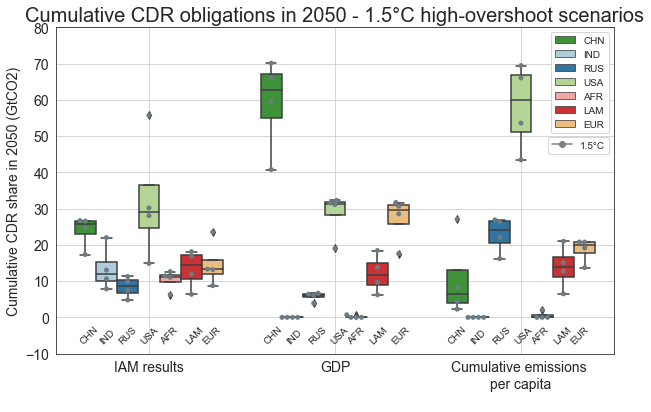

In [468]:
# FIGURE 2 - Boxplot - all models - only 1.5 high overshoot scenarios
scen_allmodels = ['SSP1-19-SPA0-V17', 'SSP1-Ref-SPA0-V17', 'SSP2-Ref-SPA0-V17',
 'SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17',
 'SSP1-26-SPA1-V17', 'SSP2-26-SPA2-V17', 'SSP5-19-SPA5-V17',
 'SSP5-26-SPA5-V17', 'SSP1-19', 'LowEnergyDemand']

scen_15_lo = ['SSP1-19-SPA0-V17', 'LowEnergyDemand', 'SSP1-19'] #only no / limited overshoot

scen_15_ho = ['SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17', 'SSP5-19-SPA5-V17'] # high overshoot

scen_2 = ['SSP2-26-SPA2-V17','SSP1-26-SPA1-V17', 'SSP5-26-SPA5-V17']

scen_15 = ['SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17', 'SSP5-19-SPA5-V17', 'SSP1-19-SPA0-V17', 'LowEnergyDemand', 'SSP1-19']


regions = ['USA', 'CHN', 'RUS', 'EUR', 'AFR', 'LAM', 'IND']
years = ['2050']
variab = ['CUM_CDR_fair_share_by_CUM_POP', 'CUM_CDR_fair_share_by_GDP', 'CUM_CDR']
boxp_2050 = boxplot_df_allmodels.loc[(boxplot_df_allmodels.Region.isin(regions)) &
                            (boxplot_df_allmodels.Scenario.isin(scen_15_ho)) &
                            (boxplot_df_allmodels.Year.isin(years)) &
                            (boxplot_df_allmodels.variable.isin(variab))]

boxp_2050['value'] = boxp_2050['value'].astype(float)/1000


boxp_15 = boxp_2050.loc[boxp_2050.Scenario.isin(scen_15_ho)]
#boxp_2 = boxp_2050.loc[boxp_2050.Scenario.isin(scen_2)]


colours = sns.color_palette("Paired",12)
colour_palette = [colours[3],colours[0],colours[1],colours[2],colours[4],colours[5], colours[6]]

sns.set_context(font_scale=1, rc={"axes.labelsize":12})

f, axes = plt.subplots(1, 1, figsize=(10,6))

box1 = sns.boxplot(x="variable", y="value", data=boxp_2050, hue = 'Region', hue_order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'],
                   palette = colour_palette) # palette = "coolwarm" or "husl", orient= 'horizontal'
box1.annotate('CHN', xy=(0.04, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('IND', xy=(0.075, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('RUS', xy=(0.11, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('USA', xy=(0.15, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('AFR', xy=(0.185, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('LAM', xy=(0.23, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('EUR', xy=(0.26, 0.03), xycoords='axes fraction', rotation=45)

box1.annotate('CHN', xy=(0.37, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('IND', xy=(0.41, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('RUS', xy=(0.45, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('USA', xy=(0.49, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('AFR', xy=(0.52, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('LAM', xy=(0.56, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('EUR', xy=(0.6, 0.03), xycoords='axes fraction', rotation=45)

box1.annotate('CHN', xy=(0.7, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('IND', xy=(0.74, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('RUS', xy=(0.78, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('USA', xy=(0.82, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('AFR', xy=(0.85, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('LAM', xy=(0.89, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('EUR', xy=(0.92, 0.03), xycoords='axes fraction', rotation=45)


#colours = sns.color_palette("Set2",8)
#colour_palette = [colours[8]]
#farbe = sns.xkcd_rgb["pale red"], lw=3

colours_15 = ["battleship grey"]
pal_15 = sns.xkcd_palette(colours_15)
#colours_2 = ["light grey"]                  # color options https://xkcd.com/color/rgb/
#pal_2 = sns.xkcd_palette(colours_2)

box1 = sns.swarmplot(x="variable", y="value", data=boxp_15, hue = 'Region', hue_order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'],
                     palette = pal_15, marker = 'o', facecolors='none', dodge = True)
#box1 = sns.swarmplot(x="variable", y="value", data=boxp_2, hue = 'Region', palette = pal_2, marker = 'o',  facecolors='none', dodge = True)


box1.set_ylabel("Cumulative CDR share in 2050 (GtCO2)", fontsize = 14)
box1.set(xlabel = " ")
box1.set(ylim =(-10,80))
box1.set(xticklabels=['IAM results','GDP','Cumulative emissions \nper capita'])
box1.set_title("Cumulative CDR obligations in 2050 - 1.5°C high-overshoot scenarios", fontsize=20)
box1.tick_params(labelsize=14)


handles, labels = box1.get_legend_handles_labels()
l = plt.legend(handles[0:7], labels[0:7])
l2 = plt.legend(handles=[Line2D([0], [0], marker = 'o', color="grey", label = '1.5°C')], loc = 'best', bbox_to_anchor =(1.0, 0.68))
plt.gca().add_artist(l)
#box1.legend(frameon = False) #bbox_to_anchor=(1.05, 1),borderaxespad=0.   -> bbox und borderaxespad nur wenn Legende außerhalb plot sein soll
        # legend ['Fair CDR according to model', 'Fair CDR according to equity calc (cum pop)', 'Fair CDR according to equity calc (GDP)'],
box1.grid('on')
plt.savefig(plot_path + 'F - Figure 2 - Boxplot2050 15 ho.png')

/Users/susannebaur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


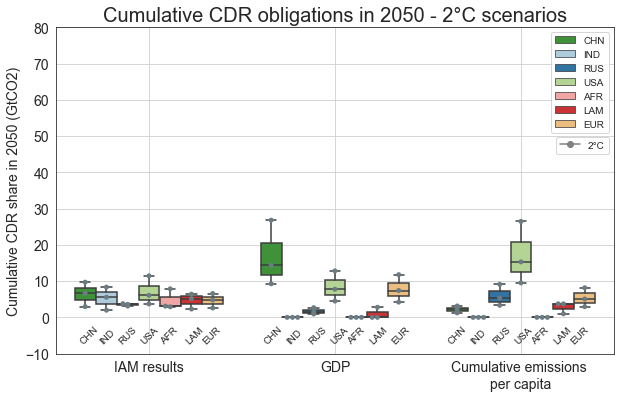

In [470]:
# FIGURE 2 - Boxplot - all models - only 2 scenarios INCL MESSAGE
scen_allmodels = ['SSP1-19-SPA0-V17', 'SSP1-Ref-SPA0-V17', 'SSP2-Ref-SPA0-V17',
 'SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17',
 'SSP1-26-SPA1-V17', 'SSP2-26-SPA2-V17', 'SSP5-19-SPA5-V17',
 'SSP5-26-SPA5-V17', 'SSP1-19', 'LowEnergyDemand']

scen_15_lo = ['SSP1-19-SPA0-V17', 'LowEnergyDemand', 'SSP1-19'] #only no / limited overshoot

scen_15_ho = ['SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17', 'SSP5-19-SPA5-V17'] # high overshoot

scen_2 = ['SSP2-26-SPA2-V17','SSP1-26-SPA1-V17', 'SSP5-26-SPA5-V17']

scen_15 = ['SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17', 'SSP5-19-SPA5-V17', 'SSP1-19-SPA0-V17', 'LowEnergyDemand', 'SSP1-19']



regions = ['USA', 'CHN', 'RUS', 'EUR', 'AFR', 'LAM', 'IND']
years = ['2050']
variab = ['CUM_CDR_fair_share_by_CUM_POP', 'CUM_CDR_fair_share_by_GDP', 'CUM_CDR']
boxp_2050 = boxplot_df_allmodels.loc[(boxplot_df_allmodels.Region.isin(regions)) &
                            (boxplot_df_allmodels.Scenario.isin(scen_2)) &
                            (boxplot_df_allmodels.Year.isin(years)) &
                            (boxplot_df_allmodels.variable.isin(variab))]

boxp_2050['value'] = boxp_2050['value'].astype(float)/1000


#boxp_15 = boxp_2050.loc[boxp_2050.Scenario.isin(scen_15)]
boxp_2 = boxp_2050.loc[boxp_2050.Scenario.isin(scen_2)]


colours = sns.color_palette("Paired",12)
colour_palette = [colours[3],colours[0],colours[1],colours[2],colours[4],colours[5], colours[6]]

sns.set_context(font_scale=1, rc={"axes.labelsize":12})

f, axes = plt.subplots(1, 1, figsize=(10,6))

box1 = sns.boxplot(x="variable", y="value", data=boxp_2050, hue = 'Region', hue_order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'],
                   palette = colour_palette) # palette = "coolwarm" or "husl", orient= 'horizontal'
box1.annotate('CHN', xy=(0.04, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('IND', xy=(0.075, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('RUS', xy=(0.11, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('USA', xy=(0.15, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('AFR', xy=(0.185, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('LAM', xy=(0.23, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('EUR', xy=(0.26, 0.03), xycoords='axes fraction', rotation=45)

box1.annotate('CHN', xy=(0.37, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('IND', xy=(0.41, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('RUS', xy=(0.45, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('USA', xy=(0.49, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('AFR', xy=(0.52, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('LAM', xy=(0.56, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('EUR', xy=(0.6, 0.03), xycoords='axes fraction', rotation=45)

box1.annotate('CHN', xy=(0.7, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('IND', xy=(0.74, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('RUS', xy=(0.78, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('USA', xy=(0.82, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('AFR', xy=(0.85, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('LAM', xy=(0.89, 0.03), xycoords='axes fraction', rotation=45)
box1.annotate('EUR', xy=(0.92, 0.03), xycoords='axes fraction', rotation=45)


#colours = sns.color_palette("Set2",8)
#colour_palette = [colours[8]]
#farbe = sns.xkcd_rgb["pale red"], lw=3

colours_15 = ["battleship grey"]
pal_15 = sns.xkcd_palette(colours_15)
#colours_2 = ["light grey"]                  # color options https://xkcd.com/color/rgb/
#pal_2 = sns.xkcd_palette(colours_2)

#box1 = sns.swarmplot(x="variable", y="value", data=boxp_15, hue = 'Region', palette = pal_15, marker = 'o', facecolors='none', dodge = True)
box1 = sns.swarmplot(x="variable", y="value", data=boxp_2, hue = 'Region',hue_order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'],
                     palette = pal_15, marker = 'o',  facecolors='none', dodge = True)


box1.set_ylabel("Cumulative CDR share in 2050 (GtCO2)", fontsize = 14)
box1.set(xlabel = " ")
box1.set(ylim =(-10,80))
box1.set(xticklabels=['IAM results','GDP','Cumulative emissions \nper capita'])
box1.set_title("Cumulative CDR obligations in 2050 - 2°C scenarios", fontsize=20)
box1.tick_params(labelsize=14)


handles, labels = box1.get_legend_handles_labels()
l = plt.legend(handles[0:7], labels[0:7])
l2 = plt.legend(handles=[Line2D([0], [0], marker = 'o', color="grey", label = '2°C')], loc = 'best', bbox_to_anchor =(1.0, 0.68))
plt.gca().add_artist(l)
#box1.legend(frameon = False) #bbox_to_anchor=(1.05, 1),borderaxespad=0.   -> bbox und borderaxespad nur wenn Legende außerhalb plot sein soll
        # legend ['Fair CDR according to model', 'Fair CDR according to equity calc (cum pop)', 'Fair CDR according to equity calc (GDP)'],
box1.grid('on')
plt.savefig(plot_path + 'F - Figure 2 - Boxplot2050 2 scenarios.png')

/Users/susannebaur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


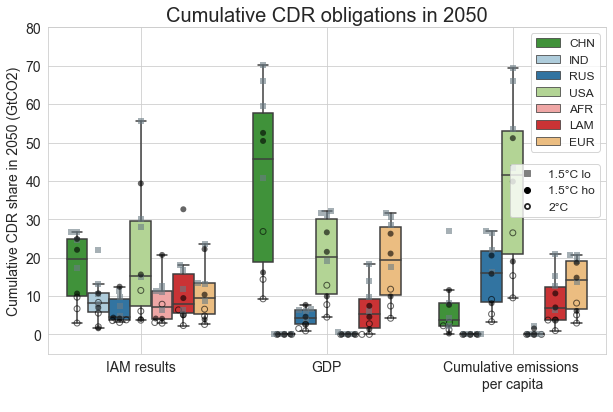

In [183]:
# FIGURE 2 - Boxplot 2050  - all models 1.5ho and 1.5lo seperate

scen_allmodels = ['SSP1-19-SPA0-V17', 
 'SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17',
 'SSP1-26-SPA1-V17', 'SSP2-26-SPA2-V17', 'SSP5-19-SPA5-V17',
 'SSP5-26-SPA5-V17', 'LowEnergyDemand', 'SSP1-19']

#scen_allmodels = ['SSP1-19-SPA0-V17', 'SSP1-Ref-SPA0-V17', 'SSP2-Ref-SPA0-V17',
# 'SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17',
# 'SSP1-26-SPA1-V17', 'SSP2-26-SPA2-V17', 'SSP5-19-SPA5-V17',
# 'SSP5-26-SPA5-V17', 'LowEnergyDemand', 'SSP1-19']

scen_15_lo = ['SSP1-19-SPA0-V17', 'LowEnergyDemand', 'SSP1-19'] #only no / limited overshoot

scen_15_ho = ['SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17', 'SSP5-19-SPA5-V17'] # high overshoot

scen_2 = ['SSP2-26-SPA2-V17','SSP1-26-SPA1-V17', 'SSP5-26-SPA5-V17']

scen_15 = ['SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17', 'SSP5-19-SPA5-V17', 'SSP1-19-SPA0-V17', 'LowEnergyDemand', 'SSP1-19']




regions = ['USA', 'CHN', 'RUS', 'EUR', 'AFR', 'LAM', 'IND']
years = ['2050']
variab = ['CUM_CDR_fair_share_by_CUM_POP', 'CUM_CDR_fair_share_by_GDP', 'CUM_CDR']
boxp_2050 = boxplot_df_allmodels.loc[(boxplot_df_allmodels.Region.isin(regions)) &
                            (boxplot_df_allmodels.Scenario.isin(scen_allmodels)) &
                            (boxplot_df_allmodels.Year.isin(years)) &
                            (boxplot_df_allmodels.variable.isin(variab))]

boxp_2050['value'] = boxp_2050['value'].astype(float)/1000

boxp_15 = boxp_2050.loc[boxp_2050.Scenario.isin(scen_15)]
boxp_2 = boxp_2050.loc[boxp_2050.Scenario.isin(scen_2)]
boxp_15_lo = boxp_2050.loc[boxp_2050.Scenario.isin(scen_15_lo)]
boxp_15_ho = boxp_2050.loc[boxp_2050.Scenario.isin(scen_15_ho)]



sns.set_context(font_scale=1, rc={"axes.labelsize":12})

f, axes = plt.subplots(1, 1, figsize=(10,6))

colours = sns.color_palette("Paired",12)
colour_palette = [colours[3],colours[0],colours[1],colours[2],colours[4],colours[5], colours[6]]
#CHN 3 RUS 0, USA 1, AFR 2, LAM 4, EUR 5, IND 6
#AFR 9, CHN 1, EUR 2, IND 3, JPN 10, LAM 5, MEA 6, OAS 7, ROW 8, RUS 0, USA 4

box1 = sns.boxplot(x="variable", y="value", data=boxp_2050, hue = 'Region', palette = colour_palette, showfliers=False) # palette = 'Paired', palette = "coolwarm" or "husl", orient= 'horizontal'
#box1.annotate('CHN', xy=(0.039, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('IND', xy=(0.075, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('RUS', xy=(0.11, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('USA', xy=(0.15, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('AFR', xy=(0.185, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('LAM', xy=(0.22, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('EUR', xy=(0.26, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)

#box1.annotate('CHN', xy=(0.37, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('IND', xy=(0.41, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('RUS', xy=(0.447, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('USA', xy=(0.48, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('AFR', xy=(0.52, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('LAM', xy=(0.555, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('EUR', xy=(0.6, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)

#box1.annotate('CHN', xy=(0.7, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('IND', xy=(0.74, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('RUS', xy=(0.78, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('USA', xy=(0.82, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('AFR', xy=(0.855, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('LAM', xy=(0.89, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)
#box1.annotate('EUR', xy=(0.92, 0.02), xycoords='axes fraction', rotation=45, fontsize = 12)

colours_15 = ["black"]
pal_15 = sns.xkcd_palette(colours_15)
colours_2 = ["light grey"]                  # color options https://xkcd.com/color/rgb/
pal_2 = sns.xkcd_palette(colours_2)
colours_15_lo = ["black"]
pal_15_lo = sns.xkcd_palette(colours_15_lo)
colours_15_ho = ["battleship grey"]
pal_15_ho = sns.xkcd_palette(colours_15_ho)


pts = np.linspace(0, np.pi * 2, 24)
circ = np.c_[np.sin(pts) / 2, -np.cos(pts) / 2]
vert = np.r_[circ, circ[::-1] * .7]
open_circle = mpl.path.Path(vert)

box1 = sns.swarmplot(x="variable", y="value", data=boxp_2, hue = 'Region', 
                     hue_order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'], palette= pal_15, marker = open_circle, dodge = True, s=7, alpha=0.6)
box1 = sns.swarmplot(x="variable", y="value", data=boxp_15_ho, hue = 'Region', 
                     hue_order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'], palette = pal_15_ho, marker = 's', dodge = True, s=6, alpha=0.6)
box1 = sns.swarmplot(x="variable", y="value", data=boxp_15_lo, hue = 'Region', 
                     hue_order = ['CHN', 'IND', 'RUS', 'USA', 'AFR', 'LAM', 'EUR'], palette = pal_15_lo, marker = 'o', dodge = True, s=6, alpha =0.6)
#marker maybe 's' '*' 'P'


box1.set_ylabel("Cumulative CDR share in 2050 (GtCO2)", fontsize = 14)
box1.set(xlabel = " ")
box1.set(ylim =(-5,80))
box1.set(xticklabels=['IAM results','GDP','Cumulative emissions \nper capita'])
box1.set_title("Cumulative CDR obligations in 2050", fontsize=20)
box1.tick_params(labelsize=14)

handles, labels = box1.get_legend_handles_labels()
l = plt.legend(handles[0:7], labels[0:7], fontsize = 12)
l2 = plt.legend(handles=[Line2D([0], [0], linestyle = 'none', marker = 's', color="grey", label = '1.5°C lo'),
                         Line2D([0], [0], linestyle = 'none', marker = 'o', color="black", label = '1.5°C ho'),
            Line2D([0], [0], linestyle = 'none', marker = open_circle, color="black", label = '2°C', alpha=0.7)], 
                loc = 'center right', bbox_to_anchor =(1.0, 0.5), fontsize = 12)    # 0.155, 0.68 <- for left side
plt.gca().add_artist(l)

box1.grid('on')
#plt.savefig(plot_path + 'Figure 2 - Boxplot2050 holo.svg', dpi = 300)
plt.savefig(plot_path + 'F - Figure 2 - Boxplot2050 holo.png')

/Users/susannebaur/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


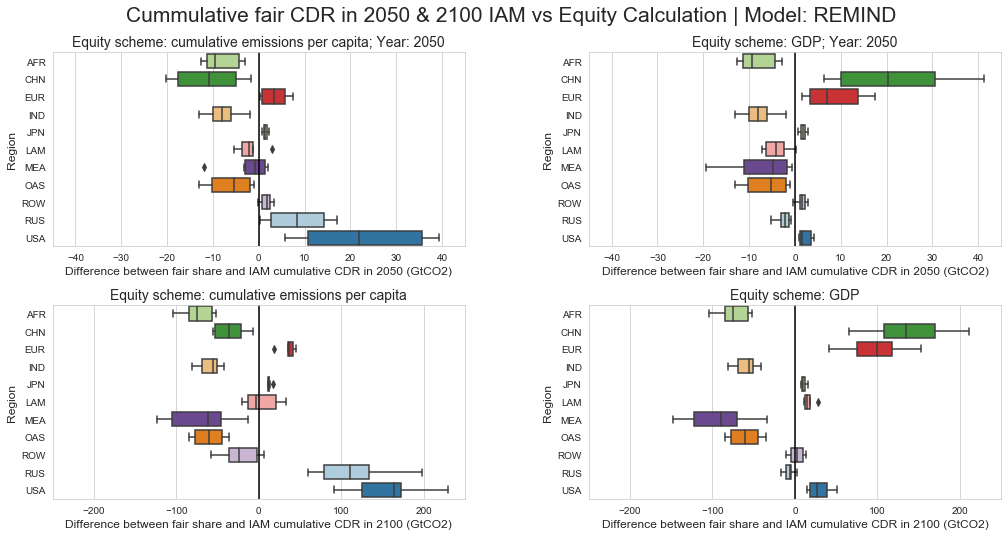

In [533]:
### FIGURE 3 - Plot cumulative fair CDR in 2100  - only REMIND!!

sns.set_style('whitegrid')
years=[2050,2100]
rfilt_wo_world=(equity_remind.Region!='World')
scen_15 =['SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17','SSP5-19-SPA5-V17']
sfilt = (equity_remind.Scenario.isin(scen_15))

p_data=equity_remind[equity_remind.Year.isin(years)&rfilt_wo_world]   
# p_data=equity_remind[equity_remind.Year.isin(years)&rfilt_wo_world&sfilt]  #for only RCP1.9 pathways

p_data.loc[:,'CUM_CDR_model_vs_fair_share_by_CUM_POP'] = p_data.loc[:,'CUM_CDR_model_vs_fair_share_by_CUM_POP']/1000
p_data.loc[:,'CUM_CDR_model_vs_fair_share_by_GDP'] = p_data.loc[:,'CUM_CDR_model_vs_fair_share_by_GDP']/1000

CUM_POP_data=pd.DataFrame(columns=['Year','Scenario','Region','CDR_EQ','CDR_DIFF_IAM_vs_Eq','CUM_CDR_EQ','CUM CDR difference IAM vs EQ','EQ_Method'])

CUM_POP_data[['Year','Scenario','Region','CDR_EQ','CDR_DIFF_IAM_vs_Eq',
             'CUM_CDR_EQ','CUM CDR difference IAM vs EQ']]=p_data[['Year','Scenario','Region',
                                                              'CDR_fair_share_by_CUM_POP',
                                                              'CDR_model_vs_fair_share_by_CUM_POP',
                                                              'CUM_CDR_fair_share_by_CUM_POP',
                                                              'CUM_CDR_model_vs_fair_share_by_CUM_POP']]
CUM_POP_data['EQ_Method']='CUM_POP'

GDP_data=pd.DataFrame(columns=['Year','Scenario','Region','CDR_EQ','CDR_DIFF_IAM_vs_Eq','CUM_CDR_EQ','CUM CDR difference IAM vs EQ','EQ_Method'])

GDP_data[['Year','Scenario','Region','CDR_EQ','CDR_DIFF_IAM_vs_Eq'
         ,'CUM_CDR_EQ','CUM CDR difference IAM vs EQ']]=p_data[['Year','Scenario','Region',
                                                              'CDR_fair_share_by_GDP',
                                                              'CDR_model_vs_fair_share_by_GDP',
                                                              'CUM_CDR_fair_share_by_GDP',
                                                              'CUM_CDR_model_vs_fair_share_by_GDP']]
GDP_data['EQ_Method']='GDP'

pl_data=CUM_POP_data.append(GDP_data)

pl_data_50 = pl_data.loc[(pl_data.Year == 2050)& (pl_data.EQ_Method == 'CUM_POP')]
pl_data_50_SSP1 = pl_data_50.loc[(pl_data_50.Scenario == 'SSP1-19-SPA1-V17')]
pl_data_50_SSP5 = pl_data_50.loc[(pl_data_50.Scenario == 'SSP5-19-SPA5-V17')]

pl_data_100 = pl_data.loc[(pl_data.Year == 2100)& (pl_data.EQ_Method == 'CUM_POP')]
pl_data_100_SSP1 = pl_data_100.loc[(pl_data_100.Scenario == 'SSP1-19-SPA1-V17')]
pl_data_100_SSP5 = pl_data_100.loc[(pl_data_100.Scenario == 'SSP5-19-SPA5-V17')]

gdp_data_50 = pl_data.loc[(pl_data.Year == 2050)& (pl_data.EQ_Method == 'GDP')]
gdp_data_50_SSP1 = gdp_data_50.loc[(gdp_data_50.Scenario == 'SSP1-19-SPA1-V17')]
gdp_data_50_SSP5 = gdp_data_50.loc[(gdp_data_50.Scenario == 'SSP5-19-SPA5-V17')]

gdp_data_100 = pl_data.loc[(pl_data.Year == 2100)& (pl_data.EQ_Method == 'GDP')]
gdp_data_100_SSP1 = gdp_data_100.loc[(gdp_data_100.Scenario == 'SSP1-19-SPA1-V17')]
gdp_data_100_SSP5 = gdp_data_100.loc[(gdp_data_100.Scenario == 'SSP5-19-SPA5-V17')]

pl_data_50  = pl_data_50.reset_index()
pl_data_100  = pl_data_100.reset_index()
gdp_data_50  = gdp_data_50.reset_index()
gdp_data_100  = gdp_data_100.reset_index()
pl_data_50_SSP1  = pl_data_50_SSP1.reset_index()
pl_data_50_SSP5  = pl_data_50_SSP5.reset_index()
gdp_data_50_SSP1  = gdp_data_50_SSP1.reset_index()
gdp_data_50_SSP5  = gdp_data_50_SSP5.reset_index()
pl_data_100_SSP1  = pl_data_100_SSP1.reset_index()
pl_data_100_SSP5  = pl_data_100_SSP5.reset_index()
gdp_data_100_SSP1  = gdp_data_100_SSP1.reset_index()
gdp_data_100_SSP5  = gdp_data_100_SSP5.reset_index()

fig, axs = plt.subplots(2,2,  figsize=(17,8)) #sharex = True, sharey = True
title = fig.suptitle("Cummulative fair CDR in 2050 & 2100 IAM vs Equity Calculation | Model: REMIND", fontsize = 21)
fig.subplots_adjust(top=0.9, wspace=0.3, hspace = 0.3)


colours = sns.color_palette("Paired",12)
colour_palette = [colours[2],colours[3],colours[5],colours[6],colours[10],colours[4], colours[9],colours[7],colours[8],colours[0],colours[1]]
#CHN 0 RUS 1, USA 2, AFR 3, LAM 4, EUR 5, IND 6
# colour_palette = [colours[3],colours[0],colours[1],colours[2],colours[4],colours[5], colours[6]]
#CHN 3 RUS 0, USA 1, AFR 2, LAM 4, EUR 5, IND 6

# box1.set(ylim =(-50,450))
# box1.set(xticklabels=['IAM results','GDP','Cumulative emissions \nper capita'])

regions_order = ['AFR', 'CHN', 'EUR', 'LAM', 'USA', 'RUS', 'IND']

axs_pop_50 = sns.boxplot(x = 'CUM CDR difference IAM vs EQ', y= 'Region', 
                          data= pl_data_50,
                         palette = colour_palette, ax = axs[0,0]).set_title('Equity scheme: cumulative emissions per capita; Year: 2050', fontsize = 14)
axs_pop_100 = sns.boxplot(x = 'CUM CDR difference IAM vs EQ', y= 'Region', 
                           data= pl_data_100, 
                          palette = colour_palette, ax = axs[1,0]).set_title('Equity scheme: cumulative emissions per capita', fontsize = 14)
axs_gdp_50 = sns.boxplot(x = 'CUM CDR difference IAM vs EQ', y= 'Region', 
                          data= gdp_data_50, 
                         palette = colour_palette, ax = axs[0,1]).set_title('Equity scheme: GDP; Year: 2050', fontsize = 14)
axs_gdp_100 = sns.boxplot(x = 'CUM CDR difference IAM vs EQ', y= 'Region', 
                           data= gdp_data_100, 
                          palette = colour_palette, ax = axs[1,1]).set_title('Equity scheme: GDP', fontsize = 14)


axs[0,0].set_xlim([-45, 45])
axs[1,0].set_xlim([-250, 250])
axs[0,1].set_xlim([-45, 45])
axs[1,1].set_xlim([-250, 250])

axs[0,0].axvline(color = 'black')
axs[1,0].axvline(color = 'black')
axs[0,1].axvline(color = 'black')
axs[1,1].axvline(color = 'black')

axs[1,0].set(xlabel = "Difference between fair share and IAM cumulative CDR in 2100 (GtCO2)")
axs[1,1].set(xlabel = "Difference between fair share and IAM cumulative CDR in 2100 (GtCO2)")
axs[0,0].set(xlabel = "Difference between fair share and IAM cumulative CDR in 2050 (GtCO2)")
axs[0,1].set(xlabel = "Difference between fair share and IAM cumulative CDR in 2050 (GtCO2)")
# axs_pop_50.legend()
plt.savefig(plot_path + 'F - Figure 4 - REMIND Regions.png')
#plt.savefig(plot_path + 'Figure 4 - REMIND Regions.svg', dpi = 300, edgecolor = "white", transparent = True)

/Users/susannebaur/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


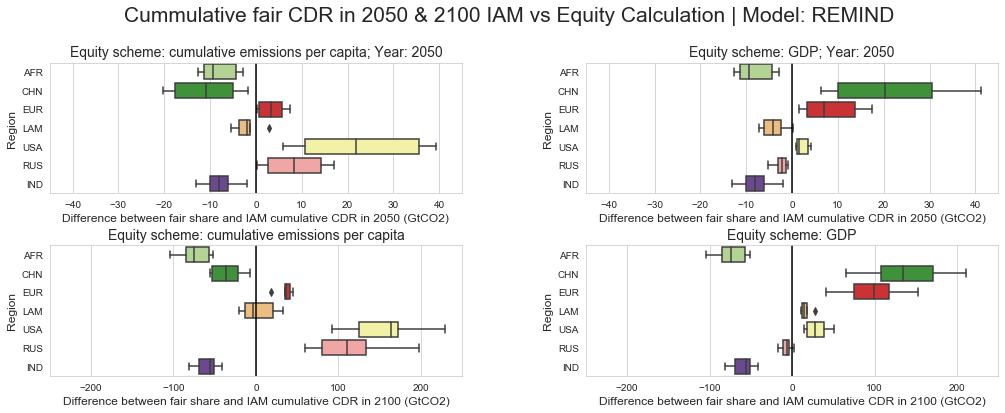

In [498]:
### FIGURE 3 - Plot cumulative fair CDR in 2100  - only REMIND!!

sns.set_style('whitegrid')
years=[2050,2100]
rfilt_wo_world=(equity_equal_remind.Region!='World')
scen_15 =['SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17','SSP5-19-SPA5-V17']
sfilt = (equity_equal_remind.Scenario.isin(scen_15))

p_data=equity_equal_remind[equity_equal_remind.Year.isin(years)&rfilt_wo_world]   
# p_data=equity_remind[equity_remind.Year.isin(years)&rfilt_wo_world&sfilt]  #for only RCP1.9 pathways

p_data.loc[:,'CUM_CDR_model_vs_fair_share_by_CUM_POP'] = p_data.loc[:,'CUM_CDR_model_vs_fair_share_by_CUM_POP']/1000
p_data.loc[:,'CUM_CDR_model_vs_fair_share_by_GDP'] = p_data.loc[:,'CUM_CDR_model_vs_fair_share_by_GDP']/1000

CUM_POP_data=pd.DataFrame(columns=['Year','Scenario','Region','CDR_EQ','CDR_DIFF_IAM_vs_Eq','CUM_CDR_EQ','CUM CDR difference IAM vs EQ','EQ_Method'])

CUM_POP_data[['Year','Scenario','Region','CDR_EQ','CDR_DIFF_IAM_vs_Eq',
             'CUM_CDR_EQ','CUM CDR difference IAM vs EQ']]=p_data[['Year','Scenario','Region',
                                                              'CDR_fair_share_by_CUM_POP',
                                                              'CDR_model_vs_fair_share_by_CUM_POP',
                                                              'CUM_CDR_fair_share_by_CUM_POP',
                                                              'CUM_CDR_model_vs_fair_share_by_CUM_POP']]
CUM_POP_data['EQ_Method']='CUM_POP'

GDP_data=pd.DataFrame(columns=['Year','Scenario','Region','CDR_EQ','CDR_DIFF_IAM_vs_Eq','CUM_CDR_EQ','CUM CDR difference IAM vs EQ','EQ_Method'])

GDP_data[['Year','Scenario','Region','CDR_EQ','CDR_DIFF_IAM_vs_Eq'
         ,'CUM_CDR_EQ','CUM CDR difference IAM vs EQ']]=p_data[['Year','Scenario','Region',
                                                              'CDR_fair_share_by_GDP',
                                                              'CDR_model_vs_fair_share_by_GDP',
                                                              'CUM_CDR_fair_share_by_GDP',
                                                              'CUM_CDR_model_vs_fair_share_by_GDP']]
GDP_data['EQ_Method']='GDP'

pl_data=CUM_POP_data.append(GDP_data)

pl_data_50 = pl_data.loc[(pl_data.Year == 2050)& (pl_data.EQ_Method == 'CUM_POP')]
pl_data_50_SSP1 = pl_data_50.loc[(pl_data_50.Scenario == 'SSP1-19-SPA1-V17')]
pl_data_50_SSP5 = pl_data_50.loc[(pl_data_50.Scenario == 'SSP5-19-SPA5-V17')]

pl_data_100 = pl_data.loc[(pl_data.Year == 2100)& (pl_data.EQ_Method == 'CUM_POP')]
pl_data_100_SSP1 = pl_data_100.loc[(pl_data_100.Scenario == 'SSP1-19-SPA1-V17')]
pl_data_100_SSP5 = pl_data_100.loc[(pl_data_100.Scenario == 'SSP5-19-SPA5-V17')]

gdp_data_50 = pl_data.loc[(pl_data.Year == 2050)& (pl_data.EQ_Method == 'GDP')]
gdp_data_50_SSP1 = gdp_data_50.loc[(gdp_data_50.Scenario == 'SSP1-19-SPA1-V17')]
gdp_data_50_SSP5 = gdp_data_50.loc[(gdp_data_50.Scenario == 'SSP5-19-SPA5-V17')]

gdp_data_100 = pl_data.loc[(pl_data.Year == 2100)& (pl_data.EQ_Method == 'GDP')]
gdp_data_100_SSP1 = gdp_data_100.loc[(gdp_data_100.Scenario == 'SSP1-19-SPA1-V17')]
gdp_data_100_SSP5 = gdp_data_100.loc[(gdp_data_100.Scenario == 'SSP5-19-SPA5-V17')]

pl_data_50  = pl_data_50.reset_index()
pl_data_100  = pl_data_100.reset_index()
gdp_data_50  = gdp_data_50.reset_index()
gdp_data_100  = gdp_data_100.reset_index()
pl_data_50_SSP1  = pl_data_50_SSP1.reset_index()
pl_data_50_SSP5  = pl_data_50_SSP5.reset_index()
gdp_data_50_SSP1  = gdp_data_50_SSP1.reset_index()
gdp_data_50_SSP5  = gdp_data_50_SSP5.reset_index()
pl_data_100_SSP1  = pl_data_100_SSP1.reset_index()
pl_data_100_SSP5  = pl_data_100_SSP5.reset_index()
gdp_data_100_SSP1  = gdp_data_100_SSP1.reset_index()
gdp_data_100_SSP5  = gdp_data_100_SSP5.reset_index()

fig, axs = plt.subplots(2,2,  figsize=(17,6)) #sharex = True, sharey = True
title = fig.suptitle("Cummulative fair CDR in 2050 & 2100 IAM vs Equity Calculation | Model: REMIND", fontsize = 21)
fig.subplots_adjust(top=0.85, wspace=0.3, hspace = 0.4)


regions_order = ['AFR', 'CHN', 'EUR', 'LAM', 'USA', 'RUS', 'IND']


colours = sns.color_palette("Paired",12)
colour_palette = [colours[2],colours[3],colours[5],colours[6],colours[10],colours[4], colours[9],colours[7],colours[8],colours[0],colours[1]]
#CHN 0 RUS 1, USA 2, AFR 3, LAM 4, EUR 5, IND 6
# colour_palette = [colours[3],colours[0],colours[1],colours[2],colours[4],colours[5], colours[6]]
#CHN 3 RUS 0, USA 1, AFR 2, LAM 4, EUR 5, IND 6

# box1.set(ylim =(-50,450))
# box1.set(xticklabels=['IAM results','GDP','Cumulative emissions \nper capita'])

axs_pop_50 = sns.boxplot(x = 'CUM CDR difference IAM vs EQ', y= 'Region', 
                         order = regions_order, data= pl_data_50,
                         palette = colour_palette, ax = axs[0,0]).set_title('Equity scheme: cumulative emissions per capita; Year: 2050', fontsize = 14)
axs_pop_100 = sns.boxplot(x = 'CUM CDR difference IAM vs EQ', y= 'Region', 
                          order = regions_order, data= pl_data_100, 
                          palette = colour_palette, ax = axs[1,0]).set_title('Equity scheme: cumulative emissions per capita', fontsize = 14)
axs_gdp_50 = sns.boxplot(x = 'CUM CDR difference IAM vs EQ', y= 'Region', 
                         order = regions_order, data= gdp_data_50, 
                         palette = colour_palette, ax = axs[0,1]).set_title('Equity scheme: GDP; Year: 2050', fontsize = 14)
axs_gdp_100 = sns.boxplot(x = 'CUM CDR difference IAM vs EQ', y= 'Region', 
                          order = regions_order, data= gdp_data_100, 
                          palette = colour_palette, ax = axs[1,1]).set_title('Equity scheme: GDP', fontsize = 14)


axs[0,0].set_xlim([-45, 45])
axs[1,0].set_xlim([-250, 250])
axs[0,1].set_xlim([-45, 45])
axs[1,1].set_xlim([-250, 250])

axs[0,0].axvline(color = 'black')
axs[1,0].axvline(color = 'black')
axs[0,1].axvline(color = 'black')
axs[1,1].axvline(color = 'black')

axs[1,0].set(xlabel = "Difference between fair share and IAM cumulative CDR in 2100 (GtCO2)")
axs[1,1].set(xlabel = "Difference between fair share and IAM cumulative CDR in 2100 (GtCO2)")
axs[0,0].set(xlabel = "Difference between fair share and IAM cumulative CDR in 2050 (GtCO2)")
axs[0,1].set(xlabel = "Difference between fair share and IAM cumulative CDR in 2050 (GtCO2)")
# axs_pop_50.legend()
plt.savefig(plot_path + 'F - Figure 4 - REMIND.png')
#plt.savefig(plot_path + 'Figure 4 - REMIND.svg', dpi = 300, edgecolor = "white", transparent = True)

/Users/susannebaur/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


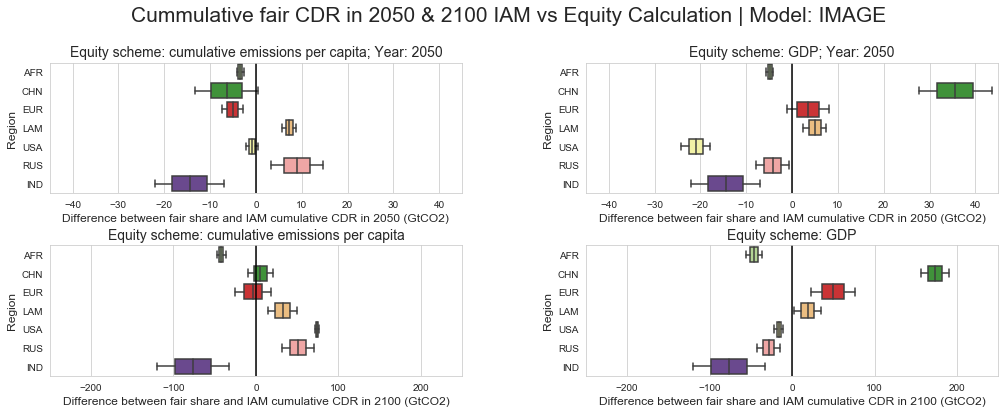

In [496]:
### FIGURE 3 - Plot cumulative fair CDR in 2100  - only IMAGE!!

sns.set_style('whitegrid')
years=[2050,2100]
rfilt_wo_world=(equity_equal_image.Region!='World')
scen_15 =['SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17','SSP5-19-SPA5-V17']
sfilt = (equity_equal_image.Scenario.isin(scen_15))
scen_filt = (equity_equal_image.Scenario.isin(scen_allmodels))

p_data=equity_equal_image[equity_equal_image.Year.isin(years)&rfilt_wo_world&scen_filt]   
# p_data=equity_remind[equity_remind.Year.isin(years)&rfilt_wo_world&sfilt]  #for only RCP1.9 pathways

p_data.loc[:,'CUM_CDR_model_vs_fair_share_by_CUM_POP'] = p_data.loc[:,'CUM_CDR_model_vs_fair_share_by_CUM_POP']/1000
p_data.loc[:,'CUM_CDR_model_vs_fair_share_by_GDP'] = p_data.loc[:,'CUM_CDR_model_vs_fair_share_by_GDP']/1000

CUM_POP_data=pd.DataFrame(columns=['Year','Scenario','Region','CDR_EQ','CDR_DIFF_IAM_vs_Eq','CUM_CDR_EQ','CUM CDR difference IAM vs EQ','EQ_Method'])

CUM_POP_data[['Year','Scenario','Region','CDR_EQ','CDR_DIFF_IAM_vs_Eq',
             'CUM_CDR_EQ','CUM CDR difference IAM vs EQ']]=p_data[['Year','Scenario','Region',
                                                              'CDR_fair_share_by_CUM_POP',
                                                              'CDR_model_vs_fair_share_by_CUM_POP',
                                                              'CUM_CDR_fair_share_by_CUM_POP',
                                                              'CUM_CDR_model_vs_fair_share_by_CUM_POP']]
CUM_POP_data['EQ_Method']='CUM_POP'

GDP_data=pd.DataFrame(columns=['Year','Scenario','Region','CDR_EQ','CDR_DIFF_IAM_vs_Eq','CUM_CDR_EQ','CUM CDR difference IAM vs EQ','EQ_Method'])

GDP_data[['Year','Scenario','Region','CDR_EQ','CDR_DIFF_IAM_vs_Eq'
         ,'CUM_CDR_EQ','CUM CDR difference IAM vs EQ']]=p_data[['Year','Scenario','Region',
                                                              'CDR_fair_share_by_GDP',
                                                              'CDR_model_vs_fair_share_by_GDP',
                                                              'CUM_CDR_fair_share_by_GDP',
                                                              'CUM_CDR_model_vs_fair_share_by_GDP']]
GDP_data['EQ_Method']='GDP'

pl_data=CUM_POP_data.append(GDP_data)

pl_data_50 = pl_data.loc[(pl_data.Year == 2050)& (pl_data.EQ_Method == 'CUM_POP')]
pl_data_50_SSP1 = pl_data_50.loc[(pl_data_50.Scenario == 'SSP1-19-SPA0-V17')]
pl_data_50_SSP5 = pl_data_50.loc[(pl_data_50.Scenario == 'SSP2-LF-SPA2-V17')]

pl_data_100 = pl_data.loc[(pl_data.Year == 2100)& (pl_data.EQ_Method == 'CUM_POP')]
pl_data_100_SSP1 = pl_data_100.loc[(pl_data_100.Scenario == 'SSP1-19-SPA0-V17')]
pl_data_100_SSP5 = pl_data_100.loc[(pl_data_100.Scenario == 'SSP2-LF-SPA2-V17')]

gdp_data_50 = pl_data.loc[(pl_data.Year == 2050)& (pl_data.EQ_Method == 'GDP')]
gdp_data_50_SSP1 = gdp_data_50.loc[(gdp_data_50.Scenario == 'SSP1-19-SPA0-V17')]
gdp_data_50_SSP5 = gdp_data_50.loc[(gdp_data_50.Scenario == 'SSP2-LF-SPA2-V17')]

gdp_data_100 = pl_data.loc[(pl_data.Year == 2100)& (pl_data.EQ_Method == 'GDP')]
gdp_data_100_SSP1 = gdp_data_100.loc[(gdp_data_100.Scenario == 'SSP1-19-SPA0-V17')]
gdp_data_100_SSP5 = gdp_data_100.loc[(gdp_data_100.Scenario == 'SSP2-LF-SPA2-V17')]

pl_data_50  = pl_data_50.reset_index()
pl_data_100  = pl_data_100.reset_index()
gdp_data_50  = gdp_data_50.reset_index()
gdp_data_100  = gdp_data_100.reset_index()
pl_data_50_SSP1  = pl_data_50_SSP1.reset_index()
pl_data_50_SSP5  = pl_data_50_SSP5.reset_index()
gdp_data_50_SSP1  = gdp_data_50_SSP1.reset_index()
gdp_data_50_SSP5  = gdp_data_50_SSP5.reset_index()
pl_data_100_SSP1  = pl_data_100_SSP1.reset_index()
pl_data_100_SSP5  = pl_data_100_SSP5.reset_index()
gdp_data_100_SSP1  = gdp_data_100_SSP1.reset_index()
gdp_data_100_SSP5  = gdp_data_100_SSP5.reset_index()

fig, axs = plt.subplots(2,2, figsize=(17,6)) #, sharey = True
title = fig.suptitle("Cummulative fair CDR in 2050 & 2100 IAM vs Equity Calculation | Model: IMAGE", fontsize = 21)
fig.subplots_adjust(top=0.85, wspace=0.3, hspace = 0.4)

regions_order = ['AFR', 'CHN', 'EUR', 'LAM', 'USA', 'RUS', 'IND']

colours = sns.color_palette("Paired",12)
colour_palette = [colours[2],colours[3],colours[5],colours[6],colours[10],colours[4], colours[9],colours[7],colours[8],colours[0],colours[1]]
#CHN 0 RUS 1, USA 2, AFR 3, LAM 4, EUR 5, IND 6
# colour_palette = [colours[3],colours[0],colours[1],colours[2],colours[4],colours[5], colours[6]]
#CHN 3 RUS 0, USA 1, AFR 2, LAM 4, EUR 5, IND 6

# box1.set(ylim =(-50,450))
# box1.set(xticklabels=['IAM results','GDP','Cumulative emissions \nper capita'])

axs_pop_50 = sns.boxplot(x = 'CUM CDR difference IAM vs EQ', y= 'Region', 
                         order = regions_order, data= pl_data_50,
                         palette = colour_palette, ax = axs[0,0]).set_title('Equity scheme: cumulative emissions per capita; Year: 2050', fontsize = 14)
axs_pop_100 = sns.boxplot(x = 'CUM CDR difference IAM vs EQ', y= 'Region', 
                          order = regions_order, data= pl_data_100, 
                          palette = colour_palette, ax = axs[1,0]).set_title('Equity scheme: cumulative emissions per capita', fontsize = 14)
axs_gdp_50 = sns.boxplot(x = 'CUM CDR difference IAM vs EQ', y= 'Region', 
                         order = regions_order, data= gdp_data_50, 
                         palette = colour_palette, ax = axs[0,1]).set_title('Equity scheme: GDP; Year: 2050', fontsize = 14)
axs_gdp_100 = sns.boxplot(x = 'CUM CDR difference IAM vs EQ', y= 'Region', 
                          order = regions_order, data= gdp_data_100, 
                          palette = colour_palette, ax = axs[1,1]).set_title('Equity scheme: GDP', fontsize = 14)


axs[0,0].set_xlim([-45, 45])
axs[1,0].set_xlim([-250, 250])
axs[0,1].set_xlim([-45, 45])
axs[1,1].set_xlim([-250, 250])

axs[0,0].axvline(color = 'black')
axs[1,0].axvline(color = 'black')
axs[0,1].axvline(color = 'black')
axs[1,1].axvline(color = 'black')

axs[1,0].set(xlabel = "Difference between fair share and IAM cumulative CDR in 2100 (GtCO2)")
axs[1,1].set(xlabel = "Difference between fair share and IAM cumulative CDR in 2100 (GtCO2)")
axs[0,0].set(xlabel = "Difference between fair share and IAM cumulative CDR in 2050 (GtCO2)")
axs[0,1].set(xlabel = "Difference between fair share and IAM cumulative CDR in 2050 (GtCO2)")
# axs_pop_50.legend()
plt.savefig(plot_path + 'F - Figure 4 - IMAGE.png')
#plt.savefig(plot_path + 'Figure 4 - REMIND.svg', dpi = 300, edgecolor = "white", transparent = True)

/Users/susannebaur/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


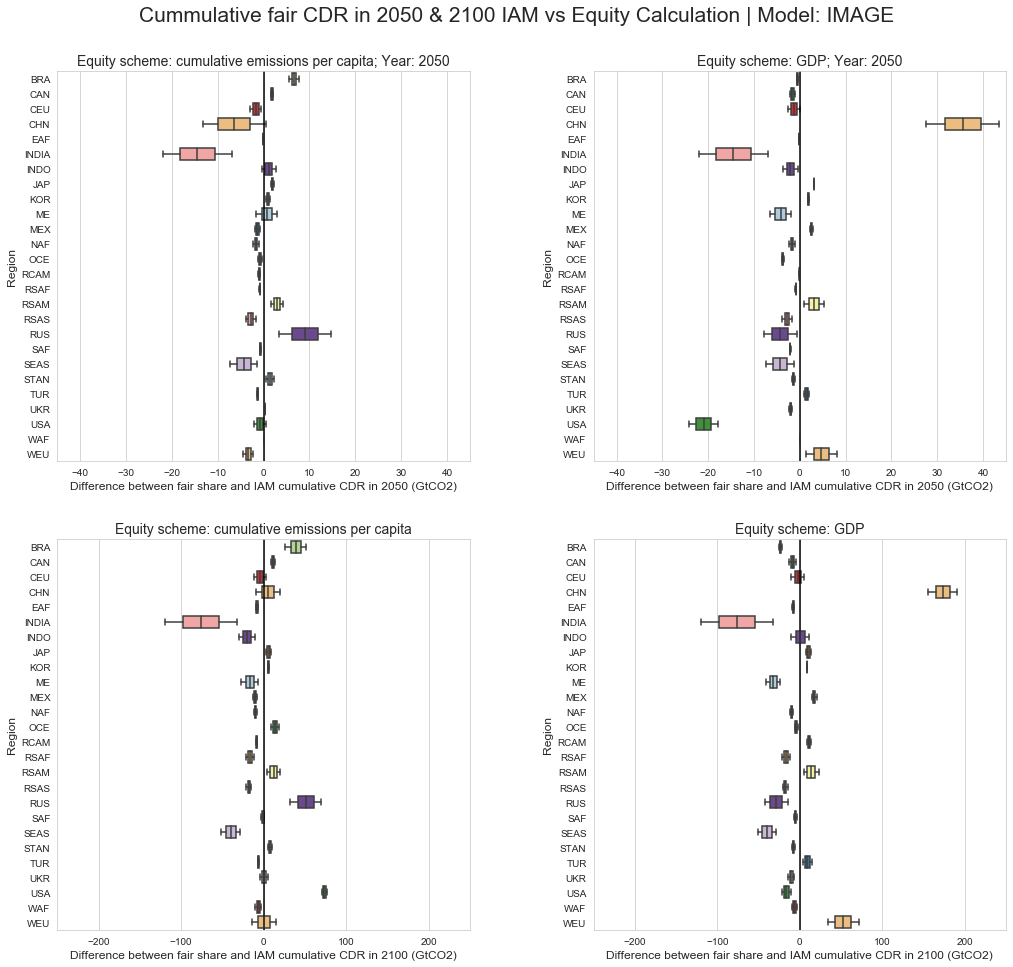

In [497]:
### FIGURE 3 - Plot cumulative fair CDR in 2100  - only IMAGE - image regions!!

sns.set_style('whitegrid')
years=[2050,2100]
rfilt_wo_world=(equity_image.Region!='World')
scen_15 =['SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17','SSP5-19-SPA5-V17']
sfilt = (equity_image.Scenario.isin(scen_15))
scen_filt = (equity_image.Scenario.isin(scen_allmodels))

p_data=equity_image[equity_image.Year.isin(years)&rfilt_wo_world&scen_filt]   
# p_data=equity_remind[equity_remind.Year.isin(years)&rfilt_wo_world&sfilt]  #for only RCP1.9 pathways

p_data.loc[:,'CUM_CDR_model_vs_fair_share_by_CUM_POP'] = p_data.loc[:,'CUM_CDR_model_vs_fair_share_by_CUM_POP']/1000
p_data.loc[:,'CUM_CDR_model_vs_fair_share_by_GDP'] = p_data.loc[:,'CUM_CDR_model_vs_fair_share_by_GDP']/1000

CUM_POP_data=pd.DataFrame(columns=['Year','Scenario','Region','CDR_EQ','CDR_DIFF_IAM_vs_Eq','CUM_CDR_EQ','CUM CDR difference IAM vs EQ','EQ_Method'])

CUM_POP_data[['Year','Scenario','Region','CDR_EQ','CDR_DIFF_IAM_vs_Eq',
             'CUM_CDR_EQ','CUM CDR difference IAM vs EQ']]=p_data[['Year','Scenario','Region',
                                                              'CDR_fair_share_by_CUM_POP',
                                                              'CDR_model_vs_fair_share_by_CUM_POP',
                                                              'CUM_CDR_fair_share_by_CUM_POP',
                                                              'CUM_CDR_model_vs_fair_share_by_CUM_POP']]
CUM_POP_data['EQ_Method']='CUM_POP'

GDP_data=pd.DataFrame(columns=['Year','Scenario','Region','CDR_EQ','CDR_DIFF_IAM_vs_Eq','CUM_CDR_EQ','CUM CDR difference IAM vs EQ','EQ_Method'])

GDP_data[['Year','Scenario','Region','CDR_EQ','CDR_DIFF_IAM_vs_Eq'
         ,'CUM_CDR_EQ','CUM CDR difference IAM vs EQ']]=p_data[['Year','Scenario','Region',
                                                              'CDR_fair_share_by_GDP',
                                                              'CDR_model_vs_fair_share_by_GDP',
                                                              'CUM_CDR_fair_share_by_GDP',
                                                              'CUM_CDR_model_vs_fair_share_by_GDP']]
GDP_data['EQ_Method']='GDP'

pl_data=CUM_POP_data.append(GDP_data)

pl_data_50 = pl_data.loc[(pl_data.Year == 2050)& (pl_data.EQ_Method == 'CUM_POP')]
pl_data_50_SSP1 = pl_data_50.loc[(pl_data_50.Scenario == 'SSP1-19-SPA0-V17')]
pl_data_50_SSP5 = pl_data_50.loc[(pl_data_50.Scenario == 'SSP2-LF-SPA2-V17')]

pl_data_100 = pl_data.loc[(pl_data.Year == 2100)& (pl_data.EQ_Method == 'CUM_POP')]
pl_data_100_SSP1 = pl_data_100.loc[(pl_data_100.Scenario == 'SSP1-19-SPA0-V17')]
pl_data_100_SSP5 = pl_data_100.loc[(pl_data_100.Scenario == 'SSP2-LF-SPA2-V17')]

gdp_data_50 = pl_data.loc[(pl_data.Year == 2050)& (pl_data.EQ_Method == 'GDP')]
gdp_data_50_SSP1 = gdp_data_50.loc[(gdp_data_50.Scenario == 'SSP1-19-SPA0-V17')]
gdp_data_50_SSP5 = gdp_data_50.loc[(gdp_data_50.Scenario == 'SSP2-LF-SPA2-V17')]

gdp_data_100 = pl_data.loc[(pl_data.Year == 2100)& (pl_data.EQ_Method == 'GDP')]
gdp_data_100_SSP1 = gdp_data_100.loc[(gdp_data_100.Scenario == 'SSP1-19-SPA0-V17')]
gdp_data_100_SSP5 = gdp_data_100.loc[(gdp_data_100.Scenario == 'SSP2-LF-SPA2-V17')]

pl_data_50  = pl_data_50.reset_index()
pl_data_100  = pl_data_100.reset_index()
gdp_data_50  = gdp_data_50.reset_index()
gdp_data_100  = gdp_data_100.reset_index()
pl_data_50_SSP1  = pl_data_50_SSP1.reset_index()
pl_data_50_SSP5  = pl_data_50_SSP5.reset_index()
gdp_data_50_SSP1  = gdp_data_50_SSP1.reset_index()
gdp_data_50_SSP5  = gdp_data_50_SSP5.reset_index()
pl_data_100_SSP1  = pl_data_100_SSP1.reset_index()
pl_data_100_SSP5  = pl_data_100_SSP5.reset_index()
gdp_data_100_SSP1  = gdp_data_100_SSP1.reset_index()
gdp_data_100_SSP5  = gdp_data_100_SSP5.reset_index()

region_order = ['BRA', 'CAN', 'CEU', 'CHN', 'EAF', 'INDIA', 'INDO', 'JAP', 'KOR', 'ME', 'MEX', 'NAF',
                         'OCE', 'RCAM', 'RSAF', 'RSAM', 'RSAS', 'RUS', 'SAF', 'SEAS', 'STAN', 'TUR', 'UKR', 'USA', 'WAF', 
                         'WEU']

fig, axs = plt.subplots(2,2, figsize=(17,15)) #, sharey = True
title = fig.suptitle("Cummulative fair CDR in 2050 & 2100 IAM vs Equity Calculation | Model: IMAGE", fontsize = 21)
fig.subplots_adjust(top=0.92, wspace=0.3, hspace = 0.2)


colours = sns.color_palette("Paired",12)
colour_palette = [colours[2],colours[3],colours[5],colours[6],colours[10],colours[4], colours[9],colours[7],colours[8],colours[0],colours[1]]
#CHN 0 RUS 1, USA 2, AFR 3, LAM 4, EUR 5, IND 6
# colour_palette = [colours[3],colours[0],colours[1],colours[2],colours[4],colours[5], colours[6]]
#CHN 3 RUS 0, USA 1, AFR 2, LAM 4, EUR 5, IND 6

# box1.set(ylim =(-50,450))
# box1.set(xticklabels=['IAM results','GDP','Cumulative emissions \nper capita'])


# with sns.color_palette("Paired"):
axs_pop_50 = sns.boxplot(x = 'CUM CDR difference IAM vs EQ', y= 'Region', order = region_order, data= pl_data_50, 
                         palette = colour_palette, ax = axs[0,0]).set_title('Equity scheme: cumulative emissions per capita; Year: 2050', fontsize = 14)
axs_pop_100 = sns.boxplot(x = 'CUM CDR difference IAM vs EQ', y= 'Region', data= pl_data_100, order = region_order,
                          palette = colour_palette, ax = axs[1,0]).set_title('Equity scheme: cumulative emissions per capita', fontsize = 14)
axs_gdp_50 = sns.boxplot(x = 'CUM CDR difference IAM vs EQ', y= 'Region', order = region_order, data= gdp_data_50, 
                         palette = colour_palette, ax = axs[0,1]).set_title('Equity scheme: GDP; Year: 2050', fontsize = 14)
axs_gdp_100 = sns.boxplot(x = 'CUM CDR difference IAM vs EQ', y= 'Region', order = region_order, data= gdp_data_100, 
                          palette = colour_palette, ax = axs[1,1]).set_title('Equity scheme: GDP', fontsize = 14)

axs[0,0].set_xlim([-45, 45])
axs[1,0].set_xlim([-250, 250])
axs[0,1].set_xlim([-45, 45])
axs[1,1].set_xlim([-250, 250])

axs[0,0].axvline(color = 'black')
axs[1,0].axvline(color = 'black')
axs[0,1].axvline(color = 'black')
axs[1,1].axvline(color = 'black')

axs[1,0].set(xlabel = "Difference between fair share and IAM cumulative CDR in 2100 (GtCO2)")
axs[1,1].set(xlabel = "Difference between fair share and IAM cumulative CDR in 2100 (GtCO2)")
axs[0,0].set(xlabel = "Difference between fair share and IAM cumulative CDR in 2050 (GtCO2)")
axs[0,1].set(xlabel = "Difference between fair share and IAM cumulative CDR in 2050 (GtCO2)")
# axs_pop_50.legend()
plt.savefig(plot_path + 'F - Figure 4 - IMAGE Regions.png')
#plt.savefig(plot_path + 'Figure 4 - REMIND.svg', dpi = 300, edgecolor = "white", transparent = True)

/Users/susannebaur/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


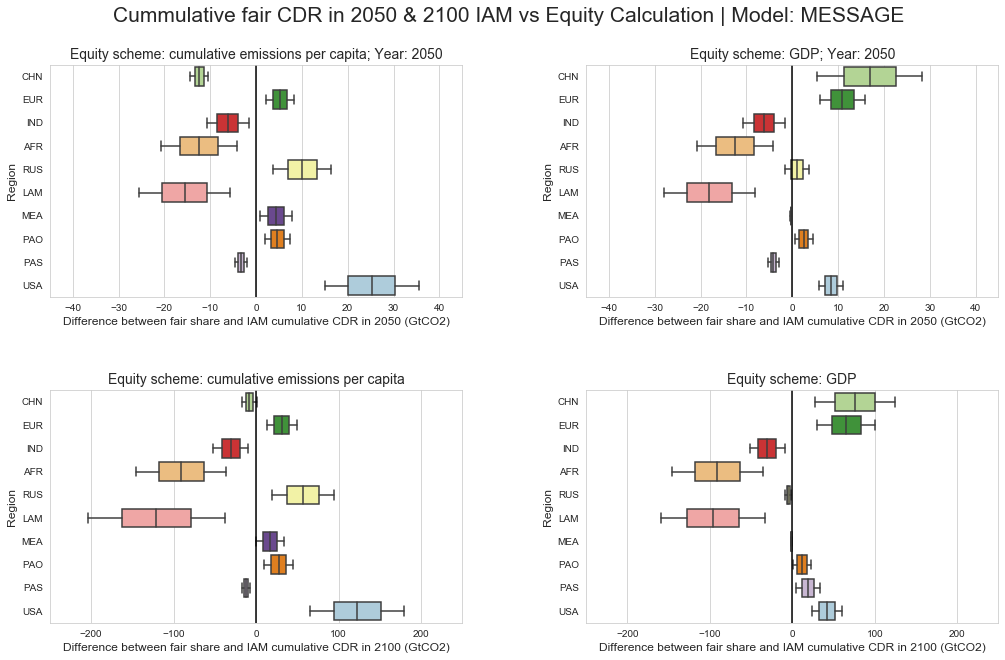

In [536]:
### FIGURE 3 - Plot cumulative fair CDR in 2100  - MESSAGE!!

sns.set_style('whitegrid')
years=[2050,2100]
rfilt_wo_world=(equity_reg_message.Region!='World')
scen_15 =['SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17','SSP5-19-SPA5-V17']
sfilt = (equity_reg_message.Scenario.isin(scen_15))
scen_filt = (equity_reg_message.Scenario.isin(scen_allmodels))

p_data=equity_reg_message[equity_reg_message.Year.isin(years)&rfilt_wo_world&scen_filt]   
# p_data=equity_remind[equity_remind.Year.isin(years)&rfilt_wo_world&sfilt]  #for only RCP1.9 pathways

p_data.loc[:,'CUM_CDR_model_vs_fair_share_by_CUM_POP'] = p_data.loc[:,'CUM_CDR_model_vs_fair_share_by_CUM_POP']/1000
p_data.loc[:,'CUM_CDR_model_vs_fair_share_by_GDP'] = p_data.loc[:,'CUM_CDR_model_vs_fair_share_by_GDP']/1000

CUM_POP_data=pd.DataFrame(columns=['Year','Scenario','Region','CDR_EQ','CDR_DIFF_IAM_vs_Eq','CUM_CDR_EQ','CUM CDR difference IAM vs EQ','EQ_Method'])

CUM_POP_data[['Year','Scenario','Region','CDR_EQ','CDR_DIFF_IAM_vs_Eq',
             'CUM_CDR_EQ','CUM CDR difference IAM vs EQ']]=p_data[['Year','Scenario','Region',
                                                              'CDR_fair_share_by_CUM_POP',
                                                              'CDR_model_vs_fair_share_by_CUM_POP',
                                                              'CUM_CDR_fair_share_by_CUM_POP',
                                                              'CUM_CDR_model_vs_fair_share_by_CUM_POP']]
CUM_POP_data['EQ_Method']='CUM_POP'

GDP_data=pd.DataFrame(columns=['Year','Scenario','Region','CDR_EQ','CDR_DIFF_IAM_vs_Eq','CUM_CDR_EQ','CUM CDR difference IAM vs EQ','EQ_Method'])

GDP_data[['Year','Scenario','Region','CDR_EQ','CDR_DIFF_IAM_vs_Eq'
         ,'CUM_CDR_EQ','CUM CDR difference IAM vs EQ']]=p_data[['Year','Scenario','Region',
                                                              'CDR_fair_share_by_GDP',
                                                              'CDR_model_vs_fair_share_by_GDP',
                                                              'CUM_CDR_fair_share_by_GDP',
                                                              'CUM_CDR_model_vs_fair_share_by_GDP']]
GDP_data['EQ_Method']='GDP'

pl_data=CUM_POP_data.append(GDP_data)

pl_data_50 = pl_data.loc[(pl_data.Year == 2050)& (pl_data.EQ_Method == 'CUM_POP')]
pl_data_50_SSP1 = pl_data_50.loc[(pl_data_50.Scenario == 'SSP1-19')]
pl_data_50_SSP5 = pl_data_50.loc[(pl_data_50.Scenario == 'LowEnergyDemand')]

pl_data_100 = pl_data.loc[(pl_data.Year == 2100)& (pl_data.EQ_Method == 'CUM_POP')]
pl_data_100_SSP1 = pl_data_100.loc[(pl_data_100.Scenario == 'SSP1-19')]
pl_data_100_SSP5 = pl_data_100.loc[(pl_data_100.Scenario == 'LowEnergyDemand')]

gdp_data_50 = pl_data.loc[(pl_data.Year == 2050)& (pl_data.EQ_Method == 'GDP')]
gdp_data_50_SSP1 = gdp_data_50.loc[(gdp_data_50.Scenario == 'SSP1-19')]
gdp_data_50_SSP5 = gdp_data_50.loc[(gdp_data_50.Scenario == 'LowEnergyDemand')]

gdp_data_100 = pl_data.loc[(pl_data.Year == 2100)& (pl_data.EQ_Method == 'GDP')]
gdp_data_100_SSP1 = gdp_data_100.loc[(gdp_data_100.Scenario == 'SSP1-19')]
gdp_data_100_SSP5 = gdp_data_100.loc[(gdp_data_100.Scenario == 'LowEnergyDemand')]

pl_data_50  = pl_data_50.reset_index()
pl_data_100  = pl_data_100.reset_index()
gdp_data_50  = gdp_data_50.reset_index()
gdp_data_100  = gdp_data_100.reset_index()
pl_data_50_SSP1  = pl_data_50_SSP1.reset_index()
pl_data_50_SSP5  = pl_data_50_SSP5.reset_index()
gdp_data_50_SSP1  = gdp_data_50_SSP1.reset_index()
gdp_data_50_SSP5  = gdp_data_50_SSP5.reset_index()
pl_data_100_SSP1  = pl_data_100_SSP1.reset_index()
pl_data_100_SSP5  = pl_data_100_SSP5.reset_index()
gdp_data_100_SSP1  = gdp_data_100_SSP1.reset_index()
gdp_data_100_SSP5  = gdp_data_100_SSP5.reset_index()

fig, axs = plt.subplots(2,2, figsize=(17,10)) #, sharey = True
title = fig.suptitle("Cummulative fair CDR in 2050 & 2100 IAM vs Equity Calculation | Model: MESSAGE", fontsize = 21)
fig.subplots_adjust(top=0.9, wspace=0.3, hspace = 0.4)


colours = sns.color_palette("Paired",12)
colour_palette = [colours[2],colours[3],colours[5],colours[6],colours[10],colours[4], colours[9],colours[7],colours[8],colours[0],colours[1]]
#CHN 0 RUS 1, USA 2, AFR 3, LAM 4, EUR 5, IND 6
# colour_palette = [colours[3],colours[0],colours[1],colours[2],colours[4],colours[5], colours[6]]
#CHN 3 RUS 0, USA 1, AFR 2, LAM 4, EUR 5, IND 6

# box1.set(ylim =(-50,450))
# box1.set(xticklabels=['IAM results','GDP','Cumulative emissions \nper capita'])

# with sns.color_palette("Paired"):
axs_pop_50 = sns.boxplot(x = 'CUM CDR difference IAM vs EQ', y= 'Region', 
                          data= pl_data_50,
                         palette = colour_palette, ax = axs[0,0]).set_title('Equity scheme: cumulative emissions per capita; Year: 2050', fontsize = 14)
axs_pop_100 = sns.boxplot(x = 'CUM CDR difference IAM vs EQ', y= 'Region', 
                           data= pl_data_100, 
                          palette = colour_palette, ax = axs[1,0]).set_title('Equity scheme: cumulative emissions per capita', fontsize = 14)
axs_gdp_50 = sns.boxplot(x = 'CUM CDR difference IAM vs EQ', y= 'Region', 
                         data= gdp_data_50, 
                         palette = colour_palette, ax = axs[0,1]).set_title('Equity scheme: GDP; Year: 2050', fontsize = 14)
axs_gdp_100 = sns.boxplot(x = 'CUM CDR difference IAM vs EQ', y= 'Region', 
                           data= gdp_data_100, 
                          palette = colour_palette, ax = axs[1,1]).set_title('Equity scheme: GDP', fontsize = 14)


axs[0,0].set_xlim([-45, 45])
axs[1,0].set_xlim([-250, 250])
axs[0,1].set_xlim([-45, 45])
axs[1,1].set_xlim([-250, 250])

axs[0,0].axvline(color = 'black')
axs[1,0].axvline(color = 'black')
axs[0,1].axvline(color = 'black')
axs[1,1].axvline(color = 'black')

axs[1,0].set(xlabel = "Difference between fair share and IAM cumulative CDR in 2100 (GtCO2)")
axs[1,1].set(xlabel = "Difference between fair share and IAM cumulative CDR in 2100 (GtCO2)")
axs[0,0].set(xlabel = "Difference between fair share and IAM cumulative CDR in 2050 (GtCO2)")
axs[0,1].set(xlabel = "Difference between fair share and IAM cumulative CDR in 2050 (GtCO2)")
plt.savefig(plot_path + 'F - Figure 4 - MESSAGE Regions.png')
#plt.savefig(plot_path + 'Figure 4 - REMIND.svg', dpi = 300, edgecolor = "white", transparent = True)

/Users/susannebaur/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


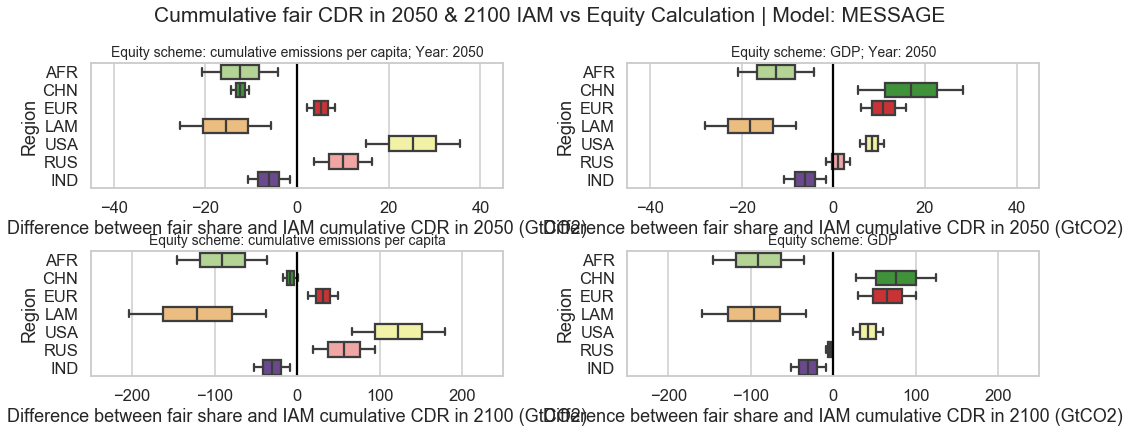

In [101]:
### FIGURE 3 - Plot cumulative fair CDR in 2100  - only IMAGE!!

sns.set_style('whitegrid')
years=[2050,2100]
rfilt_wo_world=(equity_equal_message.Region!='World')
scen_15 =['SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17','SSP5-19-SPA5-V17']
sfilt = (equity_equal_message.Scenario.isin(scen_15))
scen_filt = (equity_equal_message.Scenario.isin(scen_allmodels))

p_data=equity_equal_message[equity_equal_message.Year.isin(years)&rfilt_wo_world&scen_filt]   
# p_data=equity_remind[equity_remind.Year.isin(years)&rfilt_wo_world&sfilt]  #for only RCP1.9 pathways

p_data.loc[:,'CUM_CDR_model_vs_fair_share_by_CUM_POP'] = p_data.loc[:,'CUM_CDR_model_vs_fair_share_by_CUM_POP']/1000
p_data.loc[:,'CUM_CDR_model_vs_fair_share_by_GDP'] = p_data.loc[:,'CUM_CDR_model_vs_fair_share_by_GDP']/1000

CUM_POP_data=pd.DataFrame(columns=['Year','Scenario','Region','CDR_EQ','CDR_DIFF_IAM_vs_Eq','CUM_CDR_EQ','CUM CDR difference IAM vs EQ','EQ_Method'])

CUM_POP_data[['Year','Scenario','Region','CDR_EQ','CDR_DIFF_IAM_vs_Eq',
             'CUM_CDR_EQ','CUM CDR difference IAM vs EQ']]=p_data[['Year','Scenario','Region',
                                                              'CDR_fair_share_by_CUM_POP',
                                                              'CDR_model_vs_fair_share_by_CUM_POP',
                                                              'CUM_CDR_fair_share_by_CUM_POP',
                                                              'CUM_CDR_model_vs_fair_share_by_CUM_POP']]
CUM_POP_data['EQ_Method']='CUM_POP'

GDP_data=pd.DataFrame(columns=['Year','Scenario','Region','CDR_EQ','CDR_DIFF_IAM_vs_Eq','CUM_CDR_EQ','CUM CDR difference IAM vs EQ','EQ_Method'])

GDP_data[['Year','Scenario','Region','CDR_EQ','CDR_DIFF_IAM_vs_Eq'
         ,'CUM_CDR_EQ','CUM CDR difference IAM vs EQ']]=p_data[['Year','Scenario','Region',
                                                              'CDR_fair_share_by_GDP',
                                                              'CDR_model_vs_fair_share_by_GDP',
                                                              'CUM_CDR_fair_share_by_GDP',
                                                              'CUM_CDR_model_vs_fair_share_by_GDP']]
GDP_data['EQ_Method']='GDP'

pl_data=CUM_POP_data.append(GDP_data)

pl_data_50 = pl_data.loc[(pl_data.Year == 2050)& (pl_data.EQ_Method == 'CUM_POP')]
pl_data_50_SSP1 = pl_data_50.loc[(pl_data_50.Scenario == 'SSP1-19')]
pl_data_50_SSP5 = pl_data_50.loc[(pl_data_50.Scenario == 'LowEnergyDemand')]

pl_data_100 = pl_data.loc[(pl_data.Year == 2100)& (pl_data.EQ_Method == 'CUM_POP')]
pl_data_100_SSP1 = pl_data_100.loc[(pl_data_100.Scenario == 'SSP1-19')]
pl_data_100_SSP5 = pl_data_100.loc[(pl_data_100.Scenario == 'LowEnergyDemand')]

gdp_data_50 = pl_data.loc[(pl_data.Year == 2050)& (pl_data.EQ_Method == 'GDP')]
gdp_data_50_SSP1 = gdp_data_50.loc[(gdp_data_50.Scenario == 'SSP1-19')]
gdp_data_50_SSP5 = gdp_data_50.loc[(gdp_data_50.Scenario == 'LowEnergyDemand')]

gdp_data_100 = pl_data.loc[(pl_data.Year == 2100)& (pl_data.EQ_Method == 'GDP')]
gdp_data_100_SSP1 = gdp_data_100.loc[(gdp_data_100.Scenario == 'SSP1-19')]
gdp_data_100_SSP5 = gdp_data_100.loc[(gdp_data_100.Scenario == 'LowEnergyDemand')]

pl_data_50  = pl_data_50.reset_index()
pl_data_100  = pl_data_100.reset_index()
gdp_data_50  = gdp_data_50.reset_index()
gdp_data_100  = gdp_data_100.reset_index()
pl_data_50_SSP1  = pl_data_50_SSP1.reset_index()
pl_data_50_SSP5  = pl_data_50_SSP5.reset_index()
gdp_data_50_SSP1  = gdp_data_50_SSP1.reset_index()
gdp_data_50_SSP5  = gdp_data_50_SSP5.reset_index()
pl_data_100_SSP1  = pl_data_100_SSP1.reset_index()
pl_data_100_SSP5  = pl_data_100_SSP5.reset_index()
gdp_data_100_SSP1  = gdp_data_100_SSP1.reset_index()
gdp_data_100_SSP5  = gdp_data_100_SSP5.reset_index()

fig, axs = plt.subplots(2,2, figsize=(17,6)) #, sharey = True
title = fig.suptitle("Cummulative fair CDR in 2050 & 2100 IAM vs Equity Calculation | Model: MESSAGE", fontsize = 21)
fig.subplots_adjust(top=0.85, wspace=0.3, hspace = 0.5)

regions_order = ['AFR', 'CHN', 'EUR', 'LAM', 'USA', 'RUS', 'IND']

colours = sns.color_palette("Paired",12)
colour_palette = [colours[2],colours[3],colours[5],colours[6],colours[10],colours[4], colours[9],colours[7],colours[8],colours[0],colours[1]]
#CHN 0 RUS 1, USA 2, AFR 3, LAM 4, EUR 5, IND 6
# colour_palette = [colours[3],colours[0],colours[1],colours[2],colours[4],colours[5], colours[6]]
#CHN 3 RUS 0, USA 1, AFR 2, LAM 4, EUR 5, IND 6

# box1.set(ylim =(-50,450))
# box1.set(xticklabels=['IAM results','GDP','Cumulative emissions \nper capita'])


axs_pop_50 = sns.boxplot(x = 'CUM CDR difference IAM vs EQ', y= 'Region', 
                         order = regions_order, data= pl_data_50,
                         palette = colour_palette, ax = axs[0,0]).set_title('Equity scheme: cumulative emissions per capita; Year: 2050', fontsize = 14)
axs_pop_100 = sns.boxplot(x = 'CUM CDR difference IAM vs EQ', y= 'Region', 
                          order = regions_order, data= pl_data_100, 
                          palette = colour_palette, ax = axs[1,0]).set_title('Equity scheme: cumulative emissions per capita', fontsize = 14)
axs_gdp_50 = sns.boxplot(x = 'CUM CDR difference IAM vs EQ', y= 'Region', 
                         order = regions_order, data= gdp_data_50, 
                         palette = colour_palette, ax = axs[0,1]).set_title('Equity scheme: GDP; Year: 2050', fontsize = 14)
axs_gdp_100 = sns.boxplot(x = 'CUM CDR difference IAM vs EQ', y= 'Region', 
                          order = regions_order, data= gdp_data_100, 
                          palette = colour_palette, ax = axs[1,1]).set_title('Equity scheme: GDP', fontsize = 14)


axs[0,0].set_xlim([-45, 45])
axs[1,0].set_xlim([-250, 250])
axs[0,1].set_xlim([-45, 45])
axs[1,1].set_xlim([-250, 250])

axs[0,0].axvline(color = 'black')
axs[1,0].axvline(color = 'black')
axs[0,1].axvline(color = 'black')
axs[1,1].axvline(color = 'black')

axs[1,0].set(xlabel = "Difference between fair share and IAM cumulative CDR in 2100 (GtCO2)")
axs[1,1].set(xlabel = "Difference between fair share and IAM cumulative CDR in 2100 (GtCO2)")
axs[0,0].set(xlabel = "Difference between fair share and IAM cumulative CDR in 2050 (GtCO2)")
axs[0,1].set(xlabel = "Difference between fair share and IAM cumulative CDR in 2050 (GtCO2)")


#axs_pop_100.set(xlabel = "Difference between fair share and IAM cumulative CDR in 2100 (GtCO2)")
#axs_gdp_100.set(xlabel = "Difference between fair share and IAM cumulative CDR in 2100 (GtCO2)")
# axs_pop_50.legend()
plt.savefig(plot_path + 'F - Figure 4 - MESSAGE.png')
#plt.savefig(plot_path + 'Figure 4 - REMIND.svg', dpi = 300, edgecolor = "white", transparent = True)

/Users/susannebaur/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


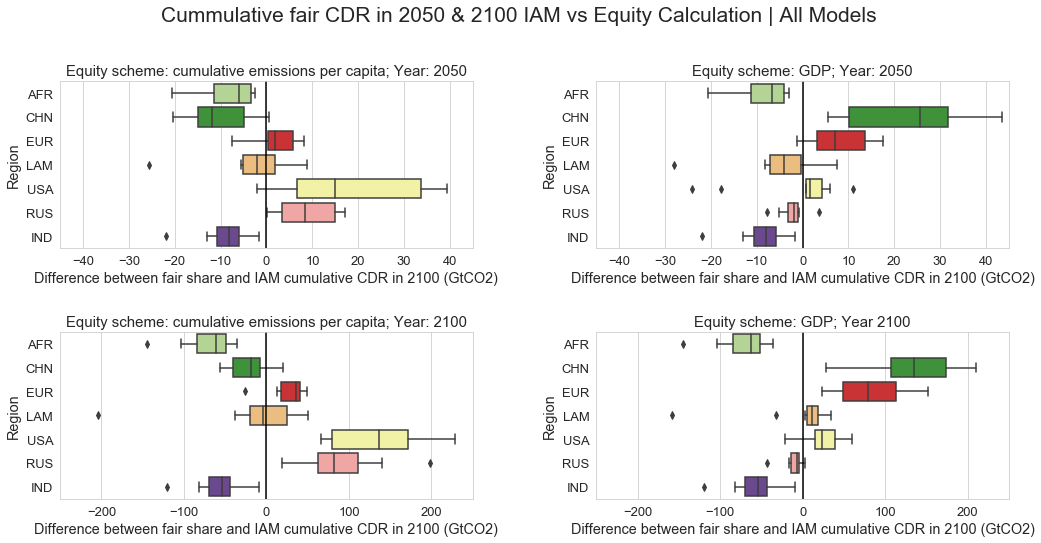

In [172]:
### FIGURE 3 - Plot cumulative fair CDR in 2100  - all models!!

#sns.set_style('whitegrid')
years=[2050,2100]
rfilt_wo_world=(allmodels_equal_df.Region!='World')
scen_15 =['SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17','SSP5-19-SPA5-V17']
sfilt = (allmodels_equal_df.Scenario.isin(scen_15))
scen_filt = (allmodels_equal_df.Scenario.isin(scen_allmodels))

p_data=allmodels_equal_df[allmodels_equal_df.Year.isin(years)&rfilt_wo_world&scen_filt]   
# p_data=equity_remind[equity_remind.Year.isin(years)&rfilt_wo_world&sfilt]  #for only RCP1.9 pathways

p_data.loc[:,'CUM_CDR_model_vs_fair_share_by_CUM_POP'] = p_data.loc[:,'CUM_CDR_model_vs_fair_share_by_CUM_POP']/1000
p_data.loc[:,'CUM_CDR_model_vs_fair_share_by_GDP'] = p_data.loc[:,'CUM_CDR_model_vs_fair_share_by_GDP']/1000

CUM_POP_data=pd.DataFrame(columns=['Year','Scenario','Region','CDR_EQ','CDR_DIFF_IAM_vs_Eq','CUM_CDR_EQ','CUM CDR difference IAM vs EQ','EQ_Method'])

CUM_POP_data[['Year','Scenario','Region','CDR_EQ','CDR_DIFF_IAM_vs_Eq',
             'CUM_CDR_EQ','Difference between fair share and IAM cumulative CDR in 2100 (GtCO2)']]=p_data[['Year','Scenario','Region',
                                                              'CDR_fair_share_by_CUM_POP',
                                                              'CDR_model_vs_fair_share_by_CUM_POP',
                                                              'CUM_CDR_fair_share_by_CUM_POP',
                                                              'CUM_CDR_model_vs_fair_share_by_CUM_POP']]
CUM_POP_data['EQ_Method']='CUM_POP'

GDP_data=pd.DataFrame(columns=['Year','Scenario','Region','CDR_EQ','CDR_DIFF_IAM_vs_Eq','CUM_CDR_EQ','CUM CDR difference IAM vs EQ','EQ_Method'])

GDP_data[['Year','Scenario','Region','CDR_EQ','CDR_DIFF_IAM_vs_Eq'
         ,'CUM_CDR_EQ','Difference between fair share and IAM cumulative CDR in 2100 (GtCO2)']]=p_data[['Year','Scenario','Region',
                                                              'CDR_fair_share_by_GDP',
                                                              'CDR_model_vs_fair_share_by_GDP',
                                                              'CUM_CDR_fair_share_by_GDP',
                                                              'CUM_CDR_model_vs_fair_share_by_GDP']]
GDP_data['EQ_Method']='GDP'

pl_data=CUM_POP_data.append(GDP_data)

pl_data_50 = pl_data.loc[(pl_data.Year == 2050)& (pl_data.EQ_Method == 'CUM_POP')]
pl_data_50_SSP1 = pl_data_50.loc[(pl_data_50.Scenario == 'SSP1-19-SPA0-V17')]
pl_data_50_SSP5 = pl_data_50.loc[(pl_data_50.Scenario == 'SSP2-LF-SPA2-V17')]

pl_data_100 = pl_data.loc[(pl_data.Year == 2100)& (pl_data.EQ_Method == 'CUM_POP')]
pl_data_100_SSP1 = pl_data_100.loc[(pl_data_100.Scenario == 'SSP1-19-SPA0-V17')]
pl_data_100_SSP5 = pl_data_100.loc[(pl_data_100.Scenario == 'SSP2-LF-SPA2-V17')]

gdp_data_50 = pl_data.loc[(pl_data.Year == 2050)& (pl_data.EQ_Method == 'GDP')]
gdp_data_50_SSP1 = gdp_data_50.loc[(gdp_data_50.Scenario == 'SSP1-19-SPA0-V17')]
gdp_data_50_SSP5 = gdp_data_50.loc[(gdp_data_50.Scenario == 'SSP2-LF-SPA2-V17')]

gdp_data_100 = pl_data.loc[(pl_data.Year == 2100)& (pl_data.EQ_Method == 'GDP')]
gdp_data_100_SSP1 = gdp_data_100.loc[(gdp_data_100.Scenario == 'SSP1-19-SPA0-V17')]
gdp_data_100_SSP5 = gdp_data_100.loc[(gdp_data_100.Scenario == 'SSP2-LF-SPA2-V17')]

pl_data_50  = pl_data_50.reset_index()
pl_data_100  = pl_data_100.reset_index()
gdp_data_50  = gdp_data_50.reset_index()
gdp_data_100  = gdp_data_100.reset_index()
pl_data_50_SSP1  = pl_data_50_SSP1.reset_index()
pl_data_50_SSP5  = pl_data_50_SSP5.reset_index()
gdp_data_50_SSP1  = gdp_data_50_SSP1.reset_index()
gdp_data_50_SSP5  = gdp_data_50_SSP5.reset_index()
pl_data_100_SSP1  = pl_data_100_SSP1.reset_index()
pl_data_100_SSP5  = pl_data_100_SSP5.reset_index()
gdp_data_100_SSP1  = gdp_data_100_SSP1.reset_index()
gdp_data_100_SSP5  = gdp_data_100_SSP5.reset_index()


fig, axs = plt.subplots(2,2,  figsize=(17,8)) #, sharey = True
title = fig.suptitle("Cummulative fair CDR in 2050 & 2100 IAM vs Equity Calculation | All Models", fontsize = 21)
fig.subplots_adjust(top=0.85, wspace=0.3, hspace = 0.5)

regions_order = ['AFR', 'CHN', 'EUR', 'LAM', 'USA', 'RUS', 'IND']
colours = sns.color_palette("Paired",12)
colour_palette = [colours[2],colours[3],colours[5],colours[6],colours[10],colours[4], colours[9],colours[7],colours[8],colours[0],colours[1]]
#CHN 0 RUS 1, USA 2, AFR 3, LAM 4, EUR 5, IND 6
# colour_palette = [colours[3],colours[0],colours[1],colours[2],colours[4],colours[5], colours[6]]
#CHN 3 RUS 0, USA 1, AFR 2, LAM 4, EUR 5, IND 6


# with sns.color_palette("Paired"):
axs_pop_50 = sns.boxplot(x = 'Difference between fair share and IAM cumulative CDR in 2100 (GtCO2)', y= 'Region', 
                         order = regions_order, data= pl_data_50,
                         palette = colour_palette, ax = axs[0,0]).set_title('Equity scheme: cumulative emissions per capita; Year: 2050', fontsize = 15)
axs_pop_100 = sns.boxplot(x = 'Difference between fair share and IAM cumulative CDR in 2100 (GtCO2)', y= 'Region', 
                          order = regions_order, data= pl_data_100, 
                          palette = colour_palette, ax = axs[1,0]).set_title('Equity scheme: cumulative emissions per capita; Year: 2100', fontsize = 15)
axs_gdp_50 = sns.boxplot(x = 'Difference between fair share and IAM cumulative CDR in 2100 (GtCO2)', y= 'Region', 
                         order = regions_order, data= gdp_data_50, 
                         palette = colour_palette, ax = axs[0,1]).set_title('Equity scheme: GDP; Year: 2050', fontsize = 15)
axs_gdp_100 = sns.boxplot(x = 'Difference between fair share and IAM cumulative CDR in 2100 (GtCO2)', y= 'Region', 
                          order = regions_order, data= gdp_data_100, 
                          palette = colour_palette, ax = axs[1,1]).set_title('Equity scheme: GDP; Year 2100', fontsize = 15)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


axs[0,0].tick_params(labelsize=13)
axs[1,0].tick_params(labelsize=13)
axs[0,1].tick_params(labelsize=13)
axs[1,1].tick_params(labelsize=13)

axs[0,0].set_xlim([-45, 45])
axs[1,0].set_xlim([-250, 250])
axs[0,1].set_xlim([-45, 45])
axs[1,1].set_xlim([-250, 250])

axs[0,0].axvline(color = 'black')
axs[1,0].axvline(color = 'black')
axs[0,1].axvline(color = 'black')
axs[1,1].axvline(color = 'black')

#axs[1,0].set(xlabel = "Difference between fair share and IAM cumulative CDR in 2100 (GtCO2)")
#axs[1,1].set(xlabel = "Difference between fair share and IAM cumulative CDR in 2100 (GtCO2)")
#axs[0,0].set(xlabel = "Difference between fair share and IAM cumulative CDR in 2050 (GtCO2)")
#axs[0,1].set(xlabel = "Difference between fair share and IAM cumulative CDR in 2050 (GtCO2)")


plt.savefig(plot_path + 'F - Figure 4 - all models.png')
#plt.savefig(plot_path + 'Figure 4 - REMIND.svg', dpi = 300, edgecolor = "white", transparent = True)

In [99]:
allmodels_df['CUM_CO2_per_cap_INCL_CDR'] = allmodels_df['CUM_CO2'] / allmodels_df['cumPopulation']



In [331]:
allmodels_df.to_excel(data_path + 'allmodels_df_plot_table.xls')

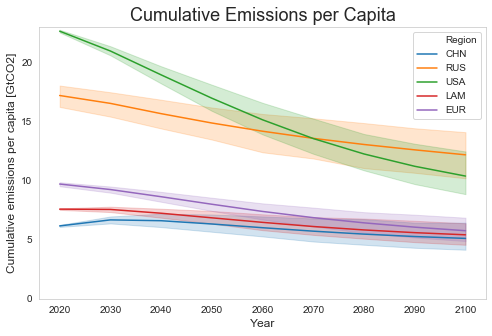

In [528]:
# Conceptual Figure - Cum emissions per cap 

# List of regions of interest
regions=['USA','EUR','CHN','RUS', 'LAM']
variable = 'CUM_CO2_per_cap'

df = allmodels_df[(allmodels_df.Region.isin(regions))]

f,ax=plt.subplots(figsize=(8,5))
ax = sns.lineplot(x='Year',y='CUM_CO2_per_cap',data=df,hue='Region', ax=ax)
ax.set(ylim=(0, 23))
ax.set_ylabel('Cumulative emissions per capita [GtCO2]', fontsize = 12)
ax.grid(False)
ax.set_title('Cumulative Emissions per Capita', fontsize = 18)
ax.set_xlabel('Year', fontsize = 12)
#ax[1,0].legend(loc='lower left', bbox_to_anchor=(1,0),ncol=2)

plt.savefig(plot_path + 'F - Concept.Fig - Cum_em.png')

/Users/susannebaur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


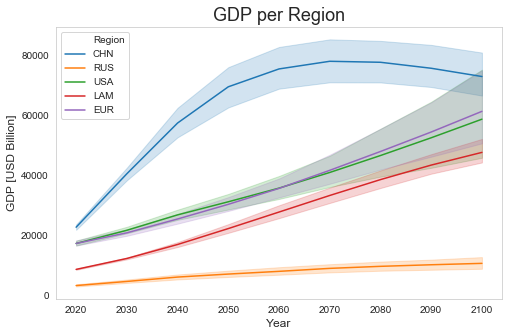

In [531]:
# Conceptual Figure - GDP 
df = allmodels_df[(allmodels_df.Region.isin(regions))]

df['GDP_Bil'] = df.loc[:,'GDP']/1000 #USD Million 

f,ax=plt.subplots(figsize=(8,5))
ax = sns.lineplot(x='Year',y='GDP_Bil',data=df,hue='Region', ax=ax)
ax.grid(False)
ax.set_title('GDP per Region', fontsize = 18)
ax.set_ylabel('GDP [USD Billion]', fontsize = 12)
ax.set_xlabel('Year', fontsize = 12)

plt.savefig(plot_path + 'F - Concept.Fig - GDP.png')